## Stage 0: (Optional) Mount to google drive ans imports
In a production setting, our pipeline downloads data programmatically
 from the ISIC API at runtime. However, to avoid re-downloading the entire
       dataset every time a Colab session restarts, we instead mount Google Drive here and read the cached files directly.
       

In [ ]:
# Import Drive
from google.colab import output
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Standard library
import os
import time
import random

# Data handling
import requests
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm

# PyTorch & vision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import timm
import torchvision.transforms as transforms

# Scikit-learn metrics & utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve, f1_score,
    balanced_accuracy_score,
    precision_recall_fscore_support,
    classification_report
)

# Plotting
import matplotlib.pyplot as plt


## Stage 1: Data Acquisition & Exploration
- Download raw images and metadata from the ISIC API  
- Inspect dataset structure and class distribution  


Load the dataset ISIC(collection 66, representative of the training set of task 3) into the *results* variable, ~11k entries

In [ ]:
base_url = "https://api.isic-archive.com/api/v2/images/search/"
params = {
    "collections": "66,67,73"
}

all_ids = []
results = []

page = 1
start = time.time()

while True:
    response = requests.get(base_url, params=params)
    data = response.json()

    # Extract image IDs
    for result in data.get("results", []):
        all_ids.append(result["isic_id"])
        results.append(result)

    # Next page
    next_cursor = data.get("next")
    if not next_cursor:
        break

    # Update URL for the next request
    base_url = next_cursor
    params = {}
    page += 1

elapsed = time.time() - start
print(f"Total images collected: {len(all_ids)}")
print(f"Took {elapsed:.1f} seconds")

Total images collected: 11720
Took 171.9 seconds


Inspecting a single record to understand its structure and contents

In [ ]:
results[5]

{'isic_id': 'ISIC_0036059',
 'copyright_license': 'CC-BY-NC',
 'attribution': 'MILK study team',
 'files': {'full': {'url': 'https://content.isic-archive.com/b1da82d9-f96a-4279-a22d-4df086f862e8/ab106229-0d37-440d-82e1-ea0f8b346576.jpg?Expires=1747180800&Signature=NNUSpQLU5E1CEImITFo6AsJl3oyRfTHXicF70IrnrxR~7iLvF0AAfaBOTE7rQfNywpaJfgMmGe6NvspOeg4oWHEJl2aNZOPZbgknY-HiPkCmcwXt9BJ8exkzgKxtGztpfM8dA-bu~3zzM9Hf-uySOoDG0xoXQLGD1jZBe2JsKDHbbkARG0JSLJvTNYP-7bQzULLXf2h-izyQylVmAMoisXVNVo2hfNyFFAsQardEB-DyA0C0wvh55obWywtdti2ZrDaYVyFy7iyEoWt6wJnGBfRrnhHdDLxKCexF5gv52TwFZI5Wn0EkcZLNgpndD2it3e5OccRq96L-U1LGWmJFKg__&Key-Pair-Id=K3KFHCM130RXTL',
   'size': 19565},
  'thumbnail_256': {'url': 'https://content.isic-archive.com/8430b64f-83c0-4f66-98ab-260535ab538c/ISIC_0036059_thumbnail_256.jpg?Expires=1747180800&Signature=bM5rdi~9P7OJZRsPRZKY0hhNjMqNa209BEhxsjtnjCh-yGc~ymUsj3vRtfhnQFQGicH6oIxEVfz63pj2f5R~9c0BHbVZ~4lgX7e4ENaWEtHnH-f1-Vvtm6I0xrv9WyE46JdHUFAEXdksPlOAz4J6zuJCJufP7noWnIJQJVReHaDfbOibdKUTNGXu

**We will confirm if every image is in the expected size (600x450)**

In [ ]:
# Verify that all images are 600×450 pixels(Expected size)
mismatch_count = 0

for entry in results:
    try:
        x = entry["metadata"]["acquisition"]["pixels_x"]
        y = entry["metadata"]["acquisition"]["pixels_y"]
        if (x, y) != (600, 450):
            print(f"Image {entry['isic_id']} has size {x}×{y}, expected 600×450")
            mismatch_count += 1
    except KeyError:
        print(f"Image {entry.get('isic_id', 'UNKNOWN')} is missing pixel metadata.")
        mismatch_count += 1

if mismatch_count == 0:
    print("All images are confirmed to be 600×450 pixels.")
else:
    print(f"Found {mismatch_count} image(s) with unexpected dimensions or missing data.")


All images are confirmed to be 600×450 pixels.


Download the photos into ISIC_IMAGES_TASK_3 folder

In [ ]:
PATH = "/content/drive/MyDrive/ISIC_IMAGES_TASK_3"

In [ ]:
"""Download and extract ZIP files into ISIC_IMAGES_TASK_3 folder with timing"""

import os
import zipfile
import urllib.request
import time

# Start timing
total_start = time.time()

# Target folder
PATH = "ISIC_IMAGES_TASK_3"
os.makedirs(PATH, exist_ok=True)

# Base URL for raw GitHub content
base_url = "https://github.com/PedroDiz/AP-2025/raw/main/"

# List of ZIP file names
zip_files = [
    "ISIC_IMAGES_TASK_3_PART_1.zip",
    "ISIC_IMAGES_TASK_3_PART_2.zip",
    "ISIC_IMAGES_TASK_3_PART_3.zip"
]

# Download and extract each ZIP file
for zip_file in zip_files:
    start = time.time()

    zip_path = os.path.join(os.getcwd(), zip_file)
    url = base_url + zip_file

    # Download if not already present
    if not os.path.exists(zip_path):
        print(f"Downloading {zip_file}...")
        urllib.request.urlretrieve(url, zip_path)
        print(f"Downloaded {zip_file} in {time.time() - start:.1f} seconds")
    else:
        print(f"{zip_file} already exists, skipping download")

    # Extract into PATH
    print(f"Extracting {zip_file}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(PATH)
    print(f"Extracted {zip_file} in {time.time() - start:.1f} seconds")

# Total elapsed time
total_elapsed = time.time() - total_start
print(f"\nTotal time: {total_elapsed:.1f} seconds")

In [ ]:
"""
import os
import requests
import time
from tqdm import tqdm

# Make sure the folder exists
PATH = "ISIC_IMAGES_TASK_3"
os.makedirs(PATH, exist_ok=True)

# Start the timer
download_start = time.time()

# Optionally, to capture per‐image times:
per_image_times = []

for result in tqdm(results, desc="Downloading ISIC images"):
    img_start = time.time()
    try:
        isic_id   = result["isic_id"]
        image_url = result["files"]["full"]["url"]
        file_path = os.path.join(PATH, f"{isic_id}.jpg")

        # Download and save the image
        r = requests.get(image_url)
        if r.status_code == 200:
            with open(file_path, "wb") as f:
                f.write(r.content)
        else:
            print(f"Failed to download {isic_id}: HTTP {r.status_code}")
    except KeyError as e:
        print(f"Missing key {e} in one of the results.")
    finally:
        # Record how long this single download took
        per_image_times.append(time.time() - img_start)

# Total download time
total_download_time = time.time() - download_start
print(f"Total download time: {total_download_time:.1f}s")

# Per‐image times:
print(f"Avg per‐image download time: {np.mean(per_image_times):.2f}s")
print(f"Slowest image took: {np.max(per_image_times):.2f}s")
print(f"Fastest image took: {np.min(per_image_times):.2f}s")

"""

'\nimport os\nimport requests\nimport time\nfrom tqdm import tqdm\n\n# Make sure the folder exists\nPATH = "ISIC_IMAGES_TASK_3"\nos.makedirs(PATH, exist_ok=True)\n\n# Start the timer\ndownload_start = time.time()\n\n# Optionally, to capture per‐image times:\nper_image_times = []\n\nfor result in tqdm(results, desc="Downloading ISIC images"):\n    img_start = time.time()\n    try:\n        isic_id   = result["isic_id"]\n        image_url = result["files"]["full"]["url"]\n        file_path = os.path.join(PATH, f"{isic_id}.jpg")\n\n        # Download and save the image\n        r = requests.get(image_url)\n        if r.status_code == 200:\n            with open(file_path, "wb") as f:\n                f.write(r.content)\n        else:\n            print(f"Failed to download {isic_id}: HTTP {r.status_code}")\n    except KeyError as e:\n        print(f"Missing key {e} in one of the results.")\n    finally:\n        # Record how long this single download took\n        per_image_times.append(t

**Determine how each image is labeled as benign or malignant.**

We’ll use the `benign_malignant` field for this purpose and first verify that every dataset entry includes this label.


In [ ]:
# List unique values for 'benign_malignant' and count missing entries
unique_vals = set()
missing_count = 0

for entry in results:
    clinical = entry.get("metadata", {}).get("clinical", {})
    val = clinical.get("benign_malignant", None)
    if val is None:
        missing_count += 1
    else:
        unique_vals.add(val)

# Print the unique labels found
if unique_vals:
    print(f"Unique 'benign_malignant' values: {', '.join(sorted(unique_vals))}")
else:
    print("No entries possess the 'benign_malignant' parameter.")

# Report how many are missing
if missing_count > 0:
    print(f"{missing_count} entries do not possess the 'benign_malignant' parameter.")


Unique 'benign_malignant' values: benign, malignant
2678 entries do not possess the 'benign_malignant' parameter.


**Summary:** A number of records are missing the `benign_malignant` attribute, so we must select an alternative field. The `diagnosis_1` attribute appears suitable for this task; next, we will examine its possible values.


In [ ]:
missing_diagnosis_1_values = set()

for entry in results:
    clinical = entry.get("metadata", {}).get("clinical", {})

    if "benign_malignant" not in clinical:
        diag1 = clinical.get("diagnosis_1")
        if diag1:
            missing_diagnosis_1_values.add(diag1)

print(" Unique 'diagnosis_1' values for entries missing 'benign_malignant':")
for value in sorted(missing_diagnosis_1_values):
    print("-", value)


 Unique 'diagnosis_1' values for entries missing 'benign_malignant':
- Benign
- Indeterminate
- Malignant


**Conclusion:** For records lacking the `benign_malignant` attribute, we will use `diagnosis_1`, which also indicates lesion pathology. Entries where `diagnosis_1` equals “Indeterminate” will be excluded, as they do not provide definitive diagnostic information.


We will construct `lesions.csv` with the following columns:

- **file**: `<isic_id>.jpg`  
- **patient**: `lesion_id`  
- **label**:  
  - `0` for records where `benign_malignant == "benign"`  
  - `1` for records where `benign_malignant == "malignant"`  







In [ ]:
rows = []
start = time.time()
for result in results:
    try:
        isic_id = result["isic_id"]
        filename = f"{isic_id}.jpg"
        clinical = result["metadata"]["clinical"]
        patient = clinical.get("lesion_id", "unknown")

        benign_malignant = clinical.get("benign_malignant")
        diagnosis_1 = clinical.get("diagnosis_1", "")

        if benign_malignant:
            label = 1 if benign_malignant.lower() == "malignant" else 0
        elif diagnosis_1 == "Benign":
            label = 0
        elif diagnosis_1 == "Malignant":
            label = 1
        else:  # Indeterminate or unknown
            continue

        rows.append({
            "file": filename,
            "patient": patient,
            "label": label
        })

    except Exception as e:
        print(f"Skipped entry {result.get('isic_id', 'UNKNOWN')} due to error: {e}")

# Create DataFrame and write to CSV
df = pd.DataFrame(rows)
df.to_csv("lesions.csv", index=False)

elapsed = time.time() - start
print(f"Took {elapsed:.1f} seconds")

print("Saved lesions.csv with", len(df), "entries.")


Took 0.0 seconds
Saved lesions.csv with 11571 entries.


### Excluding HAM10000 Dataset (Deprecated)

Through detailed investigation, we determined that the HAM10000 dataset is fully subsumed by the ISIC 2018 Task 3 collection, resulting in duplicate images. To avoid redundancy, we have removed HAM10000 from our analysis.

The following code snippet confirms this overlap by comparing the ISIC image IDs with those in the HAM10000 metadata:


In [ ]:
"""import kagglehub
import os
import shutil
from tqdm import tqdm

# Step 1: Download the dataset
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print("Dataset downloaded to:", path)

# Step 2: Create destination folder
dst_dir = "KAGGLE_IMAGES_ham10000"
os.makedirs(dst_dir, exist_ok=True)

# Step 3: Walk the directory and copy .jpg files
count = 0
for root, _, files in os.walk(path):
    for file in files:
        if file.lower().endswith(".jpg"):
            src_path = os.path.join(root, file)
            dst_path = os.path.join(dst_dir, file)
            shutil.copy2(src_path, dst_path)
            count += 1

print(f"Copied {count} .jpg files into '{dst_dir}'")
meta_src = os.path.join(path, "HAM10000_metadata.csv")
meta_dst = os.path.join(dst_dir, "HAM10000_metadata.csv")
shutil.copy2(meta_src, meta_dst)
print("Copied metadata file to:", dst_dir)"""

'import kagglehub\nimport os\nimport shutil\nfrom tqdm import tqdm\n\n# Step 1: Download the dataset\npath = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")\nprint("Dataset downloaded to:", path)\n\n# Step 2: Create destination folder\ndst_dir = "KAGGLE_IMAGES_ham10000"\nos.makedirs(dst_dir, exist_ok=True)\n\n# Step 3: Walk the directory and copy .jpg files\ncount = 0\nfor root, _, files in os.walk(path):\n    for file in files:\n        if file.lower().endswith(".jpg"):\n            src_path = os.path.join(root, file)\n            dst_path = os.path.join(dst_dir, file)\n            shutil.copy2(src_path, dst_path)\n            count += 1\n\nprint(f"Copied {count} .jpg files into \'{dst_dir}\'")\nmeta_src = os.path.join(path, "HAM10000_metadata.csv")\nmeta_dst = os.path.join(dst_dir, "HAM10000_metadata.csv")\nshutil.copy2(meta_src, meta_dst)\nprint("Copied metadata file to:", dst_dir)'

In [ ]:
"""metadata_path = "KAGGLE_IMAGES_ham10000/HAM10000_metadata.csv"
df = pd.read_csv(metadata_path)

metadata_ids = set(df["image_id"])

all_ids_set = set(all_ids)

missing_ids = metadata_ids - all_ids_set

print(f"Found {len(missing_ids)} image_ids in HAM10000 metadata that are not in all_ids:")
for mid in sorted(missing_ids):
    print("-", mid)"""


'metadata_path = "KAGGLE_IMAGES_ham10000/HAM10000_metadata.csv"\ndf = pd.read_csv(metadata_path)\n\nmetadata_ids = set(df["image_id"])\n\nall_ids_set = set(all_ids)\n\nmissing_ids = metadata_ids - all_ids_set\n\nprint(f"Found {len(missing_ids)} image_ids in HAM10000 metadata that are not in all_ids:")\nfor mid in sorted(missing_ids):\n    print("-", mid)'

#Stage 2: Data & Preprocessing




**Patient‐wise 70/15/15 split:**  
We randomly assign 70 % of patients to training and split the remaining 30 % equally into validation and test sets, filter the DataFrame accordingly, save each subset to CSV, and confirm sample counts and an overall 81 %/19 % benign/malignant distribution.  

In [ ]:
df = pd.read_csv("lesions.csv")

unique_patients = df["patient"].unique()

train_patients, temp_patients = train_test_split(
    unique_patients, test_size=0.30, random_state=42
)

# Split temp → 50/50 into val and test (15% each)
val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.50, random_state=42
)

# Create splits by filtering on patient ID
train_df = df[df["patient"].isin(train_patients)].reset_index(drop=True)
val_df = df[df["patient"].isin(val_patients)].reset_index(drop=True)
test_df = df[df["patient"].isin(test_patients)].reset_index(drop=True)

train_df.to_csv("lesions_train.csv", index=False)
val_df.to_csv("lesions_val.csv", index=False)
test_df.to_csv("lesions_test.csv", index=False)

print(f"Train: {len(train_df)} samples")
print(f"Val:   {len(val_df)} samples")
print(f"Test:  {len(test_df)} samples")

label_counts = df["label"].value_counts(normalize=True) * 100
print(f"Overall dataset class distribution:")
print(f"  Benign  (0): {label_counts.get(0, 0):.2f}%")
print(f"  Malignant (1): {label_counts.get(1, 0):.2f}%")


Train: 8134 samples
Val:   1694 samples
Test:  1743 samples
Overall dataset class distribution:
  Benign  (0): 81.37%
  Malignant (1): 18.63%


Augmentation and pre-processing

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])

])

val_transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],
                         [0.5,0.5,0.5])
])


This custom `SkinCancerDataset` class wraps our image DataFrame for PyTorch:

- **`dataframe`**: Pandas DataFrame containing `file`, `patient`, and `label` columns.  
- **`image_dir`**: Directory where the images (`<isic_id>.jpg`) are stored.  
- **`transform`**: A `torchvision.transforms.Compose` object for preprocessing and (optionally) augmentations.  
- **`return_filename`**: If `True`, `__getitem__` returns `(image, label, filename)`, useful for logging .

In [ ]:
from torch.utils.data import Dataset

class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None, return_filename=False):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.return_filename = return_filename

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row["file"])
        label = torch.tensor(row["label"], dtype=torch.float32)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.return_filename:
            return image, label, row["file"]
        else:
            return image, label

Wrap `SkinCancerDataset` in a PyTorch `DataLoader`

In [ ]:
from torch.utils.data import DataLoader

start = time.time()
train_dataset = SkinCancerDataset(train_df, PATH, transform=train_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

elapsed = time.time() - start
print(f"Took {elapsed:.1f} seconds")

Took 0.0 seconds


#Step 3: Network and Loss function

Instantiate a pretrained EfficientNet-B0 model with a single output neuron for binary (benign vs. malignant) classification.  

In [ ]:

model = timm.create_model(
    "efficientnet_b0",
    pretrained=True,
    num_classes=1  # output neuron
)

Focal Binary Cross‐Entropy (Focal BCE) loss down‐weights easy examples and focuses training on hard, misclassified samples.







In [ ]:
class FocalBCELoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=0.5, reduction="mean", use_focal=True):
        """
        alpha: weight for the positive (malignant) class (0 < alpha < 1)
               smaller alpha → less emphasis on positives
        gamma: focusing parameter (≥0), smaller → less focus on hard examples
        reduction: 'mean' or 'sum'
        use_focal: if False, falls back to plain BCEWithLogitsLoss
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.use_focal = use_focal

        if self.use_focal:
            # keep one BCE-with-logits loss per example for focal computation
            self.bce = nn.BCEWithLogitsLoss(reduction='none')
        else:
            # if not using focal, just use standard BCEWithLogitsLoss with reduction
            self.bce = nn.BCEWithLogitsLoss(reduction=self.reduction)

    def forward(self, logits, targets):
        # logits: raw model outputs (no sigmoid), shape [batch_size]
        # targets: ground-truth labels (0.0 or 1.0), shape [batch_size]

        if not self.use_focal:
            # simple binary cross-entropy on logits
            return self.bce(logits, targets)

        # 1. Compute per-example BCE loss (no reduction)
        bce_loss = self.bce(logits, targets)  # shape [batch_size]

        # 2. Convert logits to probabilities in [0,1]
        prob = torch.sigmoid(logits)          # shape [batch_size]

        # 3. p_t: model's probability of the true class
        #    for positive: prob; for negative: 1 - prob
        p_t = prob * targets + (1 - prob) * (1 - targets)

        # 4. alpha factor: alpha for positives, (1 - alpha) for negatives
        alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)

        # 5. focal factor: (1 - p_t)^gamma — focuses on hard (uncertain) examples
        focal_factor = (1 - p_t) ** self.gamma

        # 6. Combine: alpha * focal * bce
        loss = alpha_factor * focal_factor * bce_loss  # shape [batch_size]

        # 7. Reduce to scalar
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss  # return per-example losses if reduction is None


**Training configuration:**  
- **Loss:** Focal Binary Cross‐Entropy.  
- **Optimizer:** AdamW (learning rate = 3e-4, weight decay = 1e-4).  
- **LR Scheduler:** Cosine annealing over 30 epochs (`T_max=30`).  


In [ ]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn


criterion = FocalBCELoss(gamma=2.0,alpha=0.75)
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=30)


Set a fixed random seed to ensure reproducible training and evaluation results across runs.


In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


#Step 4: Model train and metrics

In [ ]:
# --- 2) Instantiate loaders --------------------------------------

#--------APAGAR----------- (mini dataset)
#small = train_df.groupby('label').sample(10, random_state=42)
#train_dataset = SkinCancerDataset(small, PATH, transform=train_transform)
#train_loader  = DataLoader(train_dataset, batch_size=4, shuffle=True)
# train on just small_loader and see if the model can learn to predict both classes
#--------APAGAR-----------



epoch_times = []

# training loader (no filenames)
train_dataset = SkinCancerDataset(train_df, PATH, transform=train_transform, return_filename=False)
train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=2)

# validation loader (with filenames)
val_dataset = SkinCancerDataset(val_df, PATH, transform=val_transform, return_filename=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# --- 3) Prepare model & optimizer & scheduler ------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

if device.type == "cuda":
    torch.cuda.reset_peak_memory_stats(device)

# (Assume criterion, optimizer, scheduler already defined)
# criterion = FocalBCELoss(...)
# optimizer = AdamW(...)
# scheduler = CosineAnnealingLR(...)

# --- 4) Set up metric arrays ------------------------------------
n_epochs       = 10
train_losses   = np.zeros(n_epochs)
train_bal_accs = np.zeros(n_epochs)

val_losses     = np.zeros(n_epochs)
val_aurocs     = np.zeros(n_epochs)
val_f1s        = np.zeros(n_epochs)
val_bal_accs   = np.zeros(n_epochs)

# --- 5) Training + Eval loop with tracking ----------------------

for epoch in range(n_epochs):
    start = time.time()
    # ---- TRAINING ----
    model.train()
    running_loss = 0.0

    # prepare storage
    train_labels, train_probs, train_logits = [], [], []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Train]", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images).squeeze()          # raw scores
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        if device.type == "cuda":
            current = torch.cuda.memory_allocated(device) / 1e9
            peak    = torch.cuda.max_memory_allocated(device) / 1e9
            print(f"GPU memory — current: {current:.2f} GB, peak: {peak:.2f} GB")

        running_loss += loss.item() * images.size(0)

        # store for analysis
        train_logits.extend(logits.detach().cpu().numpy())
        probs = torch.sigmoid(logits)
        train_probs.extend(probs.detach().cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

        pbar.set_postfix(
            loss=loss.item(),
            lr=optimizer.param_groups[0]['lr'],
            l_min=f"{min(logits.detach().cpu()).item():.2f}",
            l_max=f"{max(logits.detach().cpu()).item():.2f}"
        )

    # epoch statistics
    train_losses[epoch]   = running_loss / len(train_loader.dataset)
    train_bal_accs[epoch] = balanced_accuracy_score(
        train_labels,
        (np.array(train_probs) > 0.5).astype(int)
    )
    scheduler.step()

    print(f"Epoch {epoch+1} logits → min {np.min(train_logits):.3f}, max {np.max(train_logits):.3f}, mean {np.mean(train_logits):.3f}")


    # ---- VALIDATION ----
    model.eval()
    val_logits, val_labels, val_files = [], [], []

    with torch.no_grad():
        vbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Val]  ", leave=False)
        for images, labels, fnames in vbar:
            images = images.to(device)
            logits = model(images).squeeze()

            val_logits.extend(logits.cpu().numpy())
            val_labels.extend(labels.numpy())
            val_files.extend(fnames)

    y_true = np.array(val_labels)
    y_prob = torch.sigmoid(torch.tensor(val_logits)).numpy()
    y_pred = (y_prob > 0.5).astype(int)

    val_losses[epoch]   = criterion(
        torch.tensor(val_logits),
        torch.tensor(val_labels)
    ).item()
    val_aurocs[epoch]   = roc_auc_score(y_true, y_prob)
    val_bal_accs[epoch] = balanced_accuracy_score(y_true, y_pred)
    val_f1s[epoch]      = precision_recall_fscore_support(
        y_true, y_pred, average="macro"
    )[2]

    # Print epoch summary + classification report
    print(f"Epoch {epoch+1:2d}: "
          f"Train Loss={train_losses[epoch]:.4f}, "
          f"Train BalAcc={train_bal_accs[epoch]:.4f} | "
          f"Val Loss={val_losses[epoch]:.4f}, "
          f"AUROC={val_aurocs[epoch]:.4f}, "
          f"F1={val_f1s[epoch]:.4f}, "
          f"Val BalAcc={val_bal_accs[epoch]:.4f}")
    print(classification_report(y_true, y_pred, target_names=["Benign","Malignant"]))

    # --- 6) Save predictions to CSV for later review ---------
    df_preds = pd.DataFrame({
        "filename": val_files,
        "true":     y_true,
        "pred":     y_pred,
        "prob":     y_prob
    })
    df_preds.to_csv(f"val_preds_epoch_{epoch+1}.csv", index=False)
    df_preds[df_preds["true"] != df_preds["pred"]] \
        .to_csv(f"wrong_preds_epoch_{epoch+1}.csv", index=False)

    elapsed = time.time() - start
    epoch_times.append(elapsed)
    print(f"Epoch {epoch+1} took {elapsed:.1f}s")

Epoch 1/10 [Train]:   1%|          | 2/255 [01:09<2:00:21, 28.54s/it, l_max=18.13, l_min=-8.57, loss=1.37, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.94 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:   1%|          | 3/255 [01:31<1:47:24, 25.57s/it, l_max=18.20, l_min=-21.94, loss=1.31, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:   2%|▏         | 4/255 [01:31<1:05:24, 15.64s/it, l_max=27.46, l_min=-15.13, loss=0.921, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:   2%|▏         | 5/255 [01:54<1:15:34, 18.14s/it, l_max=28.08, l_min=-16.62, loss=0.62, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:   2%|▏         | 6/255 [01:55<51:10, 12.33s/it, l_max=32.79, l_min=-16.40, loss=1.07, lr=0.0003]  

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:   3%|▎         | 7/255 [02:18<1:05:01, 15.73s/it, l_max=16.65, l_min=-19.74, loss=0.467, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:   3%|▎         | 8/255 [02:18<45:18, 11.01s/it, l_max=13.72, l_min=-19.72, loss=1.01, lr=0.0003]  

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:   4%|▎         | 9/255 [02:40<58:27, 14.26s/it, l_max=8.88, l_min=-21.41, loss=0.528, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:   4%|▍         | 10/255 [02:42<42:58, 10.52s/it, l_max=17.08, l_min=-20.71, loss=0.625, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:   4%|▍         | 11/255 [03:07<1:01:05, 15.02s/it, l_max=20.47, l_min=-21.69, loss=0.272, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:   5%|▌         | 13/255 [03:30<57:11, 14.18s/it, l_max=13.65, l_min=-22.54, loss=0.929, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:   6%|▌         | 15/255 [03:55<57:46, 14.44s/it, l_max=13.62, l_min=-16.62, loss=0.503, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:   6%|▋         | 16/255 [03:55<40:24, 10.14s/it, l_max=13.12, l_min=-24.56, loss=0.883, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:   7%|▋         | 17/255 [04:22<1:00:18, 15.21s/it, l_max=16.08, l_min=-20.26, loss=1.03, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:   7%|▋         | 19/255 [04:45<56:42, 14.42s/it, l_max=12.60, l_min=-17.37, loss=0.278, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:   8%|▊         | 21/255 [05:09<55:14, 14.17s/it, l_max=15.77, l_min=-21.63, loss=0.526, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:   9%|▉         | 23/255 [05:33<53:52, 13.93s/it, l_max=16.32, l_min=-21.23, loss=0.314, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:   9%|▉         | 24/255 [05:33<37:43,  9.80s/it, l_max=16.20, l_min=-22.78, loss=0.794, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  10%|▉         | 25/255 [05:56<52:43, 13.75s/it, l_max=17.52, l_min=-26.44, loss=1.73, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  10%|█         | 26/255 [05:56<36:54,  9.67s/it, l_max=32.64, l_min=-20.79, loss=0.269, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  11%|█         | 27/255 [06:20<52:51, 13.91s/it, l_max=22.46, l_min=-19.58, loss=0.779, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  11%|█▏        | 29/255 [06:44<52:52, 14.04s/it, l_max=16.56, l_min=-25.51, loss=0.444, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  12%|█▏        | 30/255 [06:44<37:02,  9.88s/it, l_max=12.90, l_min=-21.21, loss=0.54, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  12%|█▏        | 31/255 [07:09<53:42, 14.38s/it, l_max=21.95, l_min=-22.37, loss=0.457, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  13%|█▎        | 32/255 [07:09<37:36, 10.12s/it, l_max=17.95, l_min=-22.71, loss=0.311, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  13%|█▎        | 33/255 [07:34<53:29, 14.46s/it, l_max=10.32, l_min=-27.04, loss=0.86, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  13%|█▎        | 34/255 [07:34<37:26, 10.17s/it, l_max=15.22, l_min=-25.77, loss=0.512, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  14%|█▎        | 35/255 [07:58<52:15, 14.25s/it, l_max=21.76, l_min=-23.02, loss=0.918, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  15%|█▍        | 37/255 [08:21<50:35, 13.92s/it, l_max=20.85, l_min=-20.99, loss=0.289, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  15%|█▍        | 38/255 [08:21<35:24,  9.79s/it, l_max=17.46, l_min=-30.64, loss=0.403, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  15%|█▌        | 39/255 [08:44<49:53, 13.86s/it, l_max=8.22, l_min=-30.59, loss=0.379, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  16%|█▌        | 40/255 [08:44<34:55,  9.75s/it, l_max=11.71, l_min=-27.35, loss=0.483, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  16%|█▌        | 41/255 [09:07<48:58, 13.73s/it, l_max=13.58, l_min=-26.48, loss=0.47, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  16%|█▋        | 42/255 [09:08<34:18,  9.66s/it, l_max=5.47, l_min=-22.48, loss=0.438, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  17%|█▋        | 43/255 [09:31<48:48, 13.81s/it, l_max=10.88, l_min=-24.65, loss=0.728, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  17%|█▋        | 44/255 [09:31<34:11,  9.72s/it, l_max=9.84, l_min=-29.60, loss=1.22, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  18%|█▊        | 45/255 [09:55<48:24, 13.83s/it, l_max=11.96, l_min=-25.76, loss=0.291, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  18%|█▊        | 47/255 [10:19<48:51, 14.09s/it, l_max=9.35, l_min=-26.73, loss=0.288, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  19%|█▉        | 48/255 [10:19<34:11,  9.91s/it, l_max=13.79, l_min=-33.74, loss=0.348, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  19%|█▉        | 49/255 [10:44<49:02, 14.29s/it, l_max=4.02, l_min=-24.21, loss=0.11, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  20%|█▉        | 50/255 [10:44<34:19, 10.05s/it, l_max=5.99, l_min=-26.04, loss=0.305, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  20%|██        | 51/255 [11:08<48:26, 14.25s/it, l_max=8.43, l_min=-32.66, loss=0.837, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  21%|██        | 53/255 [11:31<47:11, 14.02s/it, l_max=8.13, l_min=-22.78, loss=0.33, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  21%|██        | 54/255 [11:32<33:02,  9.86s/it, l_max=12.51, l_min=-36.48, loss=0.624, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  22%|██▏       | 55/255 [11:55<46:43, 14.02s/it, l_max=7.72, l_min=-25.48, loss=0.339, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  22%|██▏       | 56/255 [11:55<32:42,  9.86s/it, l_max=13.23, l_min=-18.28, loss=0.0854, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  22%|██▏       | 57/255 [12:18<45:15, 13.72s/it, l_max=6.61, l_min=-45.46, loss=0.233, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  23%|██▎       | 58/255 [12:18<31:41,  9.65s/it, l_max=5.34, l_min=-20.09, loss=0.119, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  23%|██▎       | 59/255 [12:41<44:33, 13.64s/it, l_max=26.12, l_min=-33.35, loss=0.723, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  24%|██▎       | 60/255 [12:41<31:10,  9.59s/it, l_max=11.49, l_min=-26.29, loss=0.4, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  24%|██▍       | 61/255 [13:06<45:58, 14.22s/it, l_max=9.18, l_min=-26.24, loss=0.195, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  25%|██▍       | 63/255 [13:30<45:00, 14.07s/it, l_max=8.85, l_min=-33.10, loss=0.754, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  25%|██▌       | 64/255 [13:30<31:30,  9.90s/it, l_max=8.28, l_min=-28.56, loss=0.149, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  25%|██▌       | 65/255 [13:53<43:06, 13.61s/it, l_max=9.41, l_min=-24.74, loss=0.229, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  26%|██▌       | 66/255 [13:53<30:10,  9.58s/it, l_max=7.44, l_min=-25.28, loss=0.462, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  26%|██▋       | 67/255 [14:15<42:19, 13.51s/it, l_max=8.75, l_min=-20.97, loss=0.327, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  27%|██▋       | 69/255 [14:39<42:44, 13.79s/it, l_max=13.70, l_min=-31.19, loss=0.256, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  27%|██▋       | 70/255 [14:40<29:54,  9.70s/it, l_max=13.07, l_min=-32.07, loss=0.284, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  28%|██▊       | 71/255 [15:03<42:32, 13.87s/it, l_max=13.80, l_min=-30.52, loss=0.34, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  29%|██▊       | 73/255 [15:25<40:16, 13.28s/it, l_max=11.45, l_min=-25.92, loss=0.757, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  29%|██▉       | 75/255 [15:48<40:43, 13.58s/it, l_max=9.28, l_min=-42.55, loss=0.204, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  30%|██▉       | 76/255 [15:49<28:29,  9.55s/it, l_max=6.02, l_min=-41.35, loss=0.23, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  30%|███       | 77/255 [16:11<40:09, 13.53s/it, l_max=4.95, l_min=-47.25, loss=0.125, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  31%|███       | 79/255 [16:36<41:24, 14.11s/it, l_max=7.85, l_min=-42.80, loss=0.648, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  31%|███▏      | 80/255 [16:37<28:56,  9.93s/it, l_max=4.54, l_min=-27.83, loss=0.218, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  32%|███▏      | 81/255 [17:00<40:34, 13.99s/it, l_max=3.30, l_min=-46.93, loss=0.426, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  32%|███▏      | 82/255 [17:00<28:22,  9.84s/it, l_max=5.38, l_min=-26.85, loss=0.18, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  33%|███▎      | 83/255 [17:24<39:57, 13.94s/it, l_max=5.50, l_min=-60.31, loss=0.227, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  33%|███▎      | 84/255 [17:24<27:57,  9.81s/it, l_max=3.24, l_min=-31.36, loss=0.119, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  33%|███▎      | 85/255 [17:48<39:31, 13.95s/it, l_max=7.79, l_min=-50.80, loss=0.235, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  34%|███▍      | 87/255 [18:12<39:20, 14.05s/it, l_max=11.76, l_min=-45.41, loss=0.306, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  35%|███▍      | 89/255 [18:35<38:11, 13.80s/it, l_max=5.83, l_min=-55.92, loss=0.147, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  35%|███▌      | 90/255 [18:35<26:42,  9.71s/it, l_max=9.88, l_min=-39.10, loss=0.266, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  36%|███▌      | 91/255 [18:58<37:43, 13.80s/it, l_max=7.99, l_min=-46.24, loss=0.341, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  36%|███▌      | 92/255 [18:58<26:22,  9.71s/it, l_max=8.30, l_min=-50.62, loss=0.279, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  36%|███▋      | 93/255 [19:22<37:43, 13.97s/it, l_max=8.56, l_min=-32.45, loss=0.15, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  37%|███▋      | 94/255 [19:22<26:22,  9.83s/it, l_max=3.94, l_min=-38.78, loss=0.184, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  37%|███▋      | 95/255 [19:45<36:23, 13.65s/it, l_max=6.25, l_min=-41.06, loss=0.217, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  38%|███▊      | 96/255 [19:45<25:26,  9.60s/it, l_max=6.21, l_min=-52.24, loss=0.172, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  38%|███▊      | 97/255 [20:09<36:08, 13.73s/it, l_max=2.40, l_min=-44.20, loss=0.0791, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  39%|███▉      | 99/255 [20:32<35:21, 13.60s/it, l_max=5.30, l_min=-41.64, loss=0.0516, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  39%|███▉      | 100/255 [20:32<24:43,  9.57s/it, l_max=2.29, l_min=-46.34, loss=0.0539, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  40%|███▉      | 101/255 [20:54<34:46, 13.55s/it, l_max=4.50, l_min=-56.57, loss=0.164, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  40%|████      | 103/255 [21:19<35:09, 13.88s/it, l_max=3.62, l_min=-61.47, loss=0.0993, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  41%|████      | 104/255 [21:19<24:34,  9.76s/it, l_max=4.21, l_min=-55.96, loss=0.348, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  41%|████      | 105/255 [21:41<33:57, 13.58s/it, l_max=5.37, l_min=-55.34, loss=0.249, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  42%|████▏     | 106/255 [21:42<23:45,  9.57s/it, l_max=5.58, l_min=-40.21, loss=0.13, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  42%|████▏     | 107/255 [22:06<34:25, 13.95s/it, l_max=2.05, l_min=-47.97, loss=0.088, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  43%|████▎     | 109/255 [22:30<34:07, 14.02s/it, l_max=6.64, l_min=-47.27, loss=0.0952, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  43%|████▎     | 110/255 [22:30<23:50,  9.86s/it, l_max=5.98, l_min=-55.44, loss=0.143, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  44%|████▎     | 111/255 [22:54<34:16, 14.28s/it, l_max=2.94, l_min=-51.71, loss=0.0484, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  44%|████▍     | 113/255 [23:19<33:35, 14.19s/it, l_max=2.64, l_min=-37.59, loss=0.0328, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  45%|████▍     | 114/255 [23:19<23:27,  9.98s/it, l_max=4.21, l_min=-41.27, loss=0.0757, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  45%|████▌     | 115/255 [23:44<33:57, 14.56s/it, l_max=1.70, l_min=-63.86, loss=0.0916, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  45%|████▌     | 116/255 [23:44<23:43, 10.24s/it, l_max=1.06, l_min=-69.20, loss=0.0896, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  46%|████▌     | 117/255 [24:07<32:28, 14.12s/it, l_max=2.69, l_min=-42.20, loss=0.019, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  46%|████▋     | 118/255 [24:07<22:40,  9.93s/it, l_max=0.53, l_min=-41.16, loss=0.137, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  47%|████▋     | 119/255 [24:30<31:15, 13.79s/it, l_max=2.02, l_min=-52.60, loss=0.11, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  47%|████▋     | 121/255 [24:53<30:38, 13.72s/it, l_max=2.85, l_min=-42.38, loss=0.0718, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  48%|████▊     | 123/255 [25:17<30:37, 13.92s/it, l_max=2.40, l_min=-57.32, loss=0.0762, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  49%|████▊     | 124/255 [25:18<21:22,  9.79s/it, l_max=3.59, l_min=-58.17, loss=0.154, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  49%|████▉     | 125/255 [25:40<29:14, 13.50s/it, l_max=3.61, l_min=-39.56, loss=0.0756, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  50%|████▉     | 127/255 [26:04<29:41, 13.92s/it, l_max=4.55, l_min=-47.46, loss=0.118, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  50%|█████     | 128/255 [26:04<20:43,  9.79s/it, l_max=6.58, l_min=-46.11, loss=0.111, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  51%|█████     | 129/255 [26:28<29:26, 14.02s/it, l_max=6.38, l_min=-39.57, loss=0.127, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  51%|█████     | 130/255 [26:28<20:33,  9.86s/it, l_max=4.45, l_min=-42.52, loss=0.096, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  51%|█████▏    | 131/255 [26:51<28:21, 13.72s/it, l_max=5.60, l_min=-37.70, loss=0.114, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  52%|█████▏    | 132/255 [26:51<19:47,  9.65s/it, l_max=4.23, l_min=-64.01, loss=0.329, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  52%|█████▏    | 133/255 [27:16<28:44, 14.13s/it, l_max=3.24, l_min=-51.31, loss=0.023, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  53%|█████▎    | 135/255 [27:39<27:32, 13.77s/it, l_max=2.61, l_min=-48.11, loss=0.0821, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  53%|█████▎    | 136/255 [27:39<19:12,  9.69s/it, l_max=1.25, l_min=-39.97, loss=0.0796, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  54%|█████▎    | 137/255 [28:01<26:31, 13.49s/it, l_max=3.04, l_min=-54.04, loss=0.0724, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  55%|█████▍    | 139/255 [28:26<27:18, 14.13s/it, l_max=6.53, l_min=-57.27, loss=0.106, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  55%|█████▌    | 141/255 [28:53<28:18, 14.90s/it, l_max=1.92, l_min=-63.67, loss=0.445, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  56%|█████▌    | 143/255 [29:15<26:07, 14.00s/it, l_max=2.51, l_min=-57.11, loss=0.0428, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  56%|█████▋    | 144/255 [29:16<18:13,  9.85s/it, l_max=1.54, l_min=-75.35, loss=0.0849, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  57%|█████▋    | 145/255 [29:41<26:29, 14.45s/it, l_max=2.60, l_min=-71.65, loss=0.0461, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  58%|█████▊    | 147/255 [30:05<25:55, 14.40s/it, l_max=2.57, l_min=-53.38, loss=0.094, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  58%|█████▊    | 148/255 [30:05<18:03, 10.13s/it, l_max=3.28, l_min=-33.98, loss=0.0966, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  58%|█████▊    | 149/255 [30:30<25:21, 14.36s/it, l_max=3.08, l_min=-55.17, loss=0.0819, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  59%|█████▉    | 150/255 [30:30<17:40, 10.10s/it, l_max=3.19, l_min=-48.85, loss=0.141, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  59%|█████▉    | 151/255 [30:52<24:00, 13.85s/it, l_max=2.42, l_min=-51.68, loss=0.109, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  60%|█████▉    | 152/255 [30:52<16:43,  9.74s/it, l_max=0.92, l_min=-68.26, loss=0.139, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  60%|██████    | 153/255 [31:15<22:53, 13.47s/it, l_max=0.96, l_min=-55.47, loss=0.0247, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  61%|██████    | 155/255 [31:36<21:40, 13.00s/it, l_max=4.01, l_min=-49.79, loss=0.0801, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  61%|██████    | 156/255 [31:36<15:05,  9.15s/it, l_max=0.86, l_min=-56.23, loss=0.0687, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  62%|██████▏   | 157/255 [31:59<21:45, 13.32s/it, l_max=1.54, l_min=-44.24, loss=0.0867, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  62%|██████▏   | 158/255 [31:59<15:09,  9.38s/it, l_max=2.92, l_min=-45.74, loss=0.0693, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  62%|██████▏   | 159/255 [32:25<22:34, 14.10s/it, l_max=3.53, l_min=-45.79, loss=0.0496, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  63%|██████▎   | 160/255 [32:25<15:42,  9.92s/it, l_max=3.63, l_min=-51.18, loss=0.144, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  63%|██████▎   | 161/255 [32:47<21:21, 13.64s/it, l_max=2.32, l_min=-54.97, loss=0.0745, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  64%|██████▎   | 162/255 [32:47<14:52,  9.60s/it, l_max=4.95, l_min=-60.97, loss=0.0435, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  64%|██████▍   | 163/255 [33:10<21:00, 13.70s/it, l_max=5.42, l_min=-87.80, loss=0.0659, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  64%|██████▍   | 164/255 [33:11<14:37,  9.64s/it, l_max=4.43, l_min=-56.03, loss=0.0534, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  65%|██████▍   | 165/255 [33:34<20:26, 13.63s/it, l_max=4.15, l_min=-65.10, loss=0.236, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  65%|██████▌   | 166/255 [33:34<14:13,  9.59s/it, l_max=3.50, l_min=-48.36, loss=0.0798, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  65%|██████▌   | 167/255 [33:56<19:46, 13.48s/it, l_max=3.69, l_min=-56.95, loss=0.0296, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  66%|██████▋   | 169/255 [34:20<19:33, 13.64s/it, l_max=3.19, l_min=-63.27, loss=0.0902, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  67%|██████▋   | 171/255 [34:42<18:46, 13.41s/it, l_max=0.87, l_min=-60.88, loss=0.0259, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  68%|██████▊   | 173/255 [35:06<18:39, 13.66s/it, l_max=1.18, l_min=-47.96, loss=0.0271, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  69%|██████▊   | 175/255 [35:29<18:10, 13.63s/it, l_max=1.44, l_min=-65.62, loss=0.0417, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  69%|██████▉   | 176/255 [35:29<12:37,  9.59s/it, l_max=0.93, l_min=-40.07, loss=0.15, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  69%|██████▉   | 177/255 [35:54<18:12, 14.01s/it, l_max=2.23, l_min=-61.51, loss=0.125, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  70%|██████▉   | 178/255 [35:54<12:38,  9.85s/it, l_max=2.42, l_min=-51.99, loss=0.0567, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  70%|███████   | 179/255 [36:23<19:41, 15.55s/it, l_max=2.25, l_min=-65.57, loss=0.118, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  71%|███████   | 181/255 [36:44<17:19, 14.04s/it, l_max=3.68, l_min=-46.45, loss=0.0785, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  72%|███████▏  | 183/255 [37:11<17:47, 14.83s/it, l_max=2.72, l_min=-39.11, loss=0.0577, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  72%|███████▏  | 184/255 [37:11<12:20, 10.43s/it, l_max=1.60, l_min=-44.76, loss=0.0347, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  73%|███████▎  | 185/255 [37:34<16:44, 14.35s/it, l_max=4.82, l_min=-56.63, loss=0.0361, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  73%|███████▎  | 186/255 [37:34<11:36, 10.10s/it, l_max=2.37, l_min=-81.17, loss=0.0364, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  73%|███████▎  | 187/255 [37:57<15:50, 13.97s/it, l_max=3.91, l_min=-79.09, loss=0.098, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  74%|███████▍  | 189/255 [38:21<15:20, 13.95s/it, l_max=2.40, l_min=-66.53, loss=0.0463, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  75%|███████▍  | 190/255 [38:21<10:38,  9.82s/it, l_max=0.81, l_min=-59.86, loss=0.142, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  75%|███████▍  | 191/255 [38:45<14:49, 13.89s/it, l_max=1.86, l_min=-45.39, loss=0.0588, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  75%|███████▌  | 192/255 [38:45<10:15,  9.77s/it, l_max=1.42, l_min=-58.47, loss=0.0195, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  76%|███████▌  | 193/255 [39:08<14:17, 13.84s/it, l_max=2.08, l_min=-50.67, loss=0.206, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  76%|███████▌  | 194/255 [39:08<09:53,  9.73s/it, l_max=1.93, l_min=-48.12, loss=0.148, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  76%|███████▋  | 195/255 [39:32<13:56, 13.95s/it, l_max=1.36, l_min=-71.53, loss=0.0406, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  77%|███████▋  | 197/255 [39:56<13:36, 14.08s/it, l_max=2.84, l_min=-57.66, loss=0.065, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  78%|███████▊  | 198/255 [39:57<09:24,  9.90s/it, l_max=2.69, l_min=-88.17, loss=0.0531, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  78%|███████▊  | 199/255 [40:21<13:20, 14.30s/it, l_max=5.30, l_min=-66.34, loss=0.0571, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  78%|███████▊  | 200/255 [40:21<09:13, 10.06s/it, l_max=1.89, l_min=-68.70, loss=0.334, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  79%|███████▉  | 201/255 [40:45<12:42, 14.12s/it, l_max=2.24, l_min=-67.95, loss=0.0967, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  79%|███████▉  | 202/255 [40:45<08:46,  9.94s/it, l_max=1.96, l_min=-67.85, loss=0.193, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  80%|███████▉  | 203/255 [41:09<12:14, 14.12s/it, l_max=2.79, l_min=-57.12, loss=0.0678, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  80%|████████  | 204/255 [41:09<08:26,  9.94s/it, l_max=3.01, l_min=-53.29, loss=0.0889, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  80%|████████  | 205/255 [41:33<11:38, 13.97s/it, l_max=1.30, l_min=-57.06, loss=0.0587, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  81%|████████  | 206/255 [41:33<08:01,  9.83s/it, l_max=2.79, l_min=-76.43, loss=0.126, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  81%|████████  | 207/255 [41:57<11:18, 14.14s/it, l_max=1.51, l_min=-37.06, loss=0.057, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  82%|████████▏ | 209/255 [42:21<10:54, 14.24s/it, l_max=2.65, l_min=-39.00, loss=0.0947, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  82%|████████▏ | 210/255 [42:21<07:30, 10.01s/it, l_max=3.56, l_min=-65.57, loss=0.0921, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  83%|████████▎ | 211/255 [42:45<10:14, 13.96s/it, l_max=1.95, l_min=-65.52, loss=0.0547, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  84%|████████▎ | 213/255 [43:10<10:10, 14.55s/it, l_max=1.28, l_min=-52.47, loss=0.0459, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  84%|████████▍ | 214/255 [43:11<06:59, 10.23s/it, l_max=1.95, l_min=-74.00, loss=0.0497, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  84%|████████▍ | 215/255 [43:34<09:31, 14.29s/it, l_max=1.66, l_min=-49.69, loss=0.0448, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  85%|████████▍ | 216/255 [43:34<06:31, 10.05s/it, l_max=1.83, l_min=-67.17, loss=0.0472, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  85%|████████▌ | 217/255 [43:59<09:02, 14.27s/it, l_max=1.22, l_min=-45.88, loss=0.121, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  85%|████████▌ | 218/255 [43:59<06:11, 10.04s/it, l_max=2.11, l_min=-56.45, loss=0.157, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  86%|████████▌ | 219/255 [44:24<08:40, 14.47s/it, l_max=1.09, l_min=-67.38, loss=0.114, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  87%|████████▋ | 221/255 [44:48<08:07, 14.33s/it, l_max=2.08, l_min=-65.18, loss=0.0411, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  87%|████████▋ | 222/255 [44:48<05:32, 10.08s/it, l_max=2.36, l_min=-67.94, loss=0.0966, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  87%|████████▋ | 223/255 [45:11<07:23, 13.87s/it, l_max=1.63, l_min=-57.22, loss=0.0478, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  88%|████████▊ | 224/255 [45:11<05:02,  9.76s/it, l_max=1.89, l_min=-80.90, loss=0.0604, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  88%|████████▊ | 225/255 [45:34<06:52, 13.76s/it, l_max=2.14, l_min=-72.91, loss=0.0581, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  89%|████████▊ | 226/255 [45:34<04:40,  9.68s/it, l_max=1.88, l_min=-46.15, loss=0.065, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  89%|████████▉ | 227/255 [45:56<06:15, 13.42s/it, l_max=2.10, l_min=-74.31, loss=0.0631, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  89%|████████▉ | 228/255 [45:56<04:14,  9.44s/it, l_max=1.43, l_min=-62.43, loss=0.0346, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  90%|████████▉ | 229/255 [46:20<05:59, 13.82s/it, l_max=2.06, l_min=-48.37, loss=0.0287, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  90%|█████████ | 230/255 [46:21<04:03,  9.72s/it, l_max=1.00, l_min=-67.38, loss=0.0591, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  91%|█████████ | 231/255 [46:43<05:25, 13.58s/it, l_max=0.87, l_min=-64.78, loss=0.0471, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  91%|█████████ | 232/255 [46:43<03:39,  9.55s/it, l_max=1.88, l_min=-76.37, loss=0.035, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  91%|█████████▏| 233/255 [47:06<04:58, 13.58s/it, l_max=1.76, l_min=-71.43, loss=0.0445, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  92%|█████████▏| 235/255 [47:31<04:43, 14.17s/it, l_max=1.75, l_min=-73.83, loss=0.0686, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  93%|█████████▎| 237/255 [47:53<04:01, 13.44s/it, l_max=3.28, l_min=-92.68, loss=0.0444, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  93%|█████████▎| 238/255 [47:53<02:40,  9.46s/it, l_max=2.76, l_min=-66.86, loss=0.0368, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  94%|█████████▎| 239/255 [48:16<03:37, 13.59s/it, l_max=1.89, l_min=-58.70, loss=0.0287, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  95%|█████████▍| 241/255 [48:40<03:13, 13.83s/it, l_max=1.00, l_min=-61.80, loss=0.0324, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  95%|█████████▍| 242/255 [48:41<02:06,  9.73s/it, l_max=1.58, l_min=-48.62, loss=0.0591, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  95%|█████████▌| 243/255 [49:05<02:48, 14.01s/it, l_max=1.39, l_min=-65.59, loss=0.0623, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  96%|█████████▌| 244/255 [49:05<01:48,  9.85s/it, l_max=1.02, l_min=-65.37, loss=0.0575, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  96%|█████████▌| 245/255 [49:27<02:16, 13.63s/it, l_max=1.16, l_min=-85.41, loss=0.041, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  96%|█████████▋| 246/255 [49:27<01:26,  9.59s/it, l_max=2.33, l_min=-66.53, loss=0.0399, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  97%|█████████▋| 247/255 [49:51<01:50, 13.85s/it, l_max=0.85, l_min=-56.72, loss=0.0523, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  98%|█████████▊| 249/255 [50:14<01:22, 13.70s/it, l_max=1.66, l_min=-55.46, loss=0.0427, lr=0.0003]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  98%|█████████▊| 251/255 [50:38<00:55, 13.81s/it, l_max=1.81, l_min=-56.45, loss=0.0298, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]:  99%|█████████▉| 253/255 [51:01<00:27, 13.55s/it, l_max=1.40, l_min=-64.55, loss=0.0482, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 1/10 [Train]: 100%|█████████▉| 254/255 [51:07<00:11, 11.44s/it, l_max=2.76, l_min=-52.80, loss=0.0451, lr=0.0003]

GPU memory — current: 0.12 GB, peak: 2.99 GB


GPU memory — current: 0.11 GB, peak: 2.99 GB
Epoch 1 logits → min -92.682, max 32.794, mean -6.968


Epoch  1: Train Loss=0.2385, Train BalAcc=0.7053 | Val Loss=0.0650, AUROC=0.8167, F1=0.6577, Val BalAcc=0.7266
              precision    recall  f1-score   support

      Benign       0.92      0.75      0.83      1396
   Malignant       0.37      0.70      0.49       298

    accuracy                           0.74      1694
   macro avg       0.65      0.73      0.66      1694
weighted avg       0.83      0.74      0.77      1694

Epoch 1 took 3712.5s


Epoch 2/10 [Train]:   0%|          | 1/255 [00:00<02:45,  1.53it/s, l_max=1.75, l_min=-43.87, loss=0.0582, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:   1%|          | 3/255 [00:00<01:07,  3.72it/s, l_max=1.33, l_min=-45.21, loss=0.0521, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:   2%|▏         | 5/255 [00:01<00:53,  4.70it/s, l_max=2.23, l_min=-56.51, loss=0.0618, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:   3%|▎         | 7/255 [00:01<00:46,  5.30it/s, l_max=1.39, l_min=-44.06, loss=0.0293, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:   4%|▎         | 9/255 [00:01<00:44,  5.57it/s, l_max=1.31, l_min=-54.73, loss=0.0308, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:   4%|▍         | 11/255 [00:02<00:40,  5.98it/s, l_max=1.40, l_min=-66.77, loss=0.0328, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:   5%|▌         | 13/255 [00:02<00:39,  6.14it/s, l_max=2.14, l_min=-33.41, loss=0.0269, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:   6%|▌         | 15/255 [00:02<00:41,  5.75it/s, l_max=1.12, l_min=-71.92, loss=0.0307, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:   7%|▋         | 17/255 [00:03<00:41,  5.80it/s, l_max=1.42, l_min=-46.38, loss=0.0258, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:   7%|▋         | 19/255 [00:03<00:39,  5.93it/s, l_max=0.92, l_min=-55.23, loss=0.0442, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:   8%|▊         | 21/255 [00:04<00:44,  5.22it/s, l_max=1.87, l_min=-46.13, loss=0.0389, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:   9%|▉         | 23/255 [00:04<00:42,  5.52it/s, l_max=1.49, l_min=-56.34, loss=0.0816, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  10%|▉         | 25/255 [00:04<00:41,  5.60it/s, l_max=2.39, l_min=-49.75, loss=0.0597, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  11%|█         | 27/255 [00:05<00:40,  5.66it/s, l_max=2.38, l_min=-42.01, loss=0.0545, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  11%|█▏        | 29/255 [00:05<00:39,  5.66it/s, l_max=1.71, l_min=-56.84, loss=0.0241, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  12%|█▏        | 31/255 [00:05<00:39,  5.65it/s, l_max=1.43, l_min=-50.08, loss=0.041, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  13%|█▎        | 33/255 [00:06<00:38,  5.81it/s, l_max=1.61, l_min=-46.39, loss=0.0702, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  14%|█▎        | 35/255 [00:06<00:36,  6.08it/s, l_max=1.46, l_min=-51.13, loss=0.0295, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  15%|█▍        | 37/255 [00:06<00:37,  5.83it/s, l_max=1.67, l_min=-47.99, loss=0.0552, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  15%|█▌        | 39/255 [00:07<00:35,  6.09it/s, l_max=1.16, l_min=-53.27, loss=0.0371, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  16%|█▌        | 41/255 [00:07<00:36,  5.89it/s, l_max=2.53, l_min=-36.14, loss=0.0344, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  17%|█▋        | 43/255 [00:07<00:35,  6.05it/s, l_max=1.55, l_min=-53.16, loss=0.0446, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  18%|█▊        | 45/255 [00:08<00:35,  5.98it/s, l_max=1.88, l_min=-57.67, loss=0.0305, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  18%|█▊        | 47/255 [00:08<00:35,  5.87it/s, l_max=3.11, l_min=-53.56, loss=0.0341, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  19%|█▉        | 49/255 [00:08<00:36,  5.71it/s, l_max=1.29, l_min=-54.31, loss=0.0337, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  20%|██        | 51/255 [00:09<00:35,  5.76it/s, l_max=2.04, l_min=-59.95, loss=0.0225, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  21%|██        | 53/255 [00:09<00:34,  5.88it/s, l_max=2.05, l_min=-40.84, loss=0.0428, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  22%|██▏       | 55/255 [00:09<00:33,  6.06it/s, l_max=1.14, l_min=-58.84, loss=0.0283, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  22%|██▏       | 57/255 [00:10<00:32,  6.10it/s, l_max=1.39, l_min=-54.00, loss=0.0283, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  23%|██▎       | 59/255 [00:10<00:32,  5.97it/s, l_max=1.10, l_min=-34.54, loss=0.0224, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  24%|██▍       | 61/255 [00:10<00:34,  5.64it/s, l_max=1.51, l_min=-49.65, loss=0.0384, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  25%|██▍       | 63/255 [00:11<00:36,  5.26it/s, l_max=1.46, l_min=-41.17, loss=0.0514, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  25%|██▌       | 65/255 [00:11<00:34,  5.53it/s, l_max=1.76, l_min=-56.89, loss=0.0287, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  26%|██▋       | 67/255 [00:11<00:34,  5.39it/s, l_max=1.50, l_min=-33.86, loss=0.0258, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  27%|██▋       | 69/255 [00:12<00:33,  5.62it/s, l_max=1.08, l_min=-46.58, loss=0.032, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  28%|██▊       | 71/255 [00:12<00:34,  5.30it/s, l_max=1.57, l_min=-35.39, loss=0.0627, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  29%|██▊       | 73/255 [00:13<00:34,  5.32it/s, l_max=2.28, l_min=-65.90, loss=0.0307, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  29%|██▉       | 75/255 [00:13<00:33,  5.31it/s, l_max=1.17, l_min=-55.77, loss=0.0321, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  30%|███       | 77/255 [00:13<00:31,  5.66it/s, l_max=0.77, l_min=-38.44, loss=0.0644, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  31%|███       | 79/255 [00:14<00:32,  5.36it/s, l_max=2.04, l_min=-40.69, loss=0.0396, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  32%|███▏      | 81/255 [00:14<00:31,  5.44it/s, l_max=1.76, l_min=-42.68, loss=0.0388, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  33%|███▎      | 83/255 [00:14<00:29,  5.86it/s, l_max=1.72, l_min=-41.24, loss=0.0247, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  33%|███▎      | 85/255 [00:15<00:30,  5.50it/s, l_max=0.86, l_min=-43.55, loss=0.0382, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  34%|███▍      | 87/255 [00:15<00:30,  5.53it/s, l_max=2.18, l_min=-50.58, loss=0.0334, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  35%|███▍      | 89/255 [00:15<00:29,  5.56it/s, l_max=0.71, l_min=-41.67, loss=0.0599, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  36%|███▌      | 91/255 [00:16<00:28,  5.82it/s, l_max=0.69, l_min=-44.09, loss=0.0383, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  36%|███▋      | 93/255 [00:16<00:28,  5.75it/s, l_max=0.62, l_min=-49.00, loss=0.0208, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  37%|███▋      | 95/255 [00:16<00:27,  5.81it/s, l_max=1.70, l_min=-33.16, loss=0.029, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  38%|███▊      | 97/255 [00:17<00:27,  5.70it/s, l_max=1.93, l_min=-46.36, loss=0.0197, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  39%|███▉      | 99/255 [00:17<00:27,  5.71it/s, l_max=1.74, l_min=-48.75, loss=0.0505, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  40%|███▉      | 101/255 [00:17<00:27,  5.50it/s, l_max=1.00, l_min=-50.02, loss=0.0473, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  40%|████      | 103/255 [00:18<00:26,  5.68it/s, l_max=1.35, l_min=-50.37, loss=0.0133, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  41%|████      | 105/255 [00:18<00:25,  5.84it/s, l_max=0.56, l_min=-43.45, loss=0.0537, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  42%|████▏     | 107/255 [00:18<00:25,  5.87it/s, l_max=2.32, l_min=-44.51, loss=0.0222, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  43%|████▎     | 109/255 [00:19<00:25,  5.79it/s, l_max=1.76, l_min=-42.11, loss=0.0225, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  44%|████▎     | 111/255 [00:19<00:24,  5.81it/s, l_max=1.21, l_min=-43.90, loss=0.0269, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  44%|████▍     | 113/255 [00:19<00:24,  5.83it/s, l_max=0.88, l_min=-46.36, loss=0.0275, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  45%|████▌     | 115/255 [00:20<00:24,  5.77it/s, l_max=1.37, l_min=-38.63, loss=0.0451, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  46%|████▌     | 117/255 [00:20<00:24,  5.53it/s, l_max=1.34, l_min=-43.26, loss=0.0209, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  47%|████▋     | 119/255 [00:20<00:23,  5.85it/s, l_max=0.61, l_min=-36.23, loss=0.0523, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  47%|████▋     | 121/255 [00:21<00:22,  6.02it/s, l_max=1.51, l_min=-34.57, loss=0.0203, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  48%|████▊     | 123/255 [00:21<00:23,  5.64it/s, l_max=3.70, l_min=-28.35, loss=0.0572, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  49%|████▉     | 125/255 [00:22<00:22,  5.68it/s, l_max=2.26, l_min=-53.01, loss=0.0413, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  50%|████▉     | 127/255 [00:22<00:22,  5.73it/s, l_max=1.29, l_min=-33.36, loss=0.0506, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  51%|█████     | 129/255 [00:22<00:22,  5.64it/s, l_max=2.68, l_min=-35.80, loss=0.0362, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  51%|█████▏    | 131/255 [00:23<00:21,  5.84it/s, l_max=1.09, l_min=-34.19, loss=0.0326, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  52%|█████▏    | 133/255 [00:23<00:22,  5.48it/s, l_max=1.02, l_min=-51.85, loss=0.0306, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  53%|█████▎    | 135/255 [00:23<00:22,  5.41it/s, l_max=1.26, l_min=-45.24, loss=0.0283, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  54%|█████▎    | 137/255 [00:24<00:23,  5.12it/s, l_max=0.65, l_min=-28.76, loss=0.168, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  55%|█████▍    | 139/255 [00:24<00:23,  4.99it/s, l_max=0.86, l_min=-37.39, loss=0.247, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  55%|█████▌    | 141/255 [00:24<00:22,  5.04it/s, l_max=2.28, l_min=-36.42, loss=0.057, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  56%|█████▌    | 143/255 [00:25<00:23,  4.85it/s, l_max=1.57, l_min=-31.96, loss=0.0497, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  57%|█████▋    | 145/255 [00:25<00:22,  4.96it/s, l_max=2.20, l_min=-35.79, loss=0.0374, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  58%|█████▊    | 147/255 [00:26<00:20,  5.18it/s, l_max=1.24, l_min=-43.84, loss=0.0279, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  58%|█████▊    | 149/255 [00:26<00:19,  5.52it/s, l_max=1.31, l_min=-39.80, loss=0.0438, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  59%|█████▉    | 151/255 [00:26<00:18,  5.76it/s, l_max=0.84, l_min=-36.06, loss=0.0626, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  60%|██████    | 153/255 [00:27<00:17,  5.93it/s, l_max=1.65, l_min=-23.60, loss=0.0404, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  61%|██████    | 155/255 [00:27<00:16,  6.03it/s, l_max=3.27, l_min=-38.58, loss=0.0729, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  62%|██████▏   | 157/255 [00:27<00:16,  5.87it/s, l_max=1.52, l_min=-51.24, loss=0.026, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  62%|██████▏   | 159/255 [00:28<00:16,  5.75it/s, l_max=1.13, l_min=-69.88, loss=0.0458, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  63%|██████▎   | 161/255 [00:28<00:16,  5.68it/s, l_max=6.24, l_min=-98.02, loss=0.0279, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  64%|██████▍   | 163/255 [00:28<00:16,  5.72it/s, l_max=1.57, l_min=-104.10, loss=0.0605, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  65%|██████▍   | 165/255 [00:29<00:15,  5.92it/s, l_max=2.46, l_min=-85.73, loss=0.0576, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  65%|██████▌   | 167/255 [00:29<00:15,  5.68it/s, l_max=1.41, l_min=-110.37, loss=0.0478, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  66%|██████▋   | 169/255 [00:29<00:14,  5.83it/s, l_max=3.00, l_min=-89.13, loss=0.0265, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  67%|██████▋   | 171/255 [00:30<00:14,  5.98it/s, l_max=4.62, l_min=-94.62, loss=0.0267, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  68%|██████▊   | 173/255 [00:30<00:15,  5.44it/s, l_max=1.42, l_min=-150.29, loss=0.0277, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  69%|██████▊   | 175/255 [00:30<00:13,  5.73it/s, l_max=0.82, l_min=-93.60, loss=0.107, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  69%|██████▉   | 177/255 [00:31<00:13,  5.98it/s, l_max=2.50, l_min=-120.75, loss=0.0512, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  70%|███████   | 179/255 [00:31<00:12,  5.87it/s, l_max=1.84, l_min=-161.41, loss=0.0372, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  71%|███████   | 181/255 [00:31<00:13,  5.63it/s, l_max=2.79, l_min=-95.65, loss=0.0413, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  72%|███████▏  | 183/255 [00:32<00:12,  5.76it/s, l_max=1.78, l_min=-128.26, loss=0.0384, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  73%|███████▎  | 185/255 [00:32<00:12,  5.55it/s, l_max=1.63, l_min=-92.12, loss=0.0391, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  73%|███████▎  | 187/255 [00:32<00:11,  5.73it/s, l_max=2.41, l_min=-100.60, loss=0.061, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  74%|███████▍  | 189/255 [00:33<00:11,  5.94it/s, l_max=2.39, l_min=-97.95, loss=0.0245, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  75%|███████▍  | 191/255 [00:33<00:10,  5.96it/s, l_max=0.74, l_min=-102.79, loss=0.0292, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  76%|███████▌  | 193/255 [00:33<00:10,  6.03it/s, l_max=0.99, l_min=-103.74, loss=0.0268, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  76%|███████▋  | 195/255 [00:34<00:10,  5.84it/s, l_max=1.02, l_min=-83.89, loss=0.0476, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  77%|███████▋  | 197/255 [00:34<00:10,  5.58it/s, l_max=2.24, l_min=-102.12, loss=0.0612, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  78%|███████▊  | 199/255 [00:34<00:09,  5.85it/s, l_max=3.78, l_min=-80.58, loss=0.0568, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  79%|███████▉  | 201/255 [00:35<00:09,  5.98it/s, l_max=2.39, l_min=-77.61, loss=0.0579, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  80%|███████▉  | 203/255 [00:35<00:08,  5.94it/s, l_max=4.73, l_min=-102.64, loss=0.0855, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  80%|████████  | 205/255 [00:35<00:08,  5.99it/s, l_max=2.00, l_min=-93.24, loss=0.0226, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  81%|████████  | 207/255 [00:36<00:08,  5.55it/s, l_max=0.99, l_min=-90.23, loss=0.0446, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  82%|████████▏ | 209/255 [00:36<00:08,  5.39it/s, l_max=1.16, l_min=-88.87, loss=0.033, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  83%|████████▎ | 211/255 [00:37<00:08,  5.43it/s, l_max=2.20, l_min=-123.58, loss=0.0399, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  84%|████████▎ | 213/255 [00:37<00:07,  5.69it/s, l_max=1.22, l_min=-106.36, loss=0.02, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  84%|████████▍ | 215/255 [00:37<00:07,  5.50it/s, l_max=2.77, l_min=-157.52, loss=0.0546, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  85%|████████▌ | 217/255 [00:38<00:07,  5.29it/s, l_max=0.89, l_min=-130.96, loss=0.0311, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  86%|████████▌ | 219/255 [00:38<00:06,  5.31it/s, l_max=1.18, l_min=-76.69, loss=0.0448, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  87%|████████▋ | 221/255 [00:38<00:06,  5.65it/s, l_max=2.05, l_min=-106.41, loss=0.0422, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  87%|████████▋ | 223/255 [00:39<00:05,  5.90it/s, l_max=0.85, l_min=-77.93, loss=0.0219, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  88%|████████▊ | 225/255 [00:39<00:05,  5.90it/s, l_max=1.79, l_min=-81.76, loss=0.0451, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  89%|████████▉ | 227/255 [00:39<00:04,  5.88it/s, l_max=1.99, l_min=-110.21, loss=0.054, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  90%|████████▉ | 229/255 [00:40<00:04,  6.02it/s, l_max=1.53, l_min=-83.91, loss=0.0283, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  91%|█████████ | 231/255 [00:40<00:04,  5.81it/s, l_max=1.10, l_min=-79.06, loss=0.0119, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  91%|█████████▏| 233/255 [00:40<00:03,  5.53it/s, l_max=1.12, l_min=-89.08, loss=0.0249, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  92%|█████████▏| 235/255 [00:41<00:03,  5.74it/s, l_max=1.21, l_min=-86.36, loss=0.0195, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  93%|█████████▎| 237/255 [00:41<00:03,  5.60it/s, l_max=2.15, l_min=-125.07, loss=0.035, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  94%|█████████▎| 239/255 [00:41<00:02,  5.53it/s, l_max=0.93, l_min=-90.14, loss=0.0237, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  95%|█████████▍| 241/255 [00:42<00:02,  5.83it/s, l_max=1.67, l_min=-95.03, loss=0.024, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  95%|█████████▌| 243/255 [00:42<00:02,  5.95it/s, l_max=2.41, l_min=-70.14, loss=0.0924, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  96%|█████████▌| 245/255 [00:42<00:01,  5.84it/s, l_max=1.74, l_min=-113.51, loss=0.042, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  97%|█████████▋| 247/255 [00:43<00:01,  5.85it/s, l_max=1.68, l_min=-66.06, loss=0.0357, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  98%|█████████▊| 249/255 [00:43<00:01,  5.70it/s, l_max=1.37, l_min=-89.74, loss=0.0179, lr=0.000299]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  98%|█████████▊| 251/255 [00:44<00:00,  5.69it/s, l_max=1.35, l_min=-83.75, loss=0.0395, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 2/10 [Train]:  99%|█████████▉| 253/255 [00:44<00:00,  5.73it/s, l_max=1.73, l_min=-87.74, loss=0.0591, lr=0.000299]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


GPU memory — current: 0.09 GB, peak: 2.99 GB
Epoch 2 logits → min -161.411, max 7.061, mean -9.435


Epoch  2: Train Loss=0.0435, Train BalAcc=0.7801 | Val Loss=0.0525, AUROC=0.8652, F1=0.7095, Val BalAcc=0.6987
              precision    recall  f1-score   support

      Benign       0.89      0.92      0.90      1396
   Malignant       0.55      0.48      0.51       298

    accuracy                           0.84      1694
   macro avg       0.72      0.70      0.71      1694
weighted avg       0.83      0.84      0.84      1694

Epoch 2 took 49.5s


Epoch 3/10 [Train]:   0%|          | 1/255 [00:00<02:22,  1.78it/s, l_max=0.73, l_min=-81.88, loss=0.0262, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:   1%|          | 3/255 [00:00<01:11,  3.54it/s, l_max=1.02, l_min=-75.92, loss=0.0416, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:   2%|▏         | 5/255 [00:01<00:59,  4.23it/s, l_max=1.42, l_min=-104.79, loss=0.0435, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:   3%|▎         | 7/255 [00:01<00:51,  4.82it/s, l_max=1.61, l_min=-112.77, loss=0.0215, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:   4%|▎         | 9/255 [00:02<00:44,  5.49it/s, l_max=1.89, l_min=-97.19, loss=0.0581, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:   4%|▍         | 11/255 [00:02<00:42,  5.75it/s, l_max=2.02, l_min=-112.65, loss=0.0468, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:   5%|▌         | 13/255 [00:02<00:40,  5.91it/s, l_max=1.39, l_min=-96.65, loss=0.0375, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:   6%|▌         | 15/255 [00:03<00:39,  6.08it/s, l_max=0.55, l_min=-67.97, loss=0.0527, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:   7%|▋         | 17/255 [00:03<00:38,  6.12it/s, l_max=2.36, l_min=-104.27, loss=0.017, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:   7%|▋         | 19/255 [00:03<00:38,  6.07it/s, l_max=0.22, l_min=-84.35, loss=0.0219, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:   8%|▊         | 21/255 [00:04<00:40,  5.82it/s, l_max=0.73, l_min=-75.33, loss=0.0139, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:   9%|▉         | 23/255 [00:04<00:41,  5.65it/s, l_max=1.66, l_min=-63.74, loss=0.0337, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  10%|▉         | 25/255 [00:04<00:41,  5.51it/s, l_max=1.07, l_min=-73.39, loss=0.0355, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  11%|█         | 27/255 [00:05<00:39,  5.71it/s, l_max=1.65, l_min=-60.50, loss=0.0174, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  11%|█▏        | 29/255 [00:05<00:40,  5.59it/s, l_max=1.92, l_min=-63.65, loss=0.0194, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  12%|█▏        | 31/255 [00:05<00:39,  5.68it/s, l_max=1.46, l_min=-95.43, loss=0.0265, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  13%|█▎        | 33/255 [00:06<00:42,  5.28it/s, l_max=1.14, l_min=-83.33, loss=0.071, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  14%|█▎        | 35/255 [00:06<00:40,  5.49it/s, l_max=1.97, l_min=-84.11, loss=0.0473, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  15%|█▍        | 37/255 [00:06<00:37,  5.78it/s, l_max=1.65, l_min=-73.81, loss=0.0588, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  15%|█▌        | 39/255 [00:07<00:37,  5.81it/s, l_max=1.37, l_min=-58.02, loss=0.0515, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  16%|█▌        | 41/255 [00:07<00:36,  5.91it/s, l_max=1.12, l_min=-60.33, loss=0.0232, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  17%|█▋        | 43/255 [00:07<00:36,  5.81it/s, l_max=0.74, l_min=-71.81, loss=0.0555, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  18%|█▊        | 45/255 [00:08<00:35,  5.97it/s, l_max=3.26, l_min=-72.91, loss=0.0389, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  18%|█▊        | 47/255 [00:08<00:34,  6.11it/s, l_max=0.85, l_min=-86.47, loss=0.0421, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  19%|█▉        | 49/255 [00:08<00:36,  5.70it/s, l_max=2.78, l_min=-68.28, loss=0.0368, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  20%|██        | 51/255 [00:09<00:35,  5.73it/s, l_max=2.05, l_min=-48.70, loss=0.0253, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  21%|██        | 53/255 [00:09<00:33,  5.99it/s, l_max=1.48, l_min=-67.12, loss=0.0354, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  22%|██▏       | 55/255 [00:09<00:32,  6.08it/s, l_max=1.75, l_min=-64.55, loss=0.0429, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  22%|██▏       | 57/255 [00:10<00:33,  5.83it/s, l_max=1.61, l_min=-64.91, loss=0.0303, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  23%|██▎       | 59/255 [00:10<00:33,  5.86it/s, l_max=1.92, l_min=-74.76, loss=0.0201, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  24%|██▍       | 61/255 [00:10<00:32,  6.02it/s, l_max=1.88, l_min=-71.48, loss=0.0283, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  25%|██▍       | 63/255 [00:11<00:32,  5.84it/s, l_max=0.83, l_min=-66.84, loss=0.0496, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  25%|██▌       | 65/255 [00:11<00:33,  5.60it/s, l_max=1.41, l_min=-80.28, loss=0.0426, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  26%|██▋       | 67/255 [00:11<00:34,  5.41it/s, l_max=1.48, l_min=-57.76, loss=0.0253, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  27%|██▋       | 69/255 [00:12<00:35,  5.31it/s, l_max=2.47, l_min=-70.22, loss=0.0257, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  28%|██▊       | 71/255 [00:12<00:34,  5.31it/s, l_max=2.16, l_min=-74.13, loss=0.0428, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  29%|██▊       | 73/255 [00:13<00:36,  4.99it/s, l_max=2.11, l_min=-75.64, loss=0.0343, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  29%|██▉       | 75/255 [00:13<00:36,  4.89it/s, l_max=1.01, l_min=-87.22, loss=0.0176, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  30%|███       | 77/255 [00:13<00:34,  5.20it/s, l_max=1.14, l_min=-76.77, loss=0.12, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  31%|███       | 79/255 [00:14<00:34,  5.15it/s, l_max=1.28, l_min=-89.20, loss=0.0118, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  32%|███▏      | 81/255 [00:14<00:30,  5.65it/s, l_max=2.24, l_min=-59.17, loss=0.0288, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  33%|███▎      | 83/255 [00:14<00:30,  5.60it/s, l_max=2.23, l_min=-67.04, loss=0.0365, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  33%|███▎      | 85/255 [00:15<00:30,  5.61it/s, l_max=1.87, l_min=-67.54, loss=0.0163, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  34%|███▍      | 87/255 [00:15<00:30,  5.51it/s, l_max=1.77, l_min=-61.51, loss=0.0195, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  35%|███▍      | 89/255 [00:15<00:28,  5.73it/s, l_max=1.83, l_min=-62.53, loss=0.0583, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  36%|███▌      | 91/255 [00:16<00:28,  5.73it/s, l_max=0.85, l_min=-71.63, loss=0.0432, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  36%|███▋      | 93/255 [00:16<00:29,  5.53it/s, l_max=1.71, l_min=-60.66, loss=0.0267, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  37%|███▋      | 95/255 [00:17<00:27,  5.72it/s, l_max=1.67, l_min=-68.42, loss=0.0382, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  38%|███▊      | 97/255 [00:17<00:26,  5.93it/s, l_max=0.40, l_min=-57.68, loss=0.0417, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  39%|███▉      | 99/255 [00:17<00:26,  5.92it/s, l_max=2.23, l_min=-72.73, loss=0.0387, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  40%|███▉      | 101/255 [00:17<00:25,  5.95it/s, l_max=1.33, l_min=-70.29, loss=0.0326, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  40%|████      | 103/255 [00:18<00:26,  5.64it/s, l_max=0.97, l_min=-60.87, loss=0.0249, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  41%|████      | 105/255 [00:18<00:25,  5.93it/s, l_max=1.38, l_min=-66.47, loss=0.0295, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  42%|████▏     | 107/255 [00:19<00:24,  5.96it/s, l_max=1.01, l_min=-77.25, loss=0.0384, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  43%|████▎     | 109/255 [00:19<00:24,  6.07it/s, l_max=1.77, l_min=-87.25, loss=0.0376, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  44%|████▎     | 111/255 [00:19<00:24,  5.89it/s, l_max=1.76, l_min=-83.27, loss=0.0409, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  44%|████▍     | 113/255 [00:19<00:23,  6.05it/s, l_max=0.79, l_min=-65.70, loss=0.0302, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  45%|████▌     | 115/255 [00:20<00:24,  5.65it/s, l_max=1.52, l_min=-69.87, loss=0.0274, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  46%|████▌     | 117/255 [00:20<00:23,  5.80it/s, l_max=1.48, l_min=-63.62, loss=0.0158, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  47%|████▋     | 119/255 [00:21<00:22,  5.94it/s, l_max=0.94, l_min=-82.55, loss=0.0192, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  47%|████▋     | 121/255 [00:21<00:23,  5.62it/s, l_max=1.69, l_min=-81.82, loss=0.0369, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  48%|████▊     | 123/255 [00:21<00:22,  5.80it/s, l_max=1.65, l_min=-60.91, loss=0.0315, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  49%|████▉     | 125/255 [00:22<00:24,  5.39it/s, l_max=2.15, l_min=-51.66, loss=0.0279, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  50%|████▉     | 127/255 [00:22<00:23,  5.38it/s, l_max=0.84, l_min=-63.37, loss=0.0273, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  51%|█████     | 129/255 [00:22<00:21,  5.79it/s, l_max=1.35, l_min=-65.59, loss=0.0216, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  51%|█████▏    | 131/255 [00:23<00:21,  5.85it/s, l_max=1.55, l_min=-59.13, loss=0.0638, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  52%|█████▏    | 133/255 [00:23<00:20,  5.82it/s, l_max=0.89, l_min=-61.24, loss=0.182, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  53%|█████▎    | 135/255 [00:23<00:21,  5.61it/s, l_max=1.07, l_min=-71.03, loss=0.0217, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  54%|█████▎    | 137/255 [00:24<00:22,  5.27it/s, l_max=2.43, l_min=-74.32, loss=0.0477, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  55%|█████▍    | 139/255 [00:24<00:22,  5.12it/s, l_max=1.76, l_min=-50.40, loss=0.0298, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  55%|█████▌    | 141/255 [00:24<00:21,  5.23it/s, l_max=2.25, l_min=-90.66, loss=0.053, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  56%|█████▌    | 143/255 [00:25<00:20,  5.34it/s, l_max=1.64, l_min=-65.02, loss=0.0358, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  57%|█████▋    | 145/255 [00:25<00:21,  5.19it/s, l_max=1.53, l_min=-88.48, loss=0.0444, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  58%|█████▊    | 147/255 [00:26<00:21,  5.13it/s, l_max=0.54, l_min=-55.15, loss=0.0209, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  58%|█████▊    | 149/255 [00:26<00:19,  5.30it/s, l_max=1.54, l_min=-87.77, loss=0.026, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  59%|█████▉    | 151/255 [00:26<00:18,  5.61it/s, l_max=0.64, l_min=-68.72, loss=0.0807, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  60%|██████    | 153/255 [00:27<00:17,  5.68it/s, l_max=2.28, l_min=-57.98, loss=0.0256, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  61%|██████    | 155/255 [00:27<00:17,  5.71it/s, l_max=0.87, l_min=-78.41, loss=0.0386, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  62%|██████▏   | 157/255 [00:27<00:16,  5.83it/s, l_max=1.29, l_min=-55.68, loss=0.0429, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  62%|██████▏   | 159/255 [00:28<00:15,  6.10it/s, l_max=2.08, l_min=-56.43, loss=0.0331, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  63%|██████▎   | 161/255 [00:28<00:15,  5.91it/s, l_max=1.20, l_min=-72.34, loss=0.0372, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  64%|██████▍   | 163/255 [00:28<00:15,  5.86it/s, l_max=2.15, l_min=-65.41, loss=0.0442, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  65%|██████▍   | 165/255 [00:29<00:15,  5.87it/s, l_max=1.57, l_min=-59.44, loss=0.0176, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  65%|██████▌   | 167/255 [00:29<00:14,  6.08it/s, l_max=0.97, l_min=-72.83, loss=0.0262, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  66%|██████▋   | 169/255 [00:29<00:14,  6.01it/s, l_max=1.50, l_min=-70.26, loss=0.0231, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  67%|██████▋   | 171/255 [00:30<00:14,  5.94it/s, l_max=1.30, l_min=-78.57, loss=0.0366, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  68%|██████▊   | 173/255 [00:30<00:13,  5.91it/s, l_max=0.86, l_min=-83.67, loss=0.0333, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  69%|██████▊   | 175/255 [00:30<00:13,  5.96it/s, l_max=1.43, l_min=-73.26, loss=0.027, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  69%|██████▉   | 177/255 [00:31<00:12,  6.09it/s, l_max=2.03, l_min=-71.53, loss=0.0335, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  70%|███████   | 179/255 [00:31<00:12,  5.98it/s, l_max=2.22, l_min=-71.97, loss=0.0299, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  71%|███████   | 181/255 [00:31<00:13,  5.61it/s, l_max=2.07, l_min=-62.22, loss=0.0272, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  72%|███████▏  | 183/255 [00:32<00:12,  5.67it/s, l_max=1.05, l_min=-74.43, loss=0.0385, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  73%|███████▎  | 185/255 [00:32<00:11,  5.91it/s, l_max=1.05, l_min=-71.73, loss=0.0304, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  73%|███████▎  | 187/255 [00:32<00:11,  5.93it/s, l_max=0.94, l_min=-90.02, loss=0.0265, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  74%|███████▍  | 189/255 [00:33<00:11,  5.99it/s, l_max=2.18, l_min=-87.55, loss=0.0297, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  75%|███████▍  | 191/255 [00:33<00:10,  6.10it/s, l_max=0.36, l_min=-70.08, loss=0.0177, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  76%|███████▌  | 193/255 [00:33<00:10,  5.97it/s, l_max=1.01, l_min=-76.11, loss=0.021, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  76%|███████▋  | 195/255 [00:34<00:09,  6.09it/s, l_max=1.81, l_min=-69.78, loss=0.0356, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  77%|███████▋  | 197/255 [00:34<00:09,  6.19it/s, l_max=1.39, l_min=-62.62, loss=0.0241, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  78%|███████▊  | 199/255 [00:34<00:09,  6.15it/s, l_max=1.42, l_min=-64.45, loss=0.0362, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  79%|███████▉  | 201/255 [00:35<00:08,  6.20it/s, l_max=1.47, l_min=-73.54, loss=0.0317, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  80%|███████▉  | 203/255 [00:35<00:08,  6.10it/s, l_max=0.73, l_min=-70.32, loss=0.0146, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  80%|████████  | 205/255 [00:35<00:08,  6.02it/s, l_max=1.68, l_min=-55.38, loss=0.0226, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  81%|████████  | 207/255 [00:36<00:08,  5.92it/s, l_max=1.70, l_min=-45.24, loss=0.0279, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  82%|████████▏ | 209/255 [00:36<00:08,  5.57it/s, l_max=0.73, l_min=-92.21, loss=0.0346, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  83%|████████▎ | 211/255 [00:36<00:08,  5.33it/s, l_max=1.23, l_min=-76.16, loss=0.0354, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  84%|████████▎ | 213/255 [00:37<00:07,  5.42it/s, l_max=2.29, l_min=-53.05, loss=0.032, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  84%|████████▍ | 215/255 [00:37<00:08,  4.96it/s, l_max=1.34, l_min=-53.21, loss=0.0133, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  85%|████████▌ | 217/255 [00:37<00:07,  5.29it/s, l_max=1.47, l_min=-81.37, loss=0.03, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  86%|████████▌ | 219/255 [00:38<00:06,  5.24it/s, l_max=2.00, l_min=-56.77, loss=0.0135, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  87%|████████▋ | 221/255 [00:38<00:06,  5.02it/s, l_max=1.33, l_min=-87.21, loss=0.03, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  87%|████████▋ | 223/255 [00:39<00:06,  5.26it/s, l_max=1.69, l_min=-86.32, loss=0.0354, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  88%|████████▊ | 225/255 [00:39<00:05,  5.47it/s, l_max=1.36, l_min=-74.55, loss=0.0262, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  89%|████████▉ | 227/255 [00:39<00:04,  5.79it/s, l_max=0.93, l_min=-87.37, loss=0.0287, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  90%|████████▉ | 229/255 [00:40<00:04,  5.86it/s, l_max=1.51, l_min=-47.93, loss=0.0223, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  91%|█████████ | 231/255 [00:40<00:04,  5.40it/s, l_max=1.62, l_min=-59.44, loss=0.0507, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  91%|█████████▏| 233/255 [00:40<00:04,  5.27it/s, l_max=1.68, l_min=-67.80, loss=0.0371, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  92%|█████████▏| 235/255 [00:41<00:03,  5.33it/s, l_max=1.17, l_min=-71.79, loss=0.0112, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  93%|█████████▎| 237/255 [00:41<00:03,  5.71it/s, l_max=2.54, l_min=-71.65, loss=0.0281, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  94%|█████████▎| 239/255 [00:41<00:02,  5.97it/s, l_max=1.46, l_min=-65.28, loss=0.0228, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  95%|█████████▍| 241/255 [00:42<00:02,  5.97it/s, l_max=0.91, l_min=-88.29, loss=0.031, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  95%|█████████▌| 243/255 [00:42<00:02,  5.90it/s, l_max=1.77, l_min=-89.84, loss=0.0307, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  96%|█████████▌| 245/255 [00:42<00:01,  5.44it/s, l_max=1.48, l_min=-98.10, loss=0.0243, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  97%|█████████▋| 247/255 [00:43<00:01,  5.62it/s, l_max=1.43, l_min=-54.94, loss=0.0276, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  98%|█████████▊| 249/255 [00:43<00:01,  5.84it/s, l_max=0.73, l_min=-75.78, loss=0.0513, lr=0.000297]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  98%|█████████▊| 251/255 [00:43<00:00,  5.68it/s, l_max=1.20, l_min=-73.25, loss=0.0281, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 3/10 [Train]:  99%|█████████▉| 253/255 [00:44<00:00,  5.98it/s, l_max=1.04, l_min=-78.53, loss=0.0195, lr=0.000297]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


GPU memory — current: 0.09 GB, peak: 2.99 GB
Epoch 3 logits → min -116.429, max 3.280, mean -9.809


Epoch  3: Train Loss=0.0350, Train BalAcc=0.8121 | Val Loss=0.0525, AUROC=0.8552, F1=0.7157, Val BalAcc=0.7109
              precision    recall  f1-score   support

      Benign       0.90      0.91      0.90      1396
   Malignant       0.54      0.51      0.53       298

    accuracy                           0.84      1694
   macro avg       0.72      0.71      0.72      1694
weighted avg       0.84      0.84      0.84      1694

Epoch 3 took 49.4s


Epoch 4/10 [Train]:   0%|          | 1/255 [00:00<02:19,  1.82it/s, l_max=1.47, l_min=-72.85, loss=0.0414, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:   1%|          | 3/255 [00:00<01:08,  3.68it/s, l_max=1.10, l_min=-57.28, loss=0.0318, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:   2%|▏         | 5/255 [00:01<00:58,  4.28it/s, l_max=1.70, l_min=-60.78, loss=0.0282, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:   3%|▎         | 7/255 [00:01<00:54,  4.56it/s, l_max=2.31, l_min=-62.61, loss=0.0399, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:   4%|▎         | 9/255 [00:02<00:47,  5.13it/s, l_max=1.49, l_min=-73.42, loss=0.0172, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:   4%|▍         | 11/255 [00:02<00:43,  5.60it/s, l_max=2.48, l_min=-68.09, loss=0.0211, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:   5%|▌         | 13/255 [00:02<00:41,  5.86it/s, l_max=0.59, l_min=-76.92, loss=0.0379, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:   6%|▌         | 15/255 [00:03<00:43,  5.52it/s, l_max=1.50, l_min=-70.58, loss=0.0675, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:   7%|▋         | 17/255 [00:03<00:40,  5.88it/s, l_max=1.24, l_min=-63.47, loss=0.0417, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:   7%|▋         | 19/255 [00:03<00:41,  5.73it/s, l_max=1.26, l_min=-57.97, loss=0.0379, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:   8%|▊         | 21/255 [00:04<00:39,  5.91it/s, l_max=1.77, l_min=-57.15, loss=0.0164, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:   9%|▉         | 23/255 [00:04<00:38,  5.95it/s, l_max=1.92, l_min=-58.45, loss=0.0261, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  10%|▉         | 25/255 [00:04<00:39,  5.85it/s, l_max=1.50, l_min=-72.75, loss=0.0372, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  11%|█         | 27/255 [00:05<00:39,  5.74it/s, l_max=0.99, l_min=-52.21, loss=0.0362, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  11%|█▏        | 29/255 [00:05<00:38,  5.83it/s, l_max=3.50, l_min=-64.38, loss=0.0185, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  12%|█▏        | 31/255 [00:05<00:38,  5.84it/s, l_max=3.42, l_min=-51.55, loss=0.0206, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  13%|█▎        | 33/255 [00:06<00:39,  5.57it/s, l_max=3.01, l_min=-53.93, loss=0.0618, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  14%|█▎        | 35/255 [00:06<00:37,  5.83it/s, l_max=2.23, l_min=-64.26, loss=0.0417, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  15%|█▍        | 37/255 [00:06<00:36,  6.05it/s, l_max=0.28, l_min=-54.65, loss=0.0451, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  15%|█▌        | 39/255 [00:07<00:35,  6.07it/s, l_max=1.35, l_min=-82.50, loss=0.0249, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  16%|█▌        | 41/255 [00:07<00:34,  6.12it/s, l_max=1.03, l_min=-71.30, loss=0.0235, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  17%|█▋        | 43/255 [00:07<00:35,  6.01it/s, l_max=1.56, l_min=-48.99, loss=0.0275, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  18%|█▊        | 45/255 [00:08<00:35,  5.87it/s, l_max=1.54, l_min=-67.33, loss=0.0323, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  18%|█▊        | 47/255 [00:08<00:34,  6.06it/s, l_max=2.36, l_min=-56.97, loss=0.02, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  19%|█▉        | 49/255 [00:08<00:34,  6.00it/s, l_max=1.33, l_min=-54.43, loss=0.0295, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  20%|██        | 51/255 [00:09<00:34,  5.97it/s, l_max=2.46, l_min=-45.61, loss=0.0292, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  21%|██        | 53/255 [00:09<00:33,  5.99it/s, l_max=1.40, l_min=-45.14, loss=0.0234, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  22%|██▏       | 55/255 [00:09<00:33,  5.99it/s, l_max=0.72, l_min=-69.08, loss=0.0105, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  22%|██▏       | 57/255 [00:10<00:32,  6.04it/s, l_max=1.81, l_min=-67.65, loss=0.0341, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  23%|██▎       | 59/255 [00:10<00:32,  6.02it/s, l_max=1.16, l_min=-38.74, loss=0.0449, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  24%|██▍       | 61/255 [00:10<00:32,  5.97it/s, l_max=1.18, l_min=-60.85, loss=0.0361, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  25%|██▍       | 63/255 [00:11<00:32,  5.84it/s, l_max=1.47, l_min=-69.89, loss=0.0493, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  25%|██▌       | 65/255 [00:11<00:31,  5.95it/s, l_max=1.91, l_min=-45.93, loss=0.022, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  26%|██▋       | 67/255 [00:11<00:33,  5.64it/s, l_max=1.48, l_min=-56.10, loss=0.0268, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  27%|██▋       | 69/255 [00:12<00:35,  5.18it/s, l_max=2.81, l_min=-35.49, loss=0.0212, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  28%|██▊       | 71/255 [00:12<00:34,  5.40it/s, l_max=1.92, l_min=-41.75, loss=0.0646, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  29%|██▊       | 73/255 [00:12<00:32,  5.64it/s, l_max=2.15, l_min=-44.70, loss=0.0451, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  29%|██▉       | 75/255 [00:13<00:31,  5.63it/s, l_max=0.77, l_min=-61.43, loss=0.0302, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  30%|██▉       | 76/255 [00:13<00:34,  5.25it/s, l_max=1.19, l_min=-57.95, loss=0.045, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  31%|███       | 78/255 [00:13<00:34,  5.20it/s, l_max=0.62, l_min=-59.30, loss=0.0502, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  31%|███▏      | 80/255 [00:14<00:33,  5.27it/s, l_max=0.15, l_min=-62.83, loss=0.0283, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  32%|███▏      | 82/255 [00:14<00:31,  5.42it/s, l_max=1.52, l_min=-72.57, loss=0.0196, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  33%|███▎      | 84/255 [00:14<00:30,  5.65it/s, l_max=2.67, l_min=-69.55, loss=0.0288, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  34%|███▎      | 86/255 [00:15<00:29,  5.80it/s, l_max=2.53, l_min=-49.25, loss=0.057, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  35%|███▍      | 88/255 [00:15<00:29,  5.74it/s, l_max=3.03, l_min=-51.13, loss=0.0393, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  35%|███▌      | 90/255 [00:15<00:28,  5.70it/s, l_max=1.38, l_min=-48.82, loss=0.0327, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  36%|███▌      | 92/255 [00:16<00:29,  5.59it/s, l_max=2.16, l_min=-59.43, loss=0.0226, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  37%|███▋      | 94/255 [00:16<00:28,  5.74it/s, l_max=2.77, l_min=-63.32, loss=0.0195, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  38%|███▊      | 96/255 [00:17<00:27,  5.74it/s, l_max=1.34, l_min=-64.25, loss=0.0245, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  38%|███▊      | 98/255 [00:17<00:27,  5.78it/s, l_max=1.56, l_min=-60.59, loss=0.0454, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  39%|███▉      | 100/255 [00:17<00:27,  5.64it/s, l_max=4.60, l_min=-57.33, loss=0.0137, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  40%|████      | 102/255 [00:18<00:26,  5.84it/s, l_max=1.66, l_min=-88.76, loss=0.0308, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  41%|████      | 104/255 [00:18<00:26,  5.70it/s, l_max=2.44, l_min=-63.37, loss=0.024, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  42%|████▏     | 106/255 [00:18<00:26,  5.66it/s, l_max=1.18, l_min=-54.37, loss=0.0284, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  42%|████▏     | 108/255 [00:19<00:25,  5.68it/s, l_max=2.83, l_min=-71.36, loss=0.0256, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  43%|████▎     | 110/255 [00:19<00:25,  5.63it/s, l_max=1.75, l_min=-52.22, loss=0.022, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  44%|████▍     | 112/255 [00:19<00:26,  5.48it/s, l_max=1.46, l_min=-34.28, loss=0.0337, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  45%|████▍     | 114/255 [00:20<00:24,  5.70it/s, l_max=1.90, l_min=-50.75, loss=0.0518, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  45%|████▌     | 116/255 [00:20<00:24,  5.67it/s, l_max=0.77, l_min=-44.66, loss=0.0246, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  46%|████▋     | 118/255 [00:20<00:24,  5.70it/s, l_max=1.16, l_min=-54.09, loss=0.0263, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  47%|████▋     | 120/255 [00:21<00:24,  5.60it/s, l_max=0.93, l_min=-46.26, loss=0.034, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  48%|████▊     | 122/255 [00:21<00:23,  5.55it/s, l_max=2.57, l_min=-48.68, loss=0.0342, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  49%|████▊     | 124/255 [00:21<00:24,  5.36it/s, l_max=2.00, l_min=-48.90, loss=0.0564, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  49%|████▉     | 126/255 [00:22<00:23,  5.55it/s, l_max=2.13, l_min=-50.02, loss=0.0376, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  50%|█████     | 128/255 [00:22<00:21,  5.84it/s, l_max=2.10, l_min=-43.91, loss=0.0369, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  51%|█████     | 130/255 [00:22<00:20,  5.97it/s, l_max=1.54, l_min=-53.73, loss=0.0271, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  52%|█████▏    | 132/255 [00:23<00:20,  6.03it/s, l_max=1.81, l_min=-83.44, loss=0.041, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  53%|█████▎    | 134/255 [00:23<00:20,  5.99it/s, l_max=2.39, l_min=-47.48, loss=0.0159, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  53%|█████▎    | 135/255 [00:23<00:21,  5.56it/s, l_max=2.42, l_min=-47.93, loss=0.0348, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  54%|█████▎    | 137/255 [00:24<00:23,  5.12it/s, l_max=0.72, l_min=-43.97, loss=0.0482, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  55%|█████▍    | 139/255 [00:24<00:22,  5.10it/s, l_max=2.28, l_min=-59.84, loss=0.0355, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  55%|█████▌    | 141/255 [00:24<00:22,  5.11it/s, l_max=2.00, l_min=-52.81, loss=0.0117, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  56%|█████▌    | 142/255 [00:25<00:22,  5.05it/s, l_max=1.89, l_min=-53.42, loss=0.0273, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  56%|█████▋    | 144/255 [00:25<00:20,  5.40it/s, l_max=0.25, l_min=-46.05, loss=0.0128, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  57%|█████▋    | 145/255 [00:25<00:23,  4.69it/s, l_max=2.24, l_min=-37.62, loss=0.0319, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  58%|█████▊    | 147/255 [00:26<00:24,  4.36it/s, l_max=1.76, l_min=-58.02, loss=0.0218, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  58%|█████▊    | 149/255 [00:26<00:24,  4.37it/s, l_max=2.43, l_min=-68.65, loss=0.0429, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  59%|█████▉    | 151/255 [00:27<00:22,  4.60it/s, l_max=0.77, l_min=-59.45, loss=0.0267, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  60%|██████    | 153/255 [00:27<00:20,  5.08it/s, l_max=1.42, l_min=-47.80, loss=0.0231, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  61%|██████    | 155/255 [00:27<00:18,  5.48it/s, l_max=1.39, l_min=-63.14, loss=0.0375, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  62%|██████▏   | 157/255 [00:28<00:18,  5.43it/s, l_max=1.09, l_min=-57.68, loss=0.0182, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  62%|██████▏   | 159/255 [00:28<00:17,  5.53it/s, l_max=0.25, l_min=-66.80, loss=0.049, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  63%|██████▎   | 161/255 [00:28<00:16,  5.73it/s, l_max=1.34, l_min=-65.29, loss=0.0283, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  64%|██████▍   | 163/255 [00:29<00:15,  5.81it/s, l_max=0.84, l_min=-66.93, loss=0.0263, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  65%|██████▍   | 165/255 [00:29<00:15,  5.66it/s, l_max=1.60, l_min=-46.24, loss=0.0257, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  65%|██████▌   | 167/255 [00:29<00:16,  5.49it/s, l_max=1.80, l_min=-46.93, loss=0.0234, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  66%|██████▋   | 169/255 [00:30<00:15,  5.66it/s, l_max=2.54, l_min=-52.75, loss=0.0405, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  67%|██████▋   | 171/255 [00:30<00:14,  5.81it/s, l_max=1.38, l_min=-46.35, loss=0.0482, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  68%|██████▊   | 173/255 [00:30<00:13,  5.96it/s, l_max=1.29, l_min=-32.91, loss=0.0231, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  69%|██████▊   | 175/255 [00:31<00:13,  5.85it/s, l_max=1.89, l_min=-44.98, loss=0.037, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  69%|██████▉   | 177/255 [00:31<00:13,  5.83it/s, l_max=0.63, l_min=-39.49, loss=0.0212, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  70%|███████   | 179/255 [00:31<00:13,  5.62it/s, l_max=1.41, l_min=-52.02, loss=0.0282, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  71%|███████   | 181/255 [00:32<00:13,  5.56it/s, l_max=1.45, l_min=-64.44, loss=0.0249, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  72%|███████▏  | 183/255 [00:32<00:12,  5.88it/s, l_max=0.95, l_min=-51.77, loss=0.0242, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  73%|███████▎  | 185/255 [00:32<00:12,  5.78it/s, l_max=1.24, l_min=-42.50, loss=0.0381, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  73%|███████▎  | 187/255 [00:33<00:11,  5.75it/s, l_max=1.39, l_min=-56.56, loss=0.0502, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  74%|███████▍  | 189/255 [00:33<00:11,  5.71it/s, l_max=1.02, l_min=-34.69, loss=0.0318, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  75%|███████▍  | 191/255 [00:34<00:11,  5.73it/s, l_max=2.10, l_min=-46.64, loss=0.0221, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  76%|███████▌  | 193/255 [00:34<00:10,  5.79it/s, l_max=1.53, l_min=-51.92, loss=0.0359, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  76%|███████▋  | 195/255 [00:34<00:10,  5.67it/s, l_max=1.02, l_min=-43.68, loss=0.0429, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  77%|███████▋  | 197/255 [00:35<00:09,  5.96it/s, l_max=0.98, l_min=-67.76, loss=0.0348, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  78%|███████▊  | 199/255 [00:35<00:09,  5.78it/s, l_max=1.57, l_min=-49.10, loss=0.0162, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  79%|███████▉  | 201/255 [00:35<00:09,  5.56it/s, l_max=1.93, l_min=-55.71, loss=0.0198, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  80%|███████▉  | 203/255 [00:36<00:09,  5.58it/s, l_max=1.67, l_min=-32.52, loss=0.0374, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  80%|████████  | 205/255 [00:36<00:08,  5.57it/s, l_max=2.85, l_min=-49.20, loss=0.0158, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  81%|████████  | 207/255 [00:36<00:08,  5.62it/s, l_max=0.79, l_min=-51.64, loss=0.0245, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  82%|████████▏ | 209/255 [00:37<00:08,  5.64it/s, l_max=2.27, l_min=-43.91, loss=0.0154, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  83%|████████▎ | 211/255 [00:37<00:08,  5.16it/s, l_max=0.64, l_min=-73.66, loss=0.0253, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  84%|████████▎ | 213/255 [00:37<00:08,  5.16it/s, l_max=0.71, l_min=-60.35, loss=0.03, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  84%|████████▍ | 215/255 [00:38<00:07,  5.15it/s, l_max=1.89, l_min=-38.34, loss=0.0258, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  85%|████████▌ | 217/255 [00:38<00:07,  5.36it/s, l_max=0.93, l_min=-53.04, loss=0.0396, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  86%|████████▌ | 219/255 [00:39<00:07,  5.03it/s, l_max=1.90, l_min=-65.99, loss=0.0203, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  87%|████████▋ | 221/255 [00:39<00:06,  5.03it/s, l_max=1.75, l_min=-42.81, loss=0.0119, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  87%|████████▋ | 223/255 [00:39<00:06,  5.19it/s, l_max=1.47, l_min=-40.68, loss=0.0453, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  88%|████████▊ | 225/255 [00:40<00:05,  5.64it/s, l_max=2.22, l_min=-48.72, loss=0.0403, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  89%|████████▉ | 227/255 [00:40<00:04,  5.65it/s, l_max=2.67, l_min=-49.85, loss=0.0309, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  90%|████████▉ | 229/255 [00:40<00:04,  5.56it/s, l_max=1.88, l_min=-62.89, loss=0.0217, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  91%|█████████ | 231/255 [00:41<00:04,  5.48it/s, l_max=1.71, l_min=-53.35, loss=0.0298, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  91%|█████████▏| 233/255 [00:41<00:03,  5.60it/s, l_max=1.52, l_min=-46.08, loss=0.0297, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  92%|█████████▏| 235/255 [00:41<00:03,  5.61it/s, l_max=1.68, l_min=-69.26, loss=0.0254, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  93%|█████████▎| 237/255 [00:42<00:03,  5.68it/s, l_max=1.38, l_min=-36.35, loss=0.0488, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  94%|█████████▎| 239/255 [00:42<00:02,  5.36it/s, l_max=2.83, l_min=-45.58, loss=0.0182, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  95%|█████████▍| 241/255 [00:42<00:02,  5.77it/s, l_max=2.73, l_min=-37.26, loss=0.0233, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  95%|█████████▌| 243/255 [00:43<00:02,  5.72it/s, l_max=1.72, l_min=-44.75, loss=0.0148, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  96%|█████████▌| 245/255 [00:43<00:01,  5.80it/s, l_max=0.97, l_min=-60.44, loss=0.0341, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  97%|█████████▋| 247/255 [00:43<00:01,  5.71it/s, l_max=0.77, l_min=-43.25, loss=0.0248, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  98%|█████████▊| 249/255 [00:44<00:01,  5.73it/s, l_max=1.14, l_min=-52.50, loss=0.0355, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  98%|█████████▊| 251/255 [00:44<00:00,  5.87it/s, l_max=1.70, l_min=-47.54, loss=0.0251, lr=0.000293]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 4/10 [Train]:  99%|█████████▉| 253/255 [00:44<00:00,  6.06it/s, l_max=3.38, l_min=-73.90, loss=0.0184, lr=0.000293]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


GPU memory — current: 0.11 GB, peak: 2.99 GB
Epoch 4 logits → min -91.228, max 4.599, mean -7.483


Epoch  4: Train Loss=0.0319, Train BalAcc=0.8282 | Val Loss=0.0419, AUROC=0.8674, F1=0.7100, Val BalAcc=0.7591
              precision    recall  f1-score   support

      Benign       0.93      0.82      0.87      1396
   Malignant       0.45      0.70      0.55       298

    accuracy                           0.80      1694
   macro avg       0.69      0.76      0.71      1694
weighted avg       0.84      0.80      0.81      1694

Epoch 4 took 50.0s


Epoch 5/10 [Train]:   0%|          | 1/255 [00:00<02:19,  1.83it/s, l_max=1.32, l_min=-40.54, loss=0.0288, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:   1%|          | 3/255 [00:00<01:07,  3.74it/s, l_max=1.84, l_min=-55.88, loss=0.0466, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:   2%|▏         | 5/255 [00:01<00:57,  4.34it/s, l_max=1.76, l_min=-51.46, loss=0.0276, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:   3%|▎         | 7/255 [00:01<00:52,  4.70it/s, l_max=2.11, l_min=-54.16, loss=0.0252, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:   4%|▎         | 9/255 [00:02<00:52,  4.70it/s, l_max=1.66, l_min=-41.82, loss=0.0194, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:   4%|▍         | 11/255 [00:02<00:49,  4.96it/s, l_max=1.27, l_min=-60.52, loss=0.0191, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:   5%|▌         | 13/255 [00:02<00:45,  5.30it/s, l_max=2.42, l_min=-45.67, loss=0.0196, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:   6%|▌         | 15/255 [00:03<00:42,  5.60it/s, l_max=1.89, l_min=-45.42, loss=0.0168, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:   7%|▋         | 17/255 [00:03<00:39,  5.95it/s, l_max=1.40, l_min=-45.49, loss=0.019, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:   7%|▋         | 19/255 [00:03<00:42,  5.60it/s, l_max=1.61, l_min=-43.29, loss=0.0275, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:   8%|▊         | 21/255 [00:04<00:41,  5.70it/s, l_max=1.01, l_min=-42.70, loss=0.0299, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:   9%|▉         | 23/255 [00:04<00:40,  5.70it/s, l_max=1.59, l_min=-41.66, loss=0.0233, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  10%|▉         | 25/255 [00:04<00:38,  5.97it/s, l_max=1.43, l_min=-56.46, loss=0.0266, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  11%|█         | 27/255 [00:05<00:37,  6.03it/s, l_max=2.78, l_min=-52.26, loss=0.018, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  11%|█▏        | 29/255 [00:05<00:37,  6.10it/s, l_max=2.10, l_min=-53.41, loss=0.0259, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  12%|█▏        | 31/255 [00:05<00:36,  6.21it/s, l_max=1.49, l_min=-60.59, loss=0.00996, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  13%|█▎        | 33/255 [00:06<00:36,  6.02it/s, l_max=1.27, l_min=-55.84, loss=0.0199, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  14%|█▎        | 35/255 [00:06<00:36,  6.05it/s, l_max=1.74, l_min=-51.80, loss=0.0645, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  15%|█▍        | 37/255 [00:06<00:35,  6.16it/s, l_max=1.74, l_min=-46.18, loss=0.0219, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  15%|█▌        | 39/255 [00:07<00:35,  6.06it/s, l_max=1.84, l_min=-32.55, loss=0.0278, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  16%|█▌        | 41/255 [00:07<00:35,  6.02it/s, l_max=1.80, l_min=-40.92, loss=0.0299, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  17%|█▋        | 43/255 [00:07<00:36,  5.84it/s, l_max=1.26, l_min=-56.91, loss=0.147, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  18%|█▊        | 45/255 [00:08<00:35,  5.90it/s, l_max=1.49, l_min=-56.80, loss=0.0287, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  18%|█▊        | 47/255 [00:08<00:34,  6.07it/s, l_max=1.02, l_min=-45.42, loss=0.0305, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  19%|█▉        | 49/255 [00:08<00:33,  6.08it/s, l_max=1.89, l_min=-77.80, loss=0.0309, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  20%|██        | 51/255 [00:09<00:36,  5.64it/s, l_max=1.67, l_min=-54.36, loss=0.0284, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  21%|██        | 53/255 [00:09<00:34,  5.89it/s, l_max=1.62, l_min=-50.57, loss=0.0295, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  22%|██▏       | 55/255 [00:09<00:32,  6.07it/s, l_max=0.76, l_min=-56.06, loss=0.0372, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  22%|██▏       | 57/255 [00:10<00:32,  6.10it/s, l_max=1.97, l_min=-56.45, loss=0.0115, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  23%|██▎       | 59/255 [00:10<00:31,  6.16it/s, l_max=2.24, l_min=-45.64, loss=0.0316, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  24%|██▍       | 61/255 [00:10<00:33,  5.84it/s, l_max=1.17, l_min=-53.89, loss=0.0308, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  25%|██▍       | 63/255 [00:11<00:32,  5.98it/s, l_max=0.88, l_min=-68.72, loss=0.0403, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  25%|██▌       | 65/255 [00:11<00:31,  5.95it/s, l_max=0.65, l_min=-56.67, loss=0.0244, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  26%|██▋       | 67/255 [00:11<00:33,  5.62it/s, l_max=2.25, l_min=-44.93, loss=0.0298, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  27%|██▋       | 69/255 [00:12<00:33,  5.50it/s, l_max=2.45, l_min=-50.26, loss=0.0316, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  28%|██▊       | 71/255 [00:12<00:34,  5.32it/s, l_max=2.24, l_min=-57.83, loss=0.0387, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  29%|██▊       | 73/255 [00:12<00:31,  5.77it/s, l_max=2.16, l_min=-43.74, loss=0.0265, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  29%|██▉       | 75/255 [00:13<00:33,  5.31it/s, l_max=2.52, l_min=-36.86, loss=0.0305, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  30%|███       | 77/255 [00:13<00:33,  5.33it/s, l_max=1.43, l_min=-46.02, loss=0.0324, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  31%|███       | 79/255 [00:14<00:34,  5.10it/s, l_max=1.46, l_min=-62.81, loss=0.0232, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  32%|███▏      | 81/255 [00:14<00:34,  4.99it/s, l_max=1.59, l_min=-30.73, loss=0.0161, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  33%|███▎      | 83/255 [00:14<00:32,  5.22it/s, l_max=1.02, l_min=-41.54, loss=0.0206, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  33%|███▎      | 85/255 [00:15<00:30,  5.57it/s, l_max=3.12, l_min=-51.81, loss=0.0263, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  34%|███▍      | 87/255 [00:15<00:29,  5.70it/s, l_max=2.21, l_min=-45.15, loss=0.0305, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  35%|███▍      | 89/255 [00:15<00:29,  5.68it/s, l_max=1.77, l_min=-34.92, loss=0.0332, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  36%|███▌      | 91/255 [00:16<00:29,  5.63it/s, l_max=1.85, l_min=-43.95, loss=0.0271, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  36%|███▋      | 93/255 [00:16<00:27,  5.95it/s, l_max=0.87, l_min=-37.76, loss=0.0759, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  37%|███▋      | 95/255 [00:16<00:27,  5.85it/s, l_max=1.11, l_min=-54.35, loss=0.0215, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  38%|███▊      | 97/255 [00:17<00:28,  5.52it/s, l_max=1.83, l_min=-44.59, loss=0.0319, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  39%|███▉      | 99/255 [00:17<00:28,  5.42it/s, l_max=2.14, l_min=-51.15, loss=0.0178, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  40%|███▉      | 101/255 [00:17<00:28,  5.47it/s, l_max=1.59, l_min=-47.13, loss=0.0253, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  40%|████      | 103/255 [00:18<00:27,  5.54it/s, l_max=1.43, l_min=-46.12, loss=0.0317, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  41%|████      | 105/255 [00:18<00:26,  5.72it/s, l_max=2.58, l_min=-56.88, loss=0.0331, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  42%|████▏     | 107/255 [00:19<00:26,  5.60it/s, l_max=2.25, l_min=-41.56, loss=0.024, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  43%|████▎     | 109/255 [00:19<00:24,  5.87it/s, l_max=1.68, l_min=-51.45, loss=0.03, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  44%|████▎     | 111/255 [00:19<00:24,  5.76it/s, l_max=1.36, l_min=-42.92, loss=0.0211, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  44%|████▍     | 113/255 [00:20<00:24,  5.90it/s, l_max=1.49, l_min=-59.27, loss=0.0151, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  45%|████▌     | 115/255 [00:20<00:23,  6.03it/s, l_max=2.70, l_min=-48.78, loss=0.0221, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  46%|████▌     | 117/255 [00:20<00:22,  6.00it/s, l_max=1.63, l_min=-42.75, loss=0.0106, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  47%|████▋     | 119/255 [00:20<00:22,  6.07it/s, l_max=3.88, l_min=-79.47, loss=0.0243, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  47%|████▋     | 121/255 [00:21<00:22,  6.07it/s, l_max=3.11, l_min=-64.28, loss=0.0316, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  48%|████▊     | 123/255 [00:21<00:22,  5.97it/s, l_max=1.19, l_min=-55.56, loss=0.0254, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  49%|████▉     | 125/255 [00:21<00:21,  6.01it/s, l_max=2.03, l_min=-59.70, loss=0.0151, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  50%|████▉     | 127/255 [00:22<00:21,  6.07it/s, l_max=2.13, l_min=-55.82, loss=0.0307, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  51%|█████     | 129/255 [00:22<00:21,  5.82it/s, l_max=1.26, l_min=-58.09, loss=0.0705, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  51%|█████▏    | 131/255 [00:23<00:22,  5.58it/s, l_max=0.51, l_min=-51.39, loss=0.0284, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  52%|█████▏    | 133/255 [00:23<00:22,  5.46it/s, l_max=1.68, l_min=-47.17, loss=0.0437, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  53%|█████▎    | 135/255 [00:23<00:22,  5.40it/s, l_max=2.13, l_min=-49.18, loss=0.0448, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  54%|█████▎    | 137/255 [00:24<00:21,  5.58it/s, l_max=2.34, l_min=-37.90, loss=0.0222, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  55%|█████▍    | 139/255 [00:24<00:21,  5.52it/s, l_max=1.61, l_min=-44.62, loss=0.0164, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  55%|█████▌    | 141/255 [00:24<00:20,  5.43it/s, l_max=1.44, l_min=-50.37, loss=0.0332, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  56%|█████▌    | 143/255 [00:25<00:21,  5.32it/s, l_max=2.02, l_min=-45.12, loss=0.0247, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  57%|█████▋    | 145/255 [00:25<00:21,  5.12it/s, l_max=1.53, l_min=-45.45, loss=0.024, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  58%|█████▊    | 147/255 [00:26<00:22,  4.90it/s, l_max=1.67, l_min=-43.25, loss=0.0301, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  58%|█████▊    | 149/255 [00:26<00:20,  5.22it/s, l_max=1.27, l_min=-59.15, loss=0.0302, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  59%|█████▉    | 151/255 [00:26<00:20,  5.08it/s, l_max=0.77, l_min=-47.85, loss=0.0397, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  60%|██████    | 153/255 [00:27<00:20,  5.00it/s, l_max=2.05, l_min=-43.03, loss=0.0355, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  61%|██████    | 155/255 [00:27<00:19,  5.24it/s, l_max=2.34, l_min=-61.54, loss=0.0197, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  62%|██████▏   | 157/255 [00:27<00:18,  5.34it/s, l_max=2.97, l_min=-38.07, loss=0.0445, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  62%|██████▏   | 159/255 [00:28<00:18,  5.33it/s, l_max=1.13, l_min=-43.38, loss=0.0363, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  63%|██████▎   | 161/255 [00:28<00:16,  5.67it/s, l_max=0.94, l_min=-55.50, loss=0.0351, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  64%|██████▍   | 163/255 [00:28<00:15,  5.81it/s, l_max=1.49, l_min=-53.91, loss=0.014, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  65%|██████▍   | 165/255 [00:29<00:16,  5.52it/s, l_max=1.40, l_min=-37.36, loss=0.0353, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  65%|██████▌   | 167/255 [00:29<00:15,  5.79it/s, l_max=1.24, l_min=-37.63, loss=0.019, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  66%|██████▋   | 169/255 [00:29<00:14,  5.74it/s, l_max=1.81, l_min=-52.63, loss=0.0543, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  67%|██████▋   | 171/255 [00:30<00:14,  5.66it/s, l_max=2.50, l_min=-39.03, loss=0.0301, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  68%|██████▊   | 173/255 [00:30<00:13,  5.96it/s, l_max=1.93, l_min=-40.09, loss=0.0251, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  69%|██████▊   | 175/255 [00:30<00:13,  6.10it/s, l_max=1.68, l_min=-46.76, loss=0.0368, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  69%|██████▉   | 177/255 [00:31<00:13,  5.85it/s, l_max=2.26, l_min=-55.03, loss=0.0221, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  70%|███████   | 179/255 [00:31<00:12,  5.91it/s, l_max=1.55, l_min=-61.67, loss=0.0227, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  71%|███████   | 181/255 [00:31<00:13,  5.68it/s, l_max=1.65, l_min=-50.49, loss=0.0118, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  72%|███████▏  | 183/255 [00:32<00:12,  5.86it/s, l_max=1.83, l_min=-53.84, loss=0.0366, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  73%|███████▎  | 185/255 [00:32<00:12,  5.79it/s, l_max=2.33, l_min=-69.21, loss=0.0282, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  73%|███████▎  | 187/255 [00:32<00:11,  5.97it/s, l_max=2.59, l_min=-44.87, loss=0.0405, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  74%|███████▍  | 189/255 [00:33<00:10,  6.03it/s, l_max=2.07, l_min=-72.21, loss=0.0163, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  75%|███████▍  | 191/255 [00:33<00:10,  6.10it/s, l_max=2.16, l_min=-48.88, loss=0.0114, lr=0.000287]

GPU memory — current: 0.14 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  76%|███████▌  | 193/255 [00:33<00:10,  6.12it/s, l_max=1.00, l_min=-61.48, loss=0.0203, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  76%|███████▋  | 195/255 [00:34<00:10,  5.98it/s, l_max=0.78, l_min=-87.85, loss=0.0324, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  77%|███████▋  | 197/255 [00:34<00:09,  6.06it/s, l_max=2.47, l_min=-64.96, loss=0.0327, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  78%|███████▊  | 199/255 [00:34<00:09,  6.07it/s, l_max=0.95, l_min=-57.93, loss=0.0223, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  79%|███████▉  | 201/255 [00:35<00:08,  6.12it/s, l_max=1.53, l_min=-64.09, loss=0.026, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  80%|███████▉  | 203/255 [00:35<00:08,  5.90it/s, l_max=2.14, l_min=-59.94, loss=0.0374, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  80%|████████  | 205/255 [00:35<00:08,  5.86it/s, l_max=1.57, l_min=-75.07, loss=0.0168, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  81%|████████  | 207/255 [00:36<00:08,  5.72it/s, l_max=1.78, l_min=-48.56, loss=0.0208, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  82%|████████▏ | 209/255 [00:36<00:07,  5.84it/s, l_max=2.35, l_min=-64.94, loss=0.0234, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  83%|████████▎ | 211/255 [00:36<00:07,  6.00it/s, l_max=2.49, l_min=-52.26, loss=0.0318, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  84%|████████▎ | 213/255 [00:37<00:07,  5.62it/s, l_max=1.52, l_min=-74.42, loss=0.0175, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  84%|████████▍ | 215/255 [00:37<00:07,  5.27it/s, l_max=0.80, l_min=-50.50, loss=0.0156, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  85%|████████▌ | 217/255 [00:38<00:07,  5.37it/s, l_max=2.60, l_min=-64.36, loss=0.0272, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  86%|████████▌ | 219/255 [00:38<00:06,  5.64it/s, l_max=2.48, l_min=-53.14, loss=0.0225, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  86%|████████▋ | 220/255 [00:38<00:06,  5.21it/s, l_max=1.66, l_min=-68.07, loss=0.0271, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  87%|████████▋ | 222/255 [00:39<00:06,  5.02it/s, l_max=1.70, l_min=-65.57, loss=0.0176, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  88%|████████▊ | 224/255 [00:39<00:06,  5.01it/s, l_max=1.41, l_min=-64.42, loss=0.0371, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  89%|████████▊ | 226/255 [00:39<00:05,  5.21it/s, l_max=1.39, l_min=-74.10, loss=0.0275, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  89%|████████▉ | 228/255 [00:40<00:05,  5.30it/s, l_max=1.37, l_min=-89.79, loss=0.0213, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  90%|█████████ | 230/255 [00:40<00:04,  5.54it/s, l_max=1.06, l_min=-67.56, loss=0.0182, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  91%|█████████ | 232/255 [00:40<00:04,  5.34it/s, l_max=1.01, l_min=-51.12, loss=0.0322, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  92%|█████████▏| 234/255 [00:41<00:03,  5.68it/s, l_max=3.05, l_min=-73.57, loss=0.0347, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  93%|█████████▎| 236/255 [00:41<00:03,  5.75it/s, l_max=2.17, l_min=-73.90, loss=0.0182, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  93%|█████████▎| 238/255 [00:41<00:03,  5.40it/s, l_max=4.39, l_min=-54.36, loss=0.0118, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  94%|█████████▍| 240/255 [00:42<00:02,  5.69it/s, l_max=2.11, l_min=-96.94, loss=0.0332, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  95%|█████████▍| 242/255 [00:42<00:02,  5.47it/s, l_max=0.89, l_min=-70.58, loss=0.0267, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  96%|█████████▌| 244/255 [00:42<00:01,  5.53it/s, l_max=1.61, l_min=-65.61, loss=0.0312, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  96%|█████████▋| 246/255 [00:43<00:01,  5.62it/s, l_max=1.81, l_min=-55.18, loss=0.0193, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  97%|█████████▋| 248/255 [00:43<00:01,  5.64it/s, l_max=1.59, l_min=-52.82, loss=0.0185, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  98%|█████████▊| 250/255 [00:44<00:00,  5.62it/s, l_max=1.60, l_min=-90.65, loss=0.0344, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]:  99%|█████████▉| 252/255 [00:44<00:00,  5.50it/s, l_max=1.79, l_min=-76.40, loss=0.0357, lr=0.000287]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 5/10 [Train]: 100%|█████████▉| 254/255 [00:44<00:00,  5.91it/s, l_max=0.93, l_min=-41.19, loss=0.0526, lr=0.000287]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.11 GB, peak: 2.99 GB


Epoch 5 logits → min -96.936, max 4.389, mean -6.874


Epoch  5: Train Loss=0.0291, Train BalAcc=0.8455 | Val Loss=0.0473, AUROC=0.8625, F1=0.7095, Val BalAcc=0.7687
              precision    recall  f1-score   support

      Benign       0.93      0.81      0.87      1396
   Malignant       0.45      0.73      0.55       298

    accuracy                           0.79      1694
   macro avg       0.69      0.77      0.71      1694
weighted avg       0.85      0.79      0.81      1694

Epoch 5 took 49.6s


Epoch 6/10 [Train]:   0%|          | 1/255 [00:00<02:21,  1.79it/s, l_max=2.48, l_min=-74.94, loss=0.0288, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:   1%|          | 3/255 [00:00<01:10,  3.57it/s, l_max=1.49, l_min=-58.87, loss=0.0257, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:   2%|▏         | 5/255 [00:01<00:58,  4.29it/s, l_max=1.50, l_min=-72.83, loss=0.0191, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:   3%|▎         | 7/255 [00:01<00:50,  4.87it/s, l_max=1.61, l_min=-67.32, loss=0.0252, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:   4%|▎         | 9/255 [00:02<00:50,  4.84it/s, l_max=2.46, l_min=-70.08, loss=0.0146, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:   4%|▍         | 11/255 [00:02<00:49,  4.91it/s, l_max=1.64, l_min=-44.35, loss=0.0173, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:   5%|▌         | 13/255 [00:02<00:44,  5.39it/s, l_max=1.83, l_min=-53.51, loss=0.0404, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:   6%|▌         | 15/255 [00:03<00:43,  5.53it/s, l_max=1.60, l_min=-62.64, loss=0.0136, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:   7%|▋         | 17/255 [00:03<00:41,  5.69it/s, l_max=1.34, l_min=-78.09, loss=0.0414, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:   7%|▋         | 19/255 [00:03<00:40,  5.87it/s, l_max=2.52, l_min=-60.89, loss=0.0287, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:   8%|▊         | 21/255 [00:04<00:40,  5.74it/s, l_max=2.67, l_min=-47.53, loss=0.0397, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:   9%|▉         | 23/255 [00:04<00:39,  5.90it/s, l_max=2.62, l_min=-56.56, loss=0.0243, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  10%|▉         | 25/255 [00:04<00:39,  5.80it/s, l_max=1.79, l_min=-65.84, loss=0.0195, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  11%|█         | 27/255 [00:05<00:37,  6.01it/s, l_max=4.30, l_min=-45.03, loss=0.0197, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  11%|█▏        | 29/255 [00:05<00:37,  6.08it/s, l_max=1.61, l_min=-75.40, loss=0.0142, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  12%|█▏        | 31/255 [00:05<00:36,  6.11it/s, l_max=1.64, l_min=-66.52, loss=0.0354, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  13%|█▎        | 33/255 [00:06<00:36,  6.14it/s, l_max=1.44, l_min=-57.46, loss=0.0105, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  14%|█▎        | 35/255 [00:06<00:35,  6.15it/s, l_max=2.06, l_min=-64.35, loss=0.0164, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  15%|█▍        | 37/255 [00:06<00:35,  6.13it/s, l_max=1.58, l_min=-76.53, loss=0.0159, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  15%|█▌        | 39/255 [00:07<00:36,  5.99it/s, l_max=2.18, l_min=-49.60, loss=0.0322, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  16%|█▌        | 41/255 [00:07<00:37,  5.70it/s, l_max=5.05, l_min=-86.85, loss=0.021, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  17%|█▋        | 43/255 [00:07<00:38,  5.55it/s, l_max=2.28, l_min=-75.51, loss=0.0106, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  18%|█▊        | 45/255 [00:08<00:38,  5.52it/s, l_max=2.33, l_min=-72.59, loss=0.0321, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  18%|█▊        | 47/255 [00:08<00:37,  5.57it/s, l_max=2.25, l_min=-73.14, loss=0.0344, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  19%|█▉        | 49/255 [00:08<00:36,  5.60it/s, l_max=2.41, l_min=-44.52, loss=0.00594, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  20%|██        | 51/255 [00:09<00:35,  5.68it/s, l_max=2.40, l_min=-52.36, loss=0.018, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  21%|██        | 53/255 [00:09<00:33,  5.95it/s, l_max=1.62, l_min=-58.00, loss=0.0449, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  22%|██▏       | 55/255 [00:09<00:33,  6.04it/s, l_max=2.00, l_min=-65.59, loss=0.0578, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  22%|██▏       | 57/255 [00:10<00:32,  6.06it/s, l_max=1.57, l_min=-48.80, loss=0.0436, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  23%|██▎       | 59/255 [00:10<00:32,  5.98it/s, l_max=2.20, l_min=-39.33, loss=0.045, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  24%|██▍       | 61/255 [00:10<00:32,  6.05it/s, l_max=3.22, l_min=-53.79, loss=0.0251, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  25%|██▍       | 63/255 [00:11<00:31,  6.07it/s, l_max=1.98, l_min=-40.11, loss=0.0221, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  25%|██▌       | 65/255 [00:11<00:31,  6.09it/s, l_max=3.23, l_min=-50.92, loss=0.0248, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  26%|██▋       | 67/255 [00:11<00:30,  6.14it/s, l_max=2.59, l_min=-46.86, loss=0.0145, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  27%|██▋       | 69/255 [00:12<00:30,  6.06it/s, l_max=0.68, l_min=-48.97, loss=0.03, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  28%|██▊       | 71/255 [00:12<00:32,  5.75it/s, l_max=2.26, l_min=-59.63, loss=0.0165, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  29%|██▊       | 73/255 [00:12<00:32,  5.66it/s, l_max=2.07, l_min=-49.06, loss=0.0167, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  29%|██▉       | 75/255 [00:13<00:33,  5.36it/s, l_max=1.93, l_min=-38.33, loss=0.0127, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  30%|███       | 77/255 [00:13<00:34,  5.24it/s, l_max=1.49, l_min=-46.23, loss=0.0328, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  31%|███       | 79/255 [00:14<00:31,  5.55it/s, l_max=2.16, l_min=-60.34, loss=0.0724, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  31%|███▏      | 80/255 [00:14<00:32,  5.32it/s, l_max=2.06, l_min=-35.54, loss=0.0285, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  32%|███▏      | 82/255 [00:14<00:34,  5.02it/s, l_max=1.18, l_min=-46.72, loss=0.0365, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  33%|███▎      | 84/255 [00:15<00:34,  4.93it/s, l_max=1.90, l_min=-49.01, loss=0.0366, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  34%|███▎      | 86/255 [00:15<00:31,  5.38it/s, l_max=2.49, l_min=-47.61, loss=0.0193, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  35%|███▍      | 88/255 [00:15<00:29,  5.65it/s, l_max=1.58, l_min=-45.81, loss=0.0192, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  35%|███▌      | 90/255 [00:16<00:29,  5.53it/s, l_max=1.61, l_min=-48.88, loss=0.0425, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  36%|███▌      | 92/255 [00:16<00:28,  5.63it/s, l_max=2.66, l_min=-55.75, loss=0.0188, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  37%|███▋      | 94/255 [00:16<00:28,  5.72it/s, l_max=1.18, l_min=-42.18, loss=0.0224, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  38%|███▊      | 96/255 [00:17<00:28,  5.61it/s, l_max=1.54, l_min=-49.35, loss=0.0335, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  38%|███▊      | 98/255 [00:17<00:27,  5.66it/s, l_max=0.77, l_min=-64.44, loss=0.0201, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  39%|███▉      | 100/255 [00:17<00:27,  5.55it/s, l_max=1.33, l_min=-59.01, loss=0.0224, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  40%|████      | 102/255 [00:18<00:25,  5.90it/s, l_max=2.20, l_min=-42.56, loss=0.0299, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  41%|████      | 104/255 [00:18<00:24,  6.07it/s, l_max=2.45, l_min=-48.22, loss=0.00753, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  42%|████▏     | 106/255 [00:18<00:25,  5.81it/s, l_max=3.39, l_min=-40.88, loss=0.0283, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  42%|████▏     | 107/255 [00:19<00:27,  5.36it/s, l_max=2.66, l_min=-55.03, loss=0.0573, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  43%|████▎     | 109/255 [00:19<00:25,  5.69it/s, l_max=1.89, l_min=-39.32, loss=0.0294, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  44%|████▎     | 111/255 [00:19<00:25,  5.68it/s, l_max=2.64, l_min=-41.49, loss=0.0302, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  44%|████▍     | 113/255 [00:20<00:23,  5.92it/s, l_max=1.79, l_min=-41.98, loss=0.023, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  45%|████▌     | 115/255 [00:20<00:22,  6.10it/s, l_max=21.17, l_min=-104.85, loss=0.2, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  46%|████▌     | 117/255 [00:20<00:22,  6.05it/s, l_max=2.08, l_min=-64.78, loss=0.0169, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  47%|████▋     | 119/255 [00:21<00:22,  6.09it/s, l_max=2.79, l_min=-66.81, loss=0.0183, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  47%|████▋     | 121/255 [00:21<00:22,  5.87it/s, l_max=1.79, l_min=-57.11, loss=0.0195, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  48%|████▊     | 123/255 [00:21<00:22,  5.75it/s, l_max=1.12, l_min=-62.67, loss=0.0307, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  49%|████▉     | 125/255 [00:22<00:21,  5.99it/s, l_max=1.81, l_min=-73.78, loss=0.0139, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  50%|████▉     | 127/255 [00:22<00:21,  5.95it/s, l_max=3.80, l_min=-70.95, loss=0.0261, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  51%|█████     | 129/255 [00:22<00:21,  5.97it/s, l_max=2.99, l_min=-96.25, loss=0.0381, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  51%|█████▏    | 131/255 [00:23<00:21,  5.83it/s, l_max=1.46, l_min=-62.09, loss=0.0297, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  52%|█████▏    | 132/255 [00:23<00:22,  5.49it/s, l_max=2.38, l_min=-58.46, loss=0.0317, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  53%|█████▎    | 134/255 [00:23<00:21,  5.55it/s, l_max=3.27, l_min=-92.87, loss=0.0487, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  53%|█████▎    | 136/255 [00:24<00:20,  5.74it/s, l_max=1.25, l_min=-92.49, loss=0.0166, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  54%|█████▍    | 138/255 [00:24<00:20,  5.60it/s, l_max=1.84, l_min=-79.44, loss=0.00852, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  55%|█████▍    | 140/255 [00:24<00:20,  5.61it/s, l_max=0.95, l_min=-95.15, loss=0.0177, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  56%|█████▌    | 142/255 [00:25<00:20,  5.56it/s, l_max=1.18, l_min=-90.30, loss=0.0354, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  56%|█████▋    | 144/255 [00:25<00:21,  5.21it/s, l_max=2.91, l_min=-55.62, loss=0.0134, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  57%|█████▋    | 146/255 [00:25<00:21,  5.15it/s, l_max=4.68, l_min=-75.79, loss=0.0181, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  58%|█████▊    | 148/255 [00:26<00:20,  5.28it/s, l_max=4.89, l_min=-49.70, loss=0.0272, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  59%|█████▉    | 150/255 [00:26<00:21,  4.98it/s, l_max=2.93, l_min=-65.83, loss=0.0155, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  60%|█████▉    | 152/255 [00:27<00:21,  4.88it/s, l_max=1.95, l_min=-77.10, loss=0.0185, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  60%|██████    | 154/255 [00:27<00:20,  4.84it/s, l_max=2.14, l_min=-92.33, loss=0.0299, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  61%|██████    | 156/255 [00:27<00:18,  5.24it/s, l_max=1.85, l_min=-97.93, loss=0.032, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  62%|██████▏   | 158/255 [00:28<00:18,  5.31it/s, l_max=2.63, l_min=-72.01, loss=0.0302, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  63%|██████▎   | 160/255 [00:28<00:17,  5.43it/s, l_max=1.68, l_min=-96.33, loss=0.0241, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  64%|██████▎   | 162/255 [00:28<00:16,  5.67it/s, l_max=3.06, l_min=-74.70, loss=0.0339, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  64%|██████▍   | 164/255 [00:29<00:15,  5.73it/s, l_max=2.87, l_min=-85.96, loss=0.0149, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  65%|██████▌   | 166/255 [00:29<00:15,  5.72it/s, l_max=3.94, l_min=-68.40, loss=0.0297, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  66%|██████▌   | 168/255 [00:29<00:15,  5.72it/s, l_max=2.06, l_min=-79.38, loss=0.0289, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  67%|██████▋   | 170/255 [00:30<00:14,  5.81it/s, l_max=2.42, l_min=-88.07, loss=0.0198, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  67%|██████▋   | 172/255 [00:30<00:14,  5.86it/s, l_max=1.43, l_min=-65.74, loss=0.0202, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  68%|██████▊   | 174/255 [00:30<00:13,  5.96it/s, l_max=2.39, l_min=-72.76, loss=0.0379, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  69%|██████▉   | 176/255 [00:31<00:13,  5.73it/s, l_max=1.96, l_min=-85.99, loss=0.0399, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  70%|██████▉   | 178/255 [00:31<00:13,  5.64it/s, l_max=1.80, l_min=-74.50, loss=0.0229, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  71%|███████   | 180/255 [00:31<00:12,  5.95it/s, l_max=2.85, l_min=-78.43, loss=0.00757, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  71%|███████▏  | 182/255 [00:32<00:13,  5.27it/s, l_max=1.44, l_min=-80.13, loss=0.0292, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  72%|███████▏  | 184/255 [00:32<00:12,  5.70it/s, l_max=1.08, l_min=-67.47, loss=0.053, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  73%|███████▎  | 186/255 [00:32<00:11,  5.94it/s, l_max=1.74, l_min=-84.04, loss=0.0113, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  74%|███████▎  | 188/255 [00:33<00:11,  5.82it/s, l_max=0.71, l_min=-60.67, loss=0.0241, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  75%|███████▍  | 190/255 [00:33<00:11,  5.85it/s, l_max=0.97, l_min=-79.44, loss=0.0144, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  75%|███████▌  | 192/255 [00:33<00:10,  5.87it/s, l_max=1.89, l_min=-71.55, loss=0.241, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  76%|███████▌  | 194/255 [00:34<00:10,  5.69it/s, l_max=1.09, l_min=-58.39, loss=0.0109, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  77%|███████▋  | 196/255 [00:34<00:10,  5.83it/s, l_max=1.10, l_min=-75.87, loss=0.037, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  78%|███████▊  | 198/255 [00:34<00:10,  5.69it/s, l_max=1.69, l_min=-57.84, loss=0.0266, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  78%|███████▊  | 200/255 [00:35<00:09,  5.79it/s, l_max=3.41, l_min=-75.88, loss=0.0201, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  79%|███████▉  | 202/255 [00:35<00:09,  5.86it/s, l_max=3.18, l_min=-34.31, loss=0.0214, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  80%|████████  | 204/255 [00:36<00:08,  5.82it/s, l_max=2.48, l_min=-70.33, loss=0.0396, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  81%|████████  | 206/255 [00:36<00:08,  5.70it/s, l_max=2.76, l_min=-60.59, loss=0.0145, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  82%|████████▏ | 208/255 [00:36<00:08,  5.78it/s, l_max=2.35, l_min=-62.71, loss=0.025, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  82%|████████▏ | 210/255 [00:37<00:07,  6.00it/s, l_max=4.33, l_min=-72.97, loss=0.0355, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  83%|████████▎ | 212/255 [00:37<00:07,  6.08it/s, l_max=1.97, l_min=-92.31, loss=0.0226, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  84%|████████▍ | 214/255 [00:37<00:06,  5.90it/s, l_max=3.60, l_min=-114.93, loss=0.0373, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  85%|████████▍ | 216/255 [00:38<00:07,  5.32it/s, l_max=1.47, l_min=-100.58, loss=0.0175, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  85%|████████▌ | 218/255 [00:38<00:06,  5.39it/s, l_max=1.47, l_min=-131.42, loss=0.0186, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  86%|████████▋ | 220/255 [00:38<00:06,  5.54it/s, l_max=1.07, l_min=-128.91, loss=0.0357, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  87%|████████▋ | 222/255 [00:39<00:05,  5.56it/s, l_max=1.93, l_min=-116.70, loss=0.0208, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  88%|████████▊ | 224/255 [00:39<00:06,  5.11it/s, l_max=2.12, l_min=-118.55, loss=0.0238, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  89%|████████▊ | 226/255 [00:39<00:05,  5.20it/s, l_max=1.92, l_min=-126.42, loss=0.0307, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  89%|████████▉ | 228/255 [00:40<00:04,  5.53it/s, l_max=2.91, l_min=-107.85, loss=0.0365, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  90%|█████████ | 230/255 [00:40<00:04,  5.48it/s, l_max=2.71, l_min=-109.89, loss=0.021, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  91%|█████████ | 232/255 [00:40<00:03,  5.82it/s, l_max=1.74, l_min=-111.87, loss=0.0193, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  92%|█████████▏| 234/255 [00:41<00:03,  5.89it/s, l_max=4.69, l_min=-86.53, loss=0.0152, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  93%|█████████▎| 236/255 [00:41<00:03,  5.76it/s, l_max=2.10, l_min=-104.27, loss=0.0439, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  93%|█████████▎| 238/255 [00:41<00:02,  5.70it/s, l_max=2.75, l_min=-112.46, loss=0.0332, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  94%|█████████▍| 240/255 [00:42<00:02,  5.78it/s, l_max=2.66, l_min=-86.06, loss=0.0348, lr=0.00028]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  95%|█████████▍| 242/255 [00:42<00:02,  5.63it/s, l_max=1.92, l_min=-107.86, loss=0.012, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  96%|█████████▌| 244/255 [00:42<00:01,  5.90it/s, l_max=1.35, l_min=-124.41, loss=0.0192, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  96%|█████████▋| 246/255 [00:43<00:01,  5.67it/s, l_max=1.24, l_min=-115.68, loss=0.0452, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  97%|█████████▋| 248/255 [00:43<00:01,  5.88it/s, l_max=2.13, l_min=-88.42, loss=0.0268, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  98%|█████████▊| 250/255 [00:44<00:00,  5.88it/s, l_max=4.18, l_min=-93.49, loss=0.0231, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 6/10 [Train]:  99%|█████████▉| 252/255 [00:44<00:00,  5.81it/s, l_max=2.49, l_min=-75.72, loss=0.0651, lr=0.00028]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.11 GB, peak: 2.99 GB


Epoch 6 logits → min -145.601, max 21.173, mean -8.612


Epoch  6: Train Loss=0.0293, Train BalAcc=0.8592 | Val Loss=0.0493, AUROC=0.8736, F1=0.7304, Val BalAcc=0.7079
              precision    recall  f1-score   support

      Benign       0.89      0.94      0.92      1396
   Malignant       0.64      0.47      0.54       298

    accuracy                           0.86      1694
   macro avg       0.77      0.71      0.73      1694
weighted avg       0.85      0.86      0.85      1694

Epoch 6 took 49.6s


Epoch 7/10 [Train]:   0%|          | 1/255 [00:00<02:23,  1.77it/s, l_max=1.34, l_min=-94.48, loss=0.048, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:   1%|          | 3/255 [00:00<01:09,  3.62it/s, l_max=1.01, l_min=-110.96, loss=0.0454, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:   2%|▏         | 5/255 [00:01<00:58,  4.30it/s, l_max=1.44, l_min=-78.67, loss=0.0317, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:   3%|▎         | 7/255 [00:01<00:51,  4.86it/s, l_max=2.00, l_min=-65.38, loss=0.0379, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:   4%|▎         | 9/255 [00:02<00:48,  5.06it/s, l_max=3.64, l_min=-77.73, loss=0.0335, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:   4%|▍         | 11/255 [00:02<00:49,  4.95it/s, l_max=3.18, l_min=-81.67, loss=0.018, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:   5%|▌         | 13/255 [00:02<00:48,  5.03it/s, l_max=2.16, l_min=-83.56, loss=0.0363, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:   6%|▌         | 15/255 [00:03<00:43,  5.51it/s, l_max=2.26, l_min=-56.88, loss=0.0362, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:   7%|▋         | 17/255 [00:03<00:42,  5.54it/s, l_max=1.02, l_min=-118.43, loss=0.0198, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:   7%|▋         | 19/255 [00:03<00:43,  5.46it/s, l_max=2.49, l_min=-104.80, loss=0.0221, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:   8%|▊         | 21/255 [00:04<00:41,  5.60it/s, l_max=1.23, l_min=-100.55, loss=0.0525, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:   9%|▉         | 23/255 [00:04<00:39,  5.93it/s, l_max=1.29, l_min=-91.08, loss=0.0565, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  10%|▉         | 25/255 [00:04<00:38,  5.93it/s, l_max=1.40, l_min=-104.21, loss=0.0484, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  11%|█         | 27/255 [00:05<00:39,  5.82it/s, l_max=2.35, l_min=-111.09, loss=0.0224, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  11%|█▏        | 29/255 [00:05<00:40,  5.65it/s, l_max=4.10, l_min=-71.02, loss=0.04, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  12%|█▏        | 31/255 [00:05<00:38,  5.87it/s, l_max=1.67, l_min=-107.83, loss=0.0392, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  13%|█▎        | 33/255 [00:06<00:38,  5.74it/s, l_max=1.05, l_min=-72.98, loss=0.0184, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  14%|█▎        | 35/255 [00:06<00:38,  5.75it/s, l_max=2.60, l_min=-90.77, loss=0.0318, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  15%|█▍        | 37/255 [00:06<00:37,  5.87it/s, l_max=1.54, l_min=-92.67, loss=0.046, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  15%|█▌        | 39/255 [00:07<00:37,  5.81it/s, l_max=2.64, l_min=-132.88, loss=0.0236, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  16%|█▌        | 41/255 [00:07<00:37,  5.71it/s, l_max=1.72, l_min=-100.93, loss=0.022, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  17%|█▋        | 43/255 [00:07<00:36,  5.83it/s, l_max=1.84, l_min=-91.44, loss=0.0259, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  18%|█▊        | 45/255 [00:08<00:36,  5.69it/s, l_max=3.00, l_min=-118.61, loss=0.0145, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  18%|█▊        | 47/255 [00:08<00:35,  5.86it/s, l_max=4.09, l_min=-91.90, loss=0.0158, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  19%|█▉        | 49/255 [00:09<00:36,  5.68it/s, l_max=3.57, l_min=-88.16, loss=0.0179, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  20%|██        | 51/255 [00:09<00:36,  5.59it/s, l_max=1.87, l_min=-111.82, loss=0.0116, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  21%|██        | 53/255 [00:09<00:34,  5.81it/s, l_max=1.60, l_min=-108.21, loss=0.0222, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  22%|██▏       | 55/255 [00:10<00:33,  5.94it/s, l_max=2.47, l_min=-97.45, loss=0.0242, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  22%|██▏       | 57/255 [00:10<00:35,  5.65it/s, l_max=2.33, l_min=-118.48, loss=0.0137, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  23%|██▎       | 59/255 [00:10<00:34,  5.61it/s, l_max=2.01, l_min=-86.25, loss=0.0142, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  24%|██▍       | 61/255 [00:11<00:34,  5.70it/s, l_max=3.31, l_min=-114.40, loss=0.0146, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  25%|██▍       | 63/255 [00:11<00:33,  5.80it/s, l_max=2.25, l_min=-82.00, loss=0.0156, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  25%|██▌       | 65/255 [00:11<00:31,  6.05it/s, l_max=2.04, l_min=-87.25, loss=0.0389, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  26%|██▋       | 67/255 [00:12<00:31,  5.99it/s, l_max=1.59, l_min=-101.69, loss=0.0147, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  27%|██▋       | 69/255 [00:12<00:31,  5.88it/s, l_max=0.95, l_min=-141.14, loss=0.0372, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  28%|██▊       | 71/255 [00:12<00:30,  6.05it/s, l_max=1.48, l_min=-114.25, loss=0.0186, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  29%|██▊       | 73/255 [00:13<00:31,  5.84it/s, l_max=1.45, l_min=-76.05, loss=0.0358, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  29%|██▉       | 75/255 [00:13<00:34,  5.23it/s, l_max=3.30, l_min=-76.44, loss=0.0131, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  30%|███       | 77/255 [00:13<00:33,  5.28it/s, l_max=1.20, l_min=-116.42, loss=0.01, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  31%|███       | 79/255 [00:14<00:33,  5.24it/s, l_max=1.99, l_min=-81.06, loss=0.0351, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  32%|███▏      | 81/255 [00:14<00:32,  5.29it/s, l_max=1.69, l_min=-93.37, loss=0.0358, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  33%|███▎      | 83/255 [00:14<00:33,  5.15it/s, l_max=1.75, l_min=-89.57, loss=0.0269, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  33%|███▎      | 85/255 [00:15<00:32,  5.27it/s, l_max=2.56, l_min=-53.79, loss=0.016, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  34%|███▍      | 87/255 [00:15<00:32,  5.24it/s, l_max=2.14, l_min=-118.69, loss=0.0297, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  35%|███▍      | 89/255 [00:16<00:31,  5.30it/s, l_max=2.62, l_min=-106.78, loss=0.053, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  36%|███▌      | 91/255 [00:16<00:30,  5.46it/s, l_max=2.26, l_min=-75.35, loss=0.023, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  36%|███▋      | 93/255 [00:16<00:27,  5.80it/s, l_max=2.56, l_min=-102.07, loss=0.0309, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  37%|███▋      | 95/255 [00:17<00:28,  5.53it/s, l_max=1.11, l_min=-92.92, loss=0.0523, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  38%|███▊      | 97/255 [00:17<00:27,  5.73it/s, l_max=1.91, l_min=-71.49, loss=0.0233, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  39%|███▉      | 99/255 [00:17<00:26,  5.97it/s, l_max=3.19, l_min=-77.96, loss=0.0216, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  40%|███▉      | 101/255 [00:18<00:25,  6.04it/s, l_max=2.30, l_min=-103.94, loss=0.0277, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  40%|████      | 103/255 [00:18<00:25,  5.93it/s, l_max=1.53, l_min=-85.48, loss=0.0112, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  41%|████      | 105/255 [00:18<00:24,  6.00it/s, l_max=2.96, l_min=-93.44, loss=0.0174, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  42%|████▏     | 107/255 [00:19<00:25,  5.88it/s, l_max=1.31, l_min=-63.71, loss=0.0312, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  43%|████▎     | 109/255 [00:19<00:24,  6.07it/s, l_max=3.40, l_min=-102.01, loss=0.023, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  44%|████▎     | 111/255 [00:19<00:24,  5.88it/s, l_max=2.92, l_min=-73.73, loss=0.0164, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  44%|████▍     | 113/255 [00:20<00:24,  5.74it/s, l_max=1.57, l_min=-95.95, loss=0.0248, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  45%|████▌     | 115/255 [00:20<00:24,  5.82it/s, l_max=2.17, l_min=-78.00, loss=0.0108, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  46%|████▌     | 117/255 [00:20<00:24,  5.64it/s, l_max=1.25, l_min=-73.34, loss=0.0172, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  47%|████▋     | 119/255 [00:21<00:22,  5.94it/s, l_max=4.05, l_min=-88.99, loss=0.0295, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  47%|████▋     | 121/255 [00:21<00:22,  5.92it/s, l_max=1.44, l_min=-89.17, loss=0.024, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  48%|████▊     | 123/255 [00:21<00:23,  5.64it/s, l_max=2.89, l_min=-74.04, loss=0.0135, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  49%|████▉     | 125/255 [00:22<00:23,  5.65it/s, l_max=2.68, l_min=-85.12, loss=0.0107, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  50%|████▉     | 127/255 [00:22<00:23,  5.56it/s, l_max=3.47, l_min=-87.72, loss=0.0175, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  51%|█████     | 129/255 [00:22<00:22,  5.48it/s, l_max=2.61, l_min=-102.17, loss=0.0525, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  51%|█████▏    | 131/255 [00:23<00:22,  5.56it/s, l_max=2.90, l_min=-61.61, loss=0.0299, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  52%|█████▏    | 133/255 [00:23<00:21,  5.73it/s, l_max=2.61, l_min=-81.20, loss=0.0494, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  53%|█████▎    | 135/255 [00:23<00:20,  5.77it/s, l_max=2.81, l_min=-61.92, loss=0.0491, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  54%|█████▎    | 137/255 [00:24<00:20,  5.82it/s, l_max=2.14, l_min=-66.66, loss=0.0181, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  55%|█████▍    | 139/255 [00:24<00:20,  5.80it/s, l_max=1.81, l_min=-85.76, loss=0.0278, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  55%|█████▌    | 141/255 [00:24<00:20,  5.69it/s, l_max=0.63, l_min=-66.12, loss=0.0202, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  56%|█████▌    | 143/255 [00:25<00:19,  5.86it/s, l_max=1.73, l_min=-97.05, loss=0.0393, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  57%|█████▋    | 145/255 [00:25<00:19,  5.63it/s, l_max=2.67, l_min=-80.65, loss=0.0305, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  58%|█████▊    | 147/255 [00:26<00:20,  5.33it/s, l_max=2.91, l_min=-69.17, loss=0.0214, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  58%|█████▊    | 149/255 [00:26<00:20,  5.28it/s, l_max=3.03, l_min=-68.26, loss=0.042, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  59%|█████▉    | 151/255 [00:26<00:19,  5.40it/s, l_max=2.33, l_min=-66.68, loss=0.0374, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  60%|██████    | 153/255 [00:27<00:18,  5.41it/s, l_max=2.45, l_min=-64.40, loss=0.0239, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  61%|██████    | 155/255 [00:27<00:19,  5.11it/s, l_max=1.49, l_min=-70.50, loss=0.0186, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  62%|██████▏   | 157/255 [00:27<00:19,  5.10it/s, l_max=1.38, l_min=-77.46, loss=0.0271, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  62%|██████▏   | 159/255 [00:28<00:17,  5.40it/s, l_max=0.64, l_min=-122.04, loss=0.0266, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  63%|██████▎   | 161/255 [00:28<00:16,  5.64it/s, l_max=1.65, l_min=-92.76, loss=0.0368, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  64%|██████▍   | 163/255 [00:28<00:17,  5.35it/s, l_max=2.81, l_min=-68.03, loss=0.0591, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  65%|██████▍   | 165/255 [00:29<00:16,  5.57it/s, l_max=3.45, l_min=-70.87, loss=0.0175, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  65%|██████▌   | 167/255 [00:29<00:16,  5.46it/s, l_max=1.93, l_min=-71.66, loss=0.0456, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  66%|██████▋   | 169/255 [00:30<00:15,  5.51it/s, l_max=1.87, l_min=-85.24, loss=0.0253, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  67%|██████▋   | 171/255 [00:30<00:14,  5.85it/s, l_max=2.32, l_min=-105.17, loss=0.0185, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  68%|██████▊   | 173/255 [00:30<00:14,  5.76it/s, l_max=0.01, l_min=-69.14, loss=0.0103, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  69%|██████▊   | 175/255 [00:31<00:14,  5.70it/s, l_max=2.02, l_min=-94.28, loss=0.0127, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  69%|██████▉   | 177/255 [00:31<00:13,  5.83it/s, l_max=2.34, l_min=-74.15, loss=0.0395, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  70%|███████   | 179/255 [00:31<00:12,  5.91it/s, l_max=1.34, l_min=-51.88, loss=0.0223, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  71%|███████   | 181/255 [00:32<00:12,  5.81it/s, l_max=3.29, l_min=-71.87, loss=0.061, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  72%|███████▏  | 183/255 [00:32<00:12,  5.84it/s, l_max=2.17, l_min=-61.57, loss=0.0404, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  73%|███████▎  | 185/255 [00:32<00:12,  5.81it/s, l_max=2.52, l_min=-90.38, loss=0.0193, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  73%|███████▎  | 187/255 [00:33<00:11,  5.71it/s, l_max=1.98, l_min=-92.54, loss=0.00894, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  74%|███████▍  | 189/255 [00:33<00:11,  6.00it/s, l_max=1.96, l_min=-76.17, loss=0.0667, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  75%|███████▍  | 191/255 [00:33<00:11,  5.51it/s, l_max=0.96, l_min=-94.39, loss=0.0395, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  76%|███████▌  | 193/255 [00:34<00:10,  5.82it/s, l_max=2.26, l_min=-64.22, loss=0.018, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  76%|███████▋  | 195/255 [00:34<00:10,  5.83it/s, l_max=2.91, l_min=-67.55, loss=0.0144, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  77%|███████▋  | 197/255 [00:34<00:10,  5.75it/s, l_max=1.47, l_min=-59.72, loss=0.0303, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  78%|███████▊  | 199/255 [00:35<00:09,  5.68it/s, l_max=1.97, l_min=-89.37, loss=0.0499, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  79%|███████▉  | 201/255 [00:35<00:09,  5.67it/s, l_max=2.49, l_min=-72.21, loss=0.0253, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  80%|███████▉  | 203/255 [00:35<00:09,  5.69it/s, l_max=1.81, l_min=-110.15, loss=0.0289, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  80%|████████  | 205/255 [00:36<00:08,  5.88it/s, l_max=0.57, l_min=-82.38, loss=0.0619, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  81%|████████  | 207/255 [00:36<00:08,  5.96it/s, l_max=1.34, l_min=-91.21, loss=0.0168, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  82%|████████▏ | 209/255 [00:36<00:07,  5.81it/s, l_max=1.80, l_min=-62.86, loss=0.0302, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  83%|████████▎ | 211/255 [00:37<00:08,  5.38it/s, l_max=3.18, l_min=-71.29, loss=0.014, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  84%|████████▎ | 213/255 [00:37<00:07,  5.56it/s, l_max=2.91, l_min=-96.43, loss=0.0235, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  84%|████████▍ | 215/255 [00:37<00:07,  5.51it/s, l_max=1.38, l_min=-76.61, loss=0.0249, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  85%|████████▌ | 217/255 [00:38<00:07,  5.15it/s, l_max=2.63, l_min=-82.23, loss=0.0344, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  86%|████████▌ | 219/255 [00:38<00:06,  5.35it/s, l_max=2.09, l_min=-78.46, loss=0.0279, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  87%|████████▋ | 221/255 [00:39<00:06,  5.39it/s, l_max=1.84, l_min=-61.83, loss=0.0278, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  87%|████████▋ | 223/255 [00:39<00:06,  5.19it/s, l_max=1.24, l_min=-58.50, loss=0.0321, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  88%|████████▊ | 225/255 [00:39<00:05,  5.41it/s, l_max=1.53, l_min=-84.51, loss=0.0353, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  89%|████████▉ | 227/255 [00:40<00:05,  5.37it/s, l_max=2.15, l_min=-88.09, loss=0.0183, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  90%|████████▉ | 229/255 [00:40<00:05,  5.19it/s, l_max=1.37, l_min=-88.97, loss=0.0307, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  91%|█████████ | 231/255 [00:40<00:04,  5.64it/s, l_max=2.43, l_min=-80.76, loss=0.0204, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  91%|█████████▏| 233/255 [00:41<00:03,  5.66it/s, l_max=1.33, l_min=-86.79, loss=0.022, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  92%|█████████▏| 235/255 [00:41<00:03,  5.82it/s, l_max=1.16, l_min=-60.60, loss=0.0142, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  93%|█████████▎| 237/255 [00:41<00:03,  5.92it/s, l_max=1.55, l_min=-91.59, loss=0.0181, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  94%|█████████▎| 239/255 [00:42<00:02,  5.98it/s, l_max=1.35, l_min=-102.33, loss=0.0215, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  95%|█████████▍| 241/255 [00:42<00:02,  5.28it/s, l_max=1.68, l_min=-79.01, loss=0.0131, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  95%|█████████▌| 243/255 [00:42<00:02,  5.74it/s, l_max=1.90, l_min=-67.04, loss=0.0262, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  96%|█████████▌| 245/255 [00:43<00:01,  5.96it/s, l_max=1.33, l_min=-69.98, loss=0.0121, lr=0.000271]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  97%|█████████▋| 247/255 [00:43<00:01,  5.62it/s, l_max=2.51, l_min=-71.87, loss=0.0101, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  98%|█████████▊| 249/255 [00:43<00:01,  5.57it/s, l_max=2.16, l_min=-93.78, loss=0.00996, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  98%|█████████▊| 251/255 [00:44<00:00,  5.85it/s, l_max=3.47, l_min=-73.58, loss=0.0388, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 7/10 [Train]:  99%|█████████▉| 253/255 [00:44<00:00,  5.90it/s, l_max=2.07, l_min=-81.81, loss=0.0236, lr=0.000271]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


GPU memory — current: 0.11 GB, peak: 2.99 GB
Epoch 7 logits → min -141.143, max 4.379, mean -9.731


Epoch  7: Train Loss=0.0309, Train BalAcc=0.8643 | Val Loss=0.0614, AUROC=0.8815, F1=0.7032, Val BalAcc=0.6819
              precision    recall  f1-score   support

      Benign       0.88      0.94      0.91      1396
   Malignant       0.59      0.43      0.50       298

    accuracy                           0.85      1694
   macro avg       0.74      0.68      0.70      1694
weighted avg       0.83      0.85      0.84      1694

Epoch 7 took 49.6s


Epoch 8/10 [Train]:   0%|          | 1/255 [00:00<02:19,  1.82it/s, l_max=2.14, l_min=-25.75, loss=0.0208, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:   1%|          | 3/255 [00:00<01:04,  3.92it/s, l_max=29.71, l_min=-20.05, loss=0.448, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:   2%|▏         | 5/255 [00:01<00:52,  4.76it/s, l_max=5.45, l_min=-51.20, loss=0.109, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:   3%|▎         | 7/255 [00:01<00:50,  4.92it/s, l_max=50.19, l_min=-53.70, loss=0.478, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:   4%|▎         | 9/255 [00:01<00:45,  5.41it/s, l_max=4.85, l_min=-41.22, loss=0.0959, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:   4%|▍         | 11/255 [00:02<00:46,  5.19it/s, l_max=13.29, l_min=-38.72, loss=0.405, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:   5%|▌         | 13/255 [00:02<00:44,  5.47it/s, l_max=5.42, l_min=-51.14, loss=0.129, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:   6%|▌         | 15/255 [00:03<00:47,  5.03it/s, l_max=-0.35, l_min=-117.49, loss=0.0688, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:   7%|▋         | 17/255 [00:03<00:45,  5.17it/s, l_max=0.90, l_min=-72.80, loss=0.257, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:   7%|▋         | 19/255 [00:03<00:42,  5.62it/s, l_max=2.98, l_min=-82.51, loss=0.053, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:   8%|▊         | 21/255 [00:04<00:42,  5.53it/s, l_max=3.95, l_min=-171.69, loss=0.324, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:   9%|▉         | 23/255 [00:04<00:40,  5.72it/s, l_max=3.78, l_min=-137.65, loss=0.0586, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  10%|▉         | 25/255 [00:04<00:39,  5.78it/s, l_max=8.96, l_min=-203.78, loss=0.145, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  11%|█         | 27/255 [00:05<00:39,  5.75it/s, l_max=5.16, l_min=-113.55, loss=0.103, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  11%|█▏        | 29/255 [00:05<00:38,  5.89it/s, l_max=1.74, l_min=-122.41, loss=0.0951, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  12%|█▏        | 31/255 [00:05<00:38,  5.75it/s, l_max=2.01, l_min=-135.68, loss=0.0359, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  13%|█▎        | 33/255 [00:06<00:37,  5.99it/s, l_max=1.50, l_min=-142.78, loss=0.0217, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  14%|█▎        | 35/255 [00:06<00:38,  5.77it/s, l_max=2.38, l_min=-108.08, loss=0.115, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  15%|█▍        | 37/255 [00:06<00:36,  5.90it/s, l_max=2.32, l_min=-165.72, loss=0.0418, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  15%|█▌        | 39/255 [00:07<00:36,  5.89it/s, l_max=3.38, l_min=-86.82, loss=0.27, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  16%|█▌        | 41/255 [00:07<00:37,  5.71it/s, l_max=3.34, l_min=-85.32, loss=0.0456, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  17%|█▋        | 43/255 [00:07<00:37,  5.63it/s, l_max=1.34, l_min=-131.75, loss=0.0433, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  18%|█▊        | 45/255 [00:08<00:35,  5.95it/s, l_max=0.54, l_min=-110.39, loss=0.0445, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  18%|█▊        | 47/255 [00:08<00:34,  6.09it/s, l_max=31.08, l_min=-127.70, loss=0.438, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  19%|█▉        | 49/255 [00:08<00:34,  6.03it/s, l_max=8.04, l_min=-65.38, loss=0.103, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  20%|██        | 51/255 [00:09<00:35,  5.81it/s, l_max=4.87, l_min=-82.21, loss=0.0873, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  21%|██        | 53/255 [00:09<00:34,  5.82it/s, l_max=1.61, l_min=-47.23, loss=0.0506, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  22%|██▏       | 55/255 [00:09<00:33,  5.89it/s, l_max=6.48, l_min=-93.48, loss=0.085, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  22%|██▏       | 57/255 [00:10<00:34,  5.69it/s, l_max=1.34, l_min=-111.31, loss=0.0511, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  23%|██▎       | 59/255 [00:10<00:34,  5.63it/s, l_max=0.56, l_min=-169.88, loss=0.0278, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  24%|██▍       | 61/255 [00:10<00:35,  5.53it/s, l_max=1.30, l_min=-182.73, loss=0.046, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  25%|██▍       | 63/255 [00:11<00:33,  5.71it/s, l_max=1.75, l_min=-177.86, loss=0.0416, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  25%|██▌       | 65/255 [00:11<00:32,  5.79it/s, l_max=3.86, l_min=-236.40, loss=0.0791, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  26%|██▋       | 67/255 [00:12<00:32,  5.70it/s, l_max=2.98, l_min=-286.86, loss=0.0252, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  27%|██▋       | 69/255 [00:12<00:31,  5.94it/s, l_max=1.71, l_min=-253.61, loss=0.0706, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  28%|██▊       | 71/255 [00:12<00:31,  5.84it/s, l_max=0.88, l_min=-253.21, loss=0.0493, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  29%|██▊       | 73/255 [00:13<00:33,  5.46it/s, l_max=0.83, l_min=-251.42, loss=0.0313, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  29%|██▉       | 75/255 [00:13<00:31,  5.64it/s, l_max=1.33, l_min=-275.46, loss=0.0729, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  30%|███       | 77/255 [00:13<00:32,  5.49it/s, l_max=1.53, l_min=-303.67, loss=0.0565, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  31%|███       | 79/255 [00:14<00:34,  5.10it/s, l_max=2.91, l_min=-237.89, loss=0.0497, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  32%|███▏      | 81/255 [00:14<00:33,  5.23it/s, l_max=0.97, l_min=-232.58, loss=0.0428, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  33%|███▎      | 83/255 [00:14<00:32,  5.30it/s, l_max=1.63, l_min=-205.61, loss=0.0211, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  33%|███▎      | 85/255 [00:15<00:30,  5.55it/s, l_max=0.75, l_min=-216.48, loss=0.0646, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  34%|███▍      | 87/255 [00:15<00:33,  5.08it/s, l_max=1.06, l_min=-272.47, loss=0.0321, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  35%|███▍      | 89/255 [00:16<00:32,  5.11it/s, l_max=4.10, l_min=-185.07, loss=0.0476, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  36%|███▌      | 91/255 [00:16<00:31,  5.24it/s, l_max=0.99, l_min=-154.12, loss=0.0422, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  36%|███▋      | 93/255 [00:16<00:28,  5.59it/s, l_max=3.40, l_min=-219.47, loss=0.0482, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  37%|███▋      | 95/255 [00:17<00:27,  5.79it/s, l_max=2.29, l_min=-149.78, loss=0.0241, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  38%|███▊      | 97/255 [00:17<00:28,  5.56it/s, l_max=0.28, l_min=-265.75, loss=0.0422, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  39%|███▉      | 99/255 [00:17<00:27,  5.59it/s, l_max=0.62, l_min=-260.04, loss=0.053, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  40%|███▉      | 101/255 [00:18<00:28,  5.43it/s, l_max=2.89, l_min=-233.63, loss=0.0159, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  40%|████      | 103/255 [00:18<00:26,  5.76it/s, l_max=0.81, l_min=-235.20, loss=0.079, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  41%|████      | 105/255 [00:18<00:25,  5.94it/s, l_max=1.55, l_min=-275.22, loss=0.0535, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  42%|████▏     | 107/255 [00:19<00:25,  5.70it/s, l_max=2.01, l_min=-246.36, loss=0.0762, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  43%|████▎     | 109/255 [00:19<00:24,  5.86it/s, l_max=1.89, l_min=-122.13, loss=0.0318, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  44%|████▎     | 111/255 [00:19<00:24,  5.88it/s, l_max=1.19, l_min=-247.26, loss=0.0272, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  44%|████▍     | 113/255 [00:20<00:23,  5.97it/s, l_max=0.89, l_min=-168.72, loss=0.0422, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  45%|████▌     | 115/255 [00:20<00:24,  5.68it/s, l_max=0.13, l_min=-218.82, loss=0.0693, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  46%|████▌     | 117/255 [00:20<00:24,  5.74it/s, l_max=0.29, l_min=-206.86, loss=0.0384, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  47%|████▋     | 119/255 [00:21<00:23,  5.75it/s, l_max=1.73, l_min=-204.30, loss=0.0193, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  47%|████▋     | 121/255 [00:21<00:23,  5.74it/s, l_max=0.91, l_min=-164.31, loss=0.0535, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  48%|████▊     | 123/255 [00:21<00:22,  5.89it/s, l_max=2.76, l_min=-178.77, loss=0.022, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  49%|████▉     | 125/255 [00:22<00:22,  5.86it/s, l_max=1.75, l_min=-173.30, loss=0.0635, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  50%|████▉     | 127/255 [00:22<00:21,  5.87it/s, l_max=1.54, l_min=-139.36, loss=0.0314, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  51%|█████     | 129/255 [00:22<00:23,  5.48it/s, l_max=1.27, l_min=-151.75, loss=0.0425, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  51%|█████▏    | 131/255 [00:23<00:21,  5.83it/s, l_max=0.72, l_min=-267.25, loss=0.0329, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  52%|█████▏    | 133/255 [00:23<00:21,  5.77it/s, l_max=0.38, l_min=-172.12, loss=0.0577, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  53%|█████▎    | 135/255 [00:23<00:20,  5.97it/s, l_max=0.63, l_min=-206.42, loss=0.0346, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  54%|█████▎    | 137/255 [00:24<00:19,  5.94it/s, l_max=1.87, l_min=-219.89, loss=0.0337, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  55%|█████▍    | 139/255 [00:24<00:19,  5.86it/s, l_max=2.47, l_min=-134.58, loss=0.0491, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  55%|█████▌    | 141/255 [00:24<00:20,  5.65it/s, l_max=3.44, l_min=-145.50, loss=0.0465, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  56%|█████▌    | 143/255 [00:25<00:19,  5.60it/s, l_max=1.77, l_min=-201.77, loss=0.0618, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  57%|█████▋    | 145/255 [00:25<00:19,  5.64it/s, l_max=1.65, l_min=-233.40, loss=0.0365, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  58%|█████▊    | 147/255 [00:25<00:18,  5.83it/s, l_max=0.42, l_min=-223.30, loss=0.0424, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  58%|█████▊    | 149/255 [00:26<00:19,  5.37it/s, l_max=0.57, l_min=-221.96, loss=0.0491, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  59%|█████▉    | 151/255 [00:26<00:19,  5.45it/s, l_max=0.49, l_min=-237.16, loss=0.0321, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  60%|██████    | 153/255 [00:27<00:19,  5.35it/s, l_max=1.45, l_min=-201.49, loss=0.0707, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  61%|██████    | 155/255 [00:27<00:17,  5.58it/s, l_max=1.93, l_min=-253.82, loss=0.0378, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  62%|██████▏   | 157/255 [00:27<00:17,  5.48it/s, l_max=1.33, l_min=-175.34, loss=0.0442, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  62%|██████▏   | 159/255 [00:28<00:17,  5.36it/s, l_max=3.35, l_min=-137.05, loss=0.0668, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  63%|██████▎   | 161/255 [00:28<00:17,  5.33it/s, l_max=1.98, l_min=-205.27, loss=0.0349, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  64%|██████▍   | 163/255 [00:28<00:16,  5.50it/s, l_max=2.06, l_min=-225.86, loss=0.0123, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  65%|██████▍   | 165/255 [00:29<00:16,  5.53it/s, l_max=1.90, l_min=-184.36, loss=0.0413, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  65%|██████▌   | 167/255 [00:29<00:15,  5.76it/s, l_max=1.07, l_min=-268.59, loss=0.0262, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  66%|██████▋   | 169/255 [00:29<00:14,  5.81it/s, l_max=0.97, l_min=-216.40, loss=0.0212, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  67%|██████▋   | 171/255 [00:30<00:14,  5.86it/s, l_max=0.14, l_min=-236.97, loss=0.033, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  68%|██████▊   | 173/255 [00:30<00:14,  5.65it/s, l_max=0.80, l_min=-144.07, loss=0.013, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  69%|██████▊   | 175/255 [00:30<00:14,  5.56it/s, l_max=0.82, l_min=-168.12, loss=0.0246, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  69%|██████▉   | 177/255 [00:31<00:13,  5.67it/s, l_max=1.16, l_min=-172.37, loss=0.0466, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  70%|███████   | 179/255 [00:31<00:12,  5.94it/s, l_max=1.91, l_min=-217.23, loss=0.0502, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  71%|███████   | 181/255 [00:32<00:12,  5.71it/s, l_max=1.78, l_min=-182.86, loss=0.0426, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  72%|███████▏  | 183/255 [00:32<00:12,  5.65it/s, l_max=1.49, l_min=-198.31, loss=0.0405, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  73%|███████▎  | 185/255 [00:32<00:12,  5.82it/s, l_max=1.32, l_min=-245.21, loss=0.0233, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  73%|███████▎  | 187/255 [00:33<00:12,  5.53it/s, l_max=1.43, l_min=-156.44, loss=0.0391, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  74%|███████▍  | 189/255 [00:33<00:11,  5.85it/s, l_max=1.38, l_min=-241.62, loss=0.0238, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  75%|███████▍  | 191/255 [00:33<00:11,  5.76it/s, l_max=1.35, l_min=-206.71, loss=0.0319, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  76%|███████▌  | 193/255 [00:34<00:10,  5.70it/s, l_max=1.22, l_min=-161.80, loss=0.0184, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  76%|███████▋  | 195/255 [00:34<00:10,  5.57it/s, l_max=1.42, l_min=-167.65, loss=0.0125, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  77%|███████▋  | 197/255 [00:34<00:10,  5.60it/s, l_max=0.99, l_min=-164.54, loss=0.0425, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  78%|███████▊  | 199/255 [00:35<00:09,  5.79it/s, l_max=1.05, l_min=-222.56, loss=0.0404, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  79%|███████▉  | 201/255 [00:35<00:09,  5.74it/s, l_max=1.73, l_min=-206.07, loss=0.0222, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  80%|███████▉  | 203/255 [00:35<00:09,  5.76it/s, l_max=1.34, l_min=-161.62, loss=0.0271, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  80%|████████  | 205/255 [00:36<00:08,  5.84it/s, l_max=1.54, l_min=-211.63, loss=0.0454, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  81%|████████  | 206/255 [00:36<00:09,  5.42it/s, l_max=1.39, l_min=-183.36, loss=0.0422, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  82%|████████▏ | 208/255 [00:36<00:08,  5.36it/s, l_max=1.37, l_min=-207.84, loss=0.0257, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  82%|████████▏ | 210/255 [00:37<00:08,  5.49it/s, l_max=0.74, l_min=-177.77, loss=0.0135, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  83%|████████▎ | 212/255 [00:37<00:07,  5.63it/s, l_max=1.11, l_min=-239.24, loss=0.0252, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  84%|████████▍ | 214/255 [00:37<00:07,  5.62it/s, l_max=0.87, l_min=-261.97, loss=0.0213, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  85%|████████▍ | 216/255 [00:38<00:06,  5.77it/s, l_max=1.27, l_min=-169.46, loss=0.042, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  85%|████████▌ | 218/255 [00:38<00:06,  5.97it/s, l_max=1.53, l_min=-164.03, loss=0.0349, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  86%|████████▋ | 220/255 [00:38<00:06,  5.49it/s, l_max=1.40, l_min=-176.89, loss=0.0264, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  87%|████████▋ | 222/255 [00:39<00:06,  5.20it/s, l_max=2.35, l_min=-195.24, loss=0.0268, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  88%|████████▊ | 224/255 [00:39<00:05,  5.36it/s, l_max=1.96, l_min=-163.51, loss=0.0181, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  89%|████████▊ | 226/255 [00:40<00:05,  5.23it/s, l_max=1.13, l_min=-222.22, loss=0.0412, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  89%|████████▉ | 228/255 [00:40<00:05,  5.20it/s, l_max=0.56, l_min=-161.47, loss=0.0381, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  90%|█████████ | 230/255 [00:40<00:05,  4.96it/s, l_max=2.23, l_min=-160.14, loss=0.0129, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  91%|█████████ | 232/255 [00:41<00:04,  4.98it/s, l_max=0.86, l_min=-230.55, loss=0.034, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  92%|█████████▏| 234/255 [00:41<00:04,  5.17it/s, l_max=1.73, l_min=-198.50, loss=0.0215, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  93%|█████████▎| 236/255 [00:41<00:03,  5.38it/s, l_max=2.33, l_min=-202.23, loss=0.0343, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  93%|█████████▎| 238/255 [00:42<00:03,  5.63it/s, l_max=1.13, l_min=-171.86, loss=0.0295, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  94%|█████████▍| 240/255 [00:42<00:02,  5.51it/s, l_max=0.87, l_min=-197.91, loss=0.0342, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  95%|█████████▍| 242/255 [00:42<00:02,  5.35it/s, l_max=1.88, l_min=-215.21, loss=0.0249, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  96%|█████████▌| 244/255 [00:43<00:02,  5.37it/s, l_max=1.47, l_min=-146.84, loss=0.0376, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  96%|█████████▋| 246/255 [00:43<00:01,  5.56it/s, l_max=1.49, l_min=-164.50, loss=0.036, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  97%|█████████▋| 248/255 [00:44<00:01,  5.76it/s, l_max=1.20, l_min=-119.89, loss=0.0252, lr=0.000261]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  98%|█████████▊| 250/255 [00:44<00:00,  5.45it/s, l_max=1.86, l_min=-130.31, loss=0.0297, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 8/10 [Train]:  99%|█████████▉| 252/255 [00:44<00:00,  5.45it/s, l_max=2.02, l_min=-121.40, loss=0.0453, lr=0.000261]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.09 GB, peak: 2.99 GB


Epoch 8 logits → min -303.668, max 50.187, mean -10.191


Epoch  8: Train Loss=0.0621, Train BalAcc=0.7763 | Val Loss=0.0406, AUROC=0.8626, F1=0.6977, Val BalAcc=0.7602
              precision    recall  f1-score   support

      Benign       0.93      0.79      0.86      1396
   Malignant       0.43      0.73      0.54       298

    accuracy                           0.78      1694
   macro avg       0.68      0.76      0.70      1694
weighted avg       0.84      0.78      0.80      1694

Epoch 8 took 50.0s


Epoch 9/10 [Train]:   0%|          | 1/255 [00:00<02:21,  1.79it/s, l_max=1.40, l_min=-162.88, loss=0.0269, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:   1%|          | 3/255 [00:00<01:04,  3.90it/s, l_max=0.47, l_min=-201.65, loss=0.0325, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:   2%|▏         | 5/255 [00:01<00:53,  4.72it/s, l_max=0.62, l_min=-195.29, loss=0.0368, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:   3%|▎         | 7/255 [00:01<00:51,  4.77it/s, l_max=1.02, l_min=-147.75, loss=0.0428, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:   4%|▎         | 9/255 [00:02<00:47,  5.16it/s, l_max=1.39, l_min=-177.13, loss=0.0272, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:   4%|▍         | 11/255 [00:02<00:45,  5.34it/s, l_max=1.72, l_min=-183.90, loss=0.0192, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:   5%|▌         | 13/255 [00:02<00:45,  5.35it/s, l_max=1.07, l_min=-174.26, loss=0.0317, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:   6%|▌         | 15/255 [00:03<00:48,  4.98it/s, l_max=1.16, l_min=-128.26, loss=0.0251, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:   7%|▋         | 17/255 [00:03<00:47,  5.06it/s, l_max=1.93, l_min=-169.32, loss=0.0386, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:   7%|▋         | 19/255 [00:03<00:45,  5.23it/s, l_max=1.71, l_min=-196.12, loss=0.0286, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:   8%|▊         | 21/255 [00:04<00:44,  5.26it/s, l_max=1.42, l_min=-125.78, loss=0.0273, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:   9%|▉         | 23/255 [00:04<00:44,  5.22it/s, l_max=1.93, l_min=-143.07, loss=0.0517, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  10%|▉         | 25/255 [00:04<00:42,  5.38it/s, l_max=1.44, l_min=-117.06, loss=0.0262, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  11%|█         | 27/255 [00:05<00:39,  5.78it/s, l_max=1.14, l_min=-131.76, loss=0.0248, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  11%|█▏        | 29/255 [00:05<00:42,  5.37it/s, l_max=2.10, l_min=-116.71, loss=0.0195, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  12%|█▏        | 31/255 [00:06<00:41,  5.34it/s, l_max=1.76, l_min=-159.86, loss=0.0298, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  13%|█▎        | 33/255 [00:06<00:40,  5.44it/s, l_max=0.55, l_min=-147.98, loss=0.0234, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  14%|█▎        | 35/255 [00:06<00:40,  5.38it/s, l_max=2.33, l_min=-162.33, loss=0.0379, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  15%|█▍        | 37/255 [00:07<00:37,  5.75it/s, l_max=2.24, l_min=-123.65, loss=0.0357, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  15%|█▌        | 39/255 [00:07<00:36,  5.94it/s, l_max=1.86, l_min=-110.57, loss=0.0163, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  16%|█▌        | 41/255 [00:07<00:38,  5.63it/s, l_max=1.45, l_min=-180.14, loss=0.0415, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  17%|█▋        | 43/255 [00:08<00:38,  5.55it/s, l_max=2.07, l_min=-191.63, loss=0.0281, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  18%|█▊        | 45/255 [00:08<00:35,  5.92it/s, l_max=1.25, l_min=-150.96, loss=0.0358, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  18%|█▊        | 47/255 [00:08<00:36,  5.71it/s, l_max=0.70, l_min=-86.96, loss=0.0622, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  19%|█▉        | 49/255 [00:09<00:36,  5.61it/s, l_max=1.73, l_min=-148.25, loss=0.0351, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  20%|██        | 51/255 [00:09<00:35,  5.78it/s, l_max=2.15, l_min=-173.99, loss=0.0383, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  21%|██        | 53/255 [00:09<00:36,  5.60it/s, l_max=2.52, l_min=-126.21, loss=0.0452, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  22%|██▏       | 55/255 [00:10<00:36,  5.55it/s, l_max=2.41, l_min=-199.27, loss=0.0188, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  22%|██▏       | 57/255 [00:10<00:36,  5.44it/s, l_max=0.77, l_min=-153.68, loss=0.0385, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  23%|██▎       | 59/255 [00:10<00:34,  5.71it/s, l_max=1.42, l_min=-197.67, loss=0.0441, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  24%|██▍       | 61/255 [00:11<00:32,  5.96it/s, l_max=0.28, l_min=-205.88, loss=0.0491, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  25%|██▍       | 63/255 [00:11<00:32,  5.93it/s, l_max=0.54, l_min=-163.67, loss=0.0302, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  25%|██▌       | 65/255 [00:11<00:32,  5.88it/s, l_max=2.24, l_min=-102.36, loss=0.0201, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  26%|██▋       | 67/255 [00:12<00:33,  5.58it/s, l_max=1.02, l_min=-231.16, loss=0.0267, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  27%|██▋       | 69/255 [00:12<00:33,  5.63it/s, l_max=1.48, l_min=-125.41, loss=0.0271, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  28%|██▊       | 71/255 [00:13<00:33,  5.46it/s, l_max=1.52, l_min=-141.60, loss=0.0346, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  29%|██▊       | 73/255 [00:13<00:32,  5.53it/s, l_max=1.96, l_min=-159.08, loss=0.0247, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  29%|██▉       | 75/255 [00:13<00:32,  5.48it/s, l_max=1.67, l_min=-132.91, loss=0.0127, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  30%|███       | 77/255 [00:14<00:32,  5.54it/s, l_max=2.39, l_min=-162.35, loss=0.0252, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  31%|███       | 79/255 [00:14<00:31,  5.53it/s, l_max=1.72, l_min=-211.31, loss=0.0233, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  32%|███▏      | 81/255 [00:14<00:33,  5.25it/s, l_max=1.24, l_min=-154.12, loss=0.0326, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  33%|███▎      | 83/255 [00:15<00:31,  5.45it/s, l_max=1.14, l_min=-131.16, loss=0.0286, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  33%|███▎      | 85/255 [00:15<00:34,  5.00it/s, l_max=0.93, l_min=-187.90, loss=0.0455, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  34%|███▍      | 87/255 [00:15<00:34,  4.83it/s, l_max=1.61, l_min=-173.21, loss=0.0258, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  35%|███▍      | 89/255 [00:16<00:33,  4.95it/s, l_max=1.85, l_min=-157.00, loss=0.0425, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  36%|███▌      | 91/255 [00:16<00:30,  5.38it/s, l_max=2.81, l_min=-160.26, loss=0.022, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  36%|███▋      | 93/255 [00:17<00:29,  5.50it/s, l_max=2.06, l_min=-124.35, loss=0.0406, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  37%|███▋      | 95/255 [00:17<00:29,  5.48it/s, l_max=1.64, l_min=-148.22, loss=0.0443, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  38%|███▊      | 97/255 [00:17<00:28,  5.49it/s, l_max=1.58, l_min=-146.73, loss=0.0244, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  39%|███▉      | 99/255 [00:18<00:28,  5.52it/s, l_max=1.15, l_min=-132.33, loss=0.0528, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  40%|███▉      | 101/255 [00:18<00:26,  5.86it/s, l_max=1.50, l_min=-178.80, loss=0.0294, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  40%|████      | 103/255 [00:18<00:25,  5.93it/s, l_max=2.69, l_min=-202.59, loss=0.0261, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  41%|████      | 105/255 [00:19<00:25,  5.85it/s, l_max=2.64, l_min=-123.09, loss=0.0379, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  42%|████▏     | 107/255 [00:19<00:25,  5.90it/s, l_max=2.37, l_min=-184.96, loss=0.0336, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  42%|████▏     | 108/255 [00:19<00:27,  5.35it/s, l_max=2.75, l_min=-157.86, loss=0.0263, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  43%|████▎     | 110/255 [00:20<00:27,  5.28it/s, l_max=1.53, l_min=-214.29, loss=0.0194, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  44%|████▍     | 112/255 [00:20<00:25,  5.61it/s, l_max=0.91, l_min=-191.41, loss=0.0332, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  45%|████▍     | 114/255 [00:20<00:23,  5.89it/s, l_max=2.17, l_min=-161.54, loss=0.0264, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  45%|████▌     | 116/255 [00:21<00:23,  5.96it/s, l_max=0.86, l_min=-218.96, loss=0.0272, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  46%|████▋     | 118/255 [00:21<00:24,  5.69it/s, l_max=1.48, l_min=-194.85, loss=0.0308, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  47%|████▋     | 120/255 [00:21<00:23,  5.77it/s, l_max=0.98, l_min=-175.43, loss=0.0255, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  48%|████▊     | 122/255 [00:22<00:23,  5.78it/s, l_max=1.78, l_min=-149.60, loss=0.0332, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  49%|████▊     | 124/255 [00:22<00:22,  5.73it/s, l_max=1.56, l_min=-196.27, loss=0.0314, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  49%|████▉     | 126/255 [00:22<00:22,  5.65it/s, l_max=2.46, l_min=-210.39, loss=0.0211, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  50%|█████     | 128/255 [00:23<00:22,  5.61it/s, l_max=3.04, l_min=-190.66, loss=0.0238, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  51%|█████     | 130/255 [00:23<00:22,  5.59it/s, l_max=1.36, l_min=-198.13, loss=0.0213, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  52%|█████▏    | 132/255 [00:23<00:21,  5.75it/s, l_max=1.71, l_min=-176.98, loss=0.0313, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  53%|█████▎    | 134/255 [00:24<00:21,  5.71it/s, l_max=1.19, l_min=-181.35, loss=0.0237, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  53%|█████▎    | 136/255 [00:24<00:21,  5.46it/s, l_max=1.45, l_min=-180.93, loss=0.0241, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  54%|█████▍    | 138/255 [00:24<00:20,  5.78it/s, l_max=0.91, l_min=-189.30, loss=0.0198, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  55%|█████▍    | 140/255 [00:25<00:19,  5.90it/s, l_max=2.52, l_min=-160.22, loss=0.0289, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  56%|█████▌    | 142/255 [00:25<00:19,  5.76it/s, l_max=0.79, l_min=-207.46, loss=0.0139, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  56%|█████▋    | 144/255 [00:25<00:19,  5.71it/s, l_max=1.03, l_min=-154.51, loss=0.0461, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  57%|█████▋    | 146/255 [00:26<00:19,  5.47it/s, l_max=1.60, l_min=-200.31, loss=0.0398, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  58%|█████▊    | 148/255 [00:26<00:21,  5.04it/s, l_max=1.71, l_min=-123.90, loss=0.0204, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  59%|█████▉    | 150/255 [00:27<00:20,  5.14it/s, l_max=1.35, l_min=-167.45, loss=0.0336, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  60%|█████▉    | 152/255 [00:27<00:20,  4.99it/s, l_max=1.85, l_min=-122.45, loss=0.044, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  60%|██████    | 154/255 [00:27<00:21,  4.76it/s, l_max=1.90, l_min=-206.24, loss=0.0482, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  61%|██████    | 156/255 [00:28<00:20,  4.76it/s, l_max=1.53, l_min=-205.26, loss=0.0391, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  62%|██████▏   | 158/255 [00:28<00:21,  4.49it/s, l_max=1.91, l_min=-185.32, loss=0.0169, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  63%|██████▎   | 160/255 [00:29<00:20,  4.64it/s, l_max=2.03, l_min=-146.95, loss=0.0343, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  64%|██████▎   | 162/255 [00:29<00:19,  4.84it/s, l_max=1.54, l_min=-163.55, loss=0.0387, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  64%|██████▍   | 164/255 [00:29<00:16,  5.48it/s, l_max=2.10, l_min=-197.69, loss=0.0248, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  65%|██████▌   | 166/255 [00:30<00:15,  5.80it/s, l_max=1.71, l_min=-174.03, loss=0.0393, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  66%|██████▌   | 168/255 [00:30<00:15,  5.59it/s, l_max=1.71, l_min=-188.89, loss=0.0279, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  67%|██████▋   | 170/255 [00:30<00:15,  5.65it/s, l_max=2.28, l_min=-140.25, loss=0.0101, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  67%|██████▋   | 172/255 [00:31<00:15,  5.45it/s, l_max=1.49, l_min=-188.96, loss=0.0303, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  68%|██████▊   | 174/255 [00:31<00:14,  5.54it/s, l_max=1.97, l_min=-167.13, loss=0.0441, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  69%|██████▉   | 176/255 [00:31<00:14,  5.61it/s, l_max=2.39, l_min=-167.63, loss=0.0318, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  70%|██████▉   | 178/255 [00:32<00:13,  5.60it/s, l_max=1.07, l_min=-163.33, loss=0.057, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  71%|███████   | 180/255 [00:32<00:12,  5.80it/s, l_max=1.93, l_min=-109.94, loss=0.0208, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  71%|███████▏  | 182/255 [00:33<00:12,  5.69it/s, l_max=1.78, l_min=-139.87, loss=0.0281, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  72%|███████▏  | 184/255 [00:33<00:12,  5.70it/s, l_max=1.75, l_min=-148.56, loss=0.035, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  73%|███████▎  | 186/255 [00:33<00:12,  5.66it/s, l_max=3.02, l_min=-139.97, loss=0.0265, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  74%|███████▎  | 188/255 [00:34<00:11,  5.96it/s, l_max=0.95, l_min=-214.38, loss=0.0344, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  75%|███████▍  | 190/255 [00:34<00:10,  5.96it/s, l_max=0.85, l_min=-194.29, loss=0.0412, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  75%|███████▌  | 192/255 [00:34<00:10,  5.98it/s, l_max=1.08, l_min=-175.67, loss=0.0269, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  76%|███████▌  | 194/255 [00:35<00:10,  5.88it/s, l_max=1.16, l_min=-145.93, loss=0.0222, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  77%|███████▋  | 196/255 [00:35<00:09,  5.93it/s, l_max=1.48, l_min=-201.73, loss=0.0286, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  78%|███████▊  | 198/255 [00:35<00:10,  5.70it/s, l_max=2.38, l_min=-206.49, loss=0.0262, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  78%|███████▊  | 200/255 [00:36<00:09,  5.82it/s, l_max=1.18, l_min=-184.71, loss=0.0179, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  79%|███████▉  | 202/255 [00:36<00:08,  5.92it/s, l_max=1.42, l_min=-152.25, loss=0.0337, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  80%|████████  | 204/255 [00:36<00:08,  5.83it/s, l_max=1.51, l_min=-104.03, loss=0.0397, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  81%|████████  | 206/255 [00:37<00:08,  5.97it/s, l_max=0.92, l_min=-181.51, loss=0.0533, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  82%|████████▏ | 208/255 [00:37<00:08,  5.81it/s, l_max=2.67, l_min=-131.12, loss=0.0396, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  82%|████████▏ | 210/255 [00:37<00:07,  5.99it/s, l_max=1.00, l_min=-120.02, loss=0.0449, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  83%|████████▎ | 212/255 [00:38<00:07,  5.88it/s, l_max=2.36, l_min=-139.79, loss=0.0301, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  84%|████████▍ | 214/255 [00:38<00:07,  5.83it/s, l_max=1.99, l_min=-162.57, loss=0.02, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  85%|████████▍ | 216/255 [00:38<00:06,  5.76it/s, l_max=0.76, l_min=-164.15, loss=0.0213, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  85%|████████▌ | 217/255 [00:38<00:07,  5.40it/s, l_max=0.94, l_min=-166.16, loss=0.0379, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  86%|████████▌ | 219/255 [00:39<00:06,  5.20it/s, l_max=1.43, l_min=-170.44, loss=0.0159, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  87%|████████▋ | 221/255 [00:39<00:06,  5.31it/s, l_max=1.38, l_min=-216.21, loss=0.0352, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  87%|████████▋ | 223/255 [00:40<00:06,  5.18it/s, l_max=1.25, l_min=-122.93, loss=0.0242, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  88%|████████▊ | 225/255 [00:40<00:05,  5.26it/s, l_max=1.23, l_min=-161.24, loss=0.0378, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  89%|████████▉ | 227/255 [00:40<00:05,  5.16it/s, l_max=1.54, l_min=-169.79, loss=0.0304, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  90%|████████▉ | 229/255 [00:41<00:05,  4.81it/s, l_max=2.81, l_min=-134.72, loss=0.0405, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  91%|█████████ | 231/255 [00:41<00:04,  5.05it/s, l_max=1.71, l_min=-132.42, loss=0.0207, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  91%|█████████▏| 233/255 [00:42<00:04,  5.15it/s, l_max=2.50, l_min=-175.21, loss=0.0309, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  92%|█████████▏| 235/255 [00:42<00:03,  5.36it/s, l_max=1.33, l_min=-143.50, loss=0.0341, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  93%|█████████▎| 237/255 [00:42<00:03,  5.64it/s, l_max=0.95, l_min=-150.15, loss=0.0297, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  94%|█████████▎| 239/255 [00:43<00:02,  5.60it/s, l_max=0.73, l_min=-188.78, loss=0.0331, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  95%|█████████▍| 241/255 [00:43<00:02,  5.61it/s, l_max=1.48, l_min=-164.22, loss=0.0294, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  95%|█████████▌| 243/255 [00:43<00:02,  5.60it/s, l_max=2.39, l_min=-140.25, loss=0.0378, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  96%|█████████▌| 245/255 [00:44<00:01,  5.54it/s, l_max=1.66, l_min=-124.34, loss=0.0426, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  97%|█████████▋| 247/255 [00:44<00:01,  5.77it/s, l_max=1.87, l_min=-155.36, loss=0.0414, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  98%|█████████▊| 249/255 [00:44<00:01,  5.98it/s, l_max=1.11, l_min=-175.25, loss=0.0227, lr=0.00025]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  98%|█████████▊| 251/255 [00:45<00:00,  6.00it/s, l_max=1.30, l_min=-207.77, loss=0.0391, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 9/10 [Train]:  99%|█████████▉| 253/255 [00:45<00:00,  5.91it/s, l_max=1.00, l_min=-183.01, loss=0.0197, lr=0.00025]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


GPU memory — current: 0.11 GB, peak: 2.99 GB
Epoch 9 logits → min -231.155, max 3.592, mean -10.038


Epoch  9: Train Loss=0.0314, Train BalAcc=0.8271 | Val Loss=0.0442, AUROC=0.8669, F1=0.7080, Val BalAcc=0.7218
              precision    recall  f1-score   support

      Benign       0.90      0.87      0.89      1396
   Malignant       0.49      0.57      0.53       298

    accuracy                           0.82      1694
   macro avg       0.70      0.72      0.71      1694
weighted avg       0.83      0.82      0.83      1694

Epoch 9 took 50.5s


Epoch 10/10 [Train]:   0%|          | 1/255 [00:00<02:13,  1.90it/s, l_max=1.44, l_min=-158.36, loss=0.022, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:   1%|          | 3/255 [00:00<01:02,  4.01it/s, l_max=2.72, l_min=-156.05, loss=0.0155, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:   2%|▏         | 5/255 [00:01<00:54,  4.63it/s, l_max=0.86, l_min=-157.20, loss=0.0326, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:   3%|▎         | 7/255 [00:01<00:49,  4.97it/s, l_max=1.29, l_min=-178.71, loss=0.0269, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:   4%|▎         | 9/255 [00:01<00:48,  5.05it/s, l_max=1.64, l_min=-133.26, loss=0.0273, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:   4%|▍         | 11/255 [00:02<00:48,  4.99it/s, l_max=1.57, l_min=-112.52, loss=0.0167, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:   5%|▌         | 13/255 [00:02<00:49,  4.91it/s, l_max=3.00, l_min=-182.00, loss=0.0309, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:   6%|▌         | 15/255 [00:03<00:46,  5.19it/s, l_max=1.62, l_min=-153.33, loss=0.0244, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:   7%|▋         | 17/255 [00:03<00:45,  5.18it/s, l_max=1.14, l_min=-207.26, loss=0.0281, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:   7%|▋         | 19/255 [00:03<00:42,  5.54it/s, l_max=0.99, l_min=-174.19, loss=0.0195, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:   8%|▊         | 21/255 [00:04<00:40,  5.74it/s, l_max=2.02, l_min=-174.76, loss=0.0364, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:   9%|▉         | 23/255 [00:04<00:39,  5.84it/s, l_max=1.77, l_min=-127.74, loss=0.033, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  10%|▉         | 25/255 [00:04<00:39,  5.89it/s, l_max=2.09, l_min=-172.76, loss=0.0205, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  11%|█         | 27/255 [00:05<00:41,  5.50it/s, l_max=1.46, l_min=-181.55, loss=0.0244, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  11%|█▏        | 29/255 [00:05<00:40,  5.57it/s, l_max=1.78, l_min=-172.23, loss=0.0152, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  12%|█▏        | 31/255 [00:05<00:39,  5.62it/s, l_max=2.73, l_min=-125.12, loss=0.0406, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  13%|█▎        | 33/255 [00:06<00:39,  5.60it/s, l_max=1.90, l_min=-140.96, loss=0.0222, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  14%|█▎        | 35/255 [00:06<00:37,  5.94it/s, l_max=2.94, l_min=-156.05, loss=0.0189, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  15%|█▍        | 37/255 [00:06<00:39,  5.51it/s, l_max=0.41, l_min=-181.67, loss=0.018, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  15%|█▌        | 39/255 [00:07<00:37,  5.80it/s, l_max=1.27, l_min=-160.37, loss=0.0513, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  16%|█▌        | 41/255 [00:07<00:37,  5.76it/s, l_max=1.98, l_min=-166.59, loss=0.0346, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  17%|█▋        | 43/255 [00:08<00:38,  5.46it/s, l_max=1.61, l_min=-142.34, loss=0.0198, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  18%|█▊        | 45/255 [00:08<00:36,  5.69it/s, l_max=1.07, l_min=-147.08, loss=0.0247, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  18%|█▊        | 47/255 [00:08<00:36,  5.69it/s, l_max=0.90, l_min=-173.60, loss=0.028, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  19%|█▉        | 49/255 [00:09<00:37,  5.49it/s, l_max=1.41, l_min=-162.31, loss=0.0213, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  20%|██        | 51/255 [00:09<00:35,  5.71it/s, l_max=1.13, l_min=-186.97, loss=0.0353, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  21%|██        | 53/255 [00:09<00:34,  5.93it/s, l_max=2.18, l_min=-140.78, loss=0.036, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  22%|██▏       | 55/255 [00:10<00:34,  5.72it/s, l_max=1.48, l_min=-130.25, loss=0.0151, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.14 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  22%|██▏       | 57/255 [00:10<00:34,  5.68it/s, l_max=1.93, l_min=-131.43, loss=0.0278, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  23%|██▎       | 59/255 [00:10<00:34,  5.65it/s, l_max=1.95, l_min=-143.12, loss=0.0301, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  24%|██▍       | 61/255 [00:11<00:33,  5.75it/s, l_max=1.58, l_min=-155.67, loss=0.0183, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  25%|██▍       | 63/255 [00:11<00:35,  5.36it/s, l_max=2.46, l_min=-104.59, loss=0.013, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  25%|██▌       | 65/255 [00:11<00:36,  5.26it/s, l_max=1.58, l_min=-173.70, loss=0.0328, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  26%|██▋       | 67/255 [00:12<00:34,  5.41it/s, l_max=1.71, l_min=-159.63, loss=0.0446, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  27%|██▋       | 69/255 [00:12<00:34,  5.45it/s, l_max=1.96, l_min=-138.74, loss=0.0165, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  28%|██▊       | 71/255 [00:12<00:32,  5.66it/s, l_max=1.65, l_min=-199.10, loss=0.0201, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  29%|██▊       | 73/255 [00:13<00:32,  5.61it/s, l_max=2.14, l_min=-144.01, loss=0.0212, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  29%|██▉       | 75/255 [00:13<00:31,  5.79it/s, l_max=2.75, l_min=-136.24, loss=0.0255, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  30%|███       | 77/255 [00:14<00:32,  5.42it/s, l_max=1.27, l_min=-147.31, loss=0.0411, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  31%|███       | 79/255 [00:14<00:33,  5.31it/s, l_max=2.14, l_min=-153.72, loss=0.029, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  32%|███▏      | 81/255 [00:14<00:34,  5.00it/s, l_max=1.92, l_min=-169.02, loss=0.0238, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  33%|███▎      | 83/255 [00:15<00:35,  4.81it/s, l_max=1.08, l_min=-147.38, loss=0.0458, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  33%|███▎      | 85/255 [00:15<00:34,  4.88it/s, l_max=1.78, l_min=-157.83, loss=0.0324, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  34%|███▍      | 87/255 [00:15<00:34,  4.81it/s, l_max=2.46, l_min=-147.85, loss=0.01, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  35%|███▍      | 89/255 [00:16<00:32,  5.08it/s, l_max=1.97, l_min=-146.03, loss=0.0189, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  36%|███▌      | 91/255 [00:16<00:31,  5.28it/s, l_max=3.33, l_min=-133.23, loss=0.0347, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  36%|███▋      | 93/255 [00:17<00:29,  5.51it/s, l_max=2.55, l_min=-153.14, loss=0.0339, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  37%|███▋      | 95/255 [00:17<00:29,  5.38it/s, l_max=1.03, l_min=-157.20, loss=0.0191, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  38%|███▊      | 97/255 [00:17<00:28,  5.53it/s, l_max=1.44, l_min=-176.91, loss=0.0194, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  39%|███▉      | 99/255 [00:18<00:26,  5.87it/s, l_max=1.44, l_min=-124.33, loss=0.0225, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  40%|███▉      | 101/255 [00:18<00:26,  5.73it/s, l_max=1.36, l_min=-198.03, loss=0.0217, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  40%|████      | 103/255 [00:18<00:26,  5.64it/s, l_max=1.41, l_min=-205.83, loss=0.0681, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  41%|████      | 105/255 [00:19<00:26,  5.72it/s, l_max=1.97, l_min=-198.88, loss=0.0231, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  42%|████▏     | 107/255 [00:19<00:25,  5.80it/s, l_max=2.12, l_min=-162.68, loss=0.0156, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  43%|████▎     | 109/255 [00:19<00:24,  5.95it/s, l_max=2.37, l_min=-168.56, loss=0.0566, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  44%|████▎     | 111/255 [00:20<00:24,  5.76it/s, l_max=1.84, l_min=-169.93, loss=0.0318, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  44%|████▍     | 113/255 [00:20<00:25,  5.57it/s, l_max=1.56, l_min=-99.76, loss=0.0288, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  45%|████▌     | 115/255 [00:20<00:25,  5.44it/s, l_max=1.23, l_min=-186.95, loss=0.029, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  46%|████▌     | 117/255 [00:21<00:25,  5.50it/s, l_max=1.32, l_min=-186.06, loss=0.0153, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  47%|████▋     | 119/255 [00:21<00:24,  5.52it/s, l_max=0.90, l_min=-165.98, loss=0.0217, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  47%|████▋     | 121/255 [00:21<00:23,  5.59it/s, l_max=2.30, l_min=-134.61, loss=0.036, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  48%|████▊     | 123/255 [00:22<00:25,  5.27it/s, l_max=1.40, l_min=-139.46, loss=0.0409, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  49%|████▉     | 125/255 [00:22<00:24,  5.21it/s, l_max=1.27, l_min=-140.31, loss=0.0389, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  50%|████▉     | 127/255 [00:23<00:22,  5.57it/s, l_max=3.02, l_min=-157.16, loss=0.0333, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  51%|█████     | 129/255 [00:23<00:21,  5.76it/s, l_max=1.38, l_min=-120.06, loss=0.0397, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  51%|█████▏    | 131/255 [00:23<00:21,  5.77it/s, l_max=2.51, l_min=-138.31, loss=0.0387, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  52%|█████▏    | 133/255 [00:24<00:20,  6.01it/s, l_max=1.55, l_min=-136.96, loss=0.0286, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  53%|█████▎    | 135/255 [00:24<00:20,  5.90it/s, l_max=2.84, l_min=-145.17, loss=0.0389, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  54%|█████▎    | 137/255 [00:24<00:20,  5.76it/s, l_max=2.40, l_min=-179.55, loss=0.0276, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  55%|█████▍    | 139/255 [00:25<00:20,  5.74it/s, l_max=1.25, l_min=-192.64, loss=0.0228, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  55%|█████▌    | 141/255 [00:25<00:19,  5.81it/s, l_max=2.37, l_min=-168.40, loss=0.0324, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  56%|█████▌    | 142/255 [00:25<00:20,  5.41it/s, l_max=1.49, l_min=-130.26, loss=0.0251, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  56%|█████▋    | 144/255 [00:26<00:21,  5.27it/s, l_max=2.22, l_min=-126.08, loss=0.0385, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  57%|█████▋    | 146/255 [00:26<00:21,  4.98it/s, l_max=1.94, l_min=-121.77, loss=0.0245, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  58%|█████▊    | 148/255 [00:26<00:19,  5.47it/s, l_max=2.51, l_min=-197.93, loss=0.0225, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  59%|█████▉    | 150/255 [00:27<00:19,  5.27it/s, l_max=1.53, l_min=-130.30, loss=0.0336, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  60%|█████▉    | 152/255 [00:27<00:19,  5.21it/s, l_max=1.38, l_min=-209.84, loss=0.0297, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  60%|██████    | 154/255 [00:27<00:18,  5.33it/s, l_max=1.72, l_min=-143.65, loss=0.0148, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  61%|██████    | 156/255 [00:28<00:19,  5.08it/s, l_max=2.51, l_min=-130.80, loss=0.0379, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  62%|██████▏   | 158/255 [00:28<00:19,  4.92it/s, l_max=1.43, l_min=-134.42, loss=0.0419, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  63%|██████▎   | 160/255 [00:29<00:17,  5.32it/s, l_max=1.04, l_min=-152.67, loss=0.0297, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  64%|██████▎   | 162/255 [00:29<00:16,  5.49it/s, l_max=2.20, l_min=-209.06, loss=0.019, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  64%|██████▍   | 164/255 [00:29<00:16,  5.55it/s, l_max=1.94, l_min=-193.70, loss=0.0192, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  65%|██████▌   | 166/255 [00:30<00:15,  5.74it/s, l_max=1.48, l_min=-171.37, loss=0.0268, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  66%|██████▌   | 168/255 [00:30<00:14,  5.87it/s, l_max=1.68, l_min=-163.93, loss=0.0226, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  67%|██████▋   | 170/255 [00:30<00:15,  5.56it/s, l_max=1.51, l_min=-186.41, loss=0.0162, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  67%|██████▋   | 172/255 [00:31<00:14,  5.61it/s, l_max=1.66, l_min=-118.09, loss=0.0284, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  68%|██████▊   | 174/255 [00:31<00:14,  5.74it/s, l_max=1.62, l_min=-198.57, loss=0.0147, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  69%|██████▉   | 176/255 [00:31<00:14,  5.43it/s, l_max=1.65, l_min=-150.80, loss=0.0268, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  70%|██████▉   | 178/255 [00:32<00:14,  5.22it/s, l_max=1.76, l_min=-181.86, loss=0.0219, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  71%|███████   | 180/255 [00:32<00:15,  4.94it/s, l_max=1.66, l_min=-96.89, loss=0.0164, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  71%|███████▏  | 182/255 [00:33<00:14,  5.01it/s, l_max=1.81, l_min=-155.75, loss=0.0315, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  72%|███████▏  | 184/255 [00:33<00:13,  5.34it/s, l_max=2.05, l_min=-135.71, loss=0.036, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  73%|███████▎  | 186/255 [00:33<00:12,  5.66it/s, l_max=1.25, l_min=-172.48, loss=0.0252, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  74%|███████▎  | 188/255 [00:34<00:12,  5.35it/s, l_max=1.56, l_min=-210.47, loss=0.0199, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  75%|███████▍  | 190/255 [00:34<00:12,  5.39it/s, l_max=1.51, l_min=-131.48, loss=0.0368, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  75%|███████▌  | 192/255 [00:34<00:11,  5.44it/s, l_max=2.06, l_min=-205.36, loss=0.0389, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  76%|███████▌  | 194/255 [00:35<00:11,  5.49it/s, l_max=2.14, l_min=-173.55, loss=0.0199, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  77%|███████▋  | 196/255 [00:35<00:10,  5.44it/s, l_max=1.57, l_min=-189.42, loss=0.0275, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  78%|███████▊  | 198/255 [00:35<00:10,  5.61it/s, l_max=3.23, l_min=-191.58, loss=0.024, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  78%|███████▊  | 200/255 [00:36<00:09,  5.96it/s, l_max=3.16, l_min=-198.42, loss=0.0244, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  79%|███████▉  | 202/255 [00:36<00:08,  5.95it/s, l_max=1.75, l_min=-127.10, loss=0.0193, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  80%|████████  | 204/255 [00:36<00:08,  5.74it/s, l_max=1.98, l_min=-189.20, loss=0.0218, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  81%|████████  | 206/255 [00:37<00:08,  5.60it/s, l_max=2.01, l_min=-131.59, loss=0.0311, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  82%|████████▏ | 208/255 [00:37<00:08,  5.73it/s, l_max=2.41, l_min=-152.42, loss=0.0185, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  82%|████████▏ | 210/255 [00:37<00:07,  5.84it/s, l_max=1.58, l_min=-159.85, loss=0.0264, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  83%|████████▎ | 212/255 [00:38<00:07,  5.77it/s, l_max=2.88, l_min=-162.65, loss=0.0341, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  84%|████████▍ | 214/255 [00:38<00:07,  5.56it/s, l_max=1.79, l_min=-164.16, loss=0.0231, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  85%|████████▍ | 216/255 [00:38<00:07,  5.43it/s, l_max=2.88, l_min=-147.34, loss=0.0279, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  85%|████████▌ | 218/255 [00:39<00:07,  5.20it/s, l_max=2.33, l_min=-173.91, loss=0.0158, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  86%|████████▋ | 220/255 [00:39<00:07,  4.94it/s, l_max=1.82, l_min=-157.29, loss=0.0217, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  87%|████████▋ | 222/255 [00:40<00:06,  5.08it/s, l_max=2.39, l_min=-133.91, loss=0.0154, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  88%|████████▊ | 224/255 [00:40<00:05,  5.24it/s, l_max=1.65, l_min=-227.91, loss=0.0253, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  89%|████████▊ | 226/255 [00:40<00:05,  4.99it/s, l_max=1.54, l_min=-186.78, loss=0.0612, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  89%|████████▉ | 228/255 [00:41<00:05,  5.09it/s, l_max=0.95, l_min=-185.28, loss=0.0259, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  90%|█████████ | 230/255 [00:41<00:04,  5.52it/s, l_max=2.02, l_min=-188.92, loss=0.0249, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  91%|█████████ | 232/255 [00:42<00:04,  5.41it/s, l_max=1.86, l_min=-149.31, loss=0.0254, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  92%|█████████▏| 234/255 [00:42<00:03,  5.29it/s, l_max=2.19, l_min=-211.58, loss=0.0209, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  93%|█████████▎| 236/255 [00:42<00:03,  5.50it/s, l_max=2.25, l_min=-130.37, loss=0.0206, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.10 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  93%|█████████▎| 238/255 [00:43<00:02,  5.74it/s, l_max=2.30, l_min=-207.15, loss=0.0345, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  94%|█████████▍| 240/255 [00:43<00:02,  5.26it/s, l_max=1.89, l_min=-162.12, loss=0.0118, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  95%|█████████▍| 242/255 [00:43<00:02,  5.36it/s, l_max=1.16, l_min=-124.33, loss=0.0164, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  96%|█████████▌| 244/255 [00:44<00:01,  5.54it/s, l_max=1.59, l_min=-186.70, loss=0.0248, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  96%|█████████▋| 246/255 [00:44<00:01,  5.89it/s, l_max=0.43, l_min=-223.52, loss=0.0188, lr=0.000238]

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  97%|█████████▋| 248/255 [00:44<00:01,  5.60it/s, l_max=1.49, l_min=-181.00, loss=0.0306, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  98%|█████████▊| 250/255 [00:45<00:00,  5.56it/s, l_max=1.62, l_min=-179.54, loss=0.044, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]:  99%|█████████▉| 252/255 [00:45<00:00,  5.45it/s, l_max=1.38, l_min=-183.69, loss=0.0608, lr=0.000238]

GPU memory — current: 0.12 GB, peak: 2.99 GB
GPU memory — current: 0.12 GB, peak: 2.99 GB


Epoch 10/10 [Train]: 100%|█████████▉| 254/255 [00:45<00:00,  5.86it/s, l_max=0.74, l_min=-74.19, loss=0.0406, lr=0.000238] 

GPU memory — current: 0.10 GB, peak: 2.99 GB
GPU memory — current: 0.11 GB, peak: 2.99 GB


Epoch 10 logits → min -227.911, max 4.005, mean -10.095


Epoch 10: Train Loss=0.0274, Train BalAcc=0.8610 | Val Loss=0.0438, AUROC=0.8654, F1=0.7059, Val BalAcc=0.7785
              precision    recall  f1-score   support

      Benign       0.94      0.79      0.86      1396
   Malignant       0.43      0.77      0.56       298

    accuracy                           0.78      1694
   macro avg       0.69      0.78      0.71      1694
weighted avg       0.85      0.78      0.80      1694

Epoch 10 took 50.8s


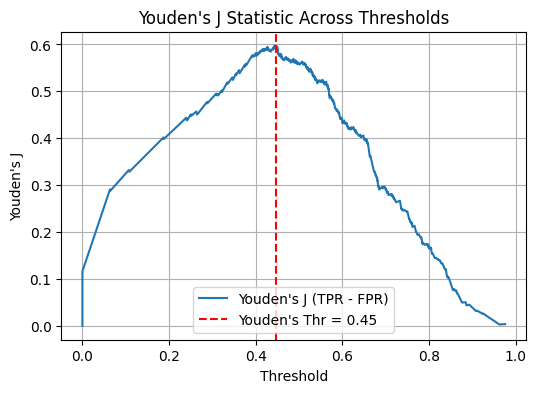

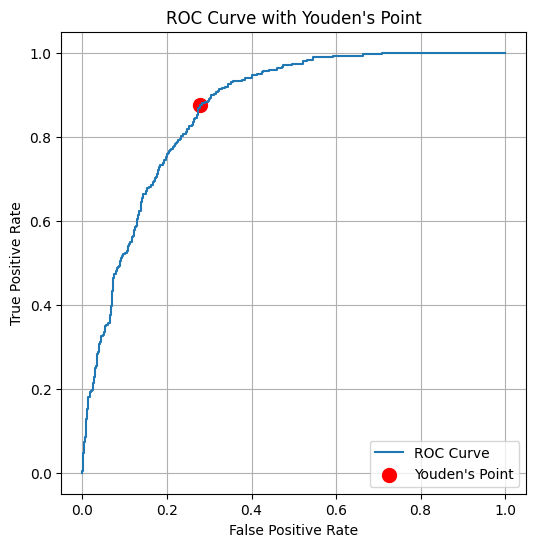

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve

# Assume y_true and y_prob are defined from recent validation

# Compute ROC and Youden's J
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
J = tpr - fpr
idx_j = np.argmax(J)
youden_thr = thresholds[idx_j]

# Plot Youden's J vs Threshold
plt.figure(figsize=(6, 4))
plt.plot(thresholds, J, label="Youden's J (TPR - FPR)")
plt.axvline(youden_thr, color='red', linestyle='--', label=f"Youden's Thr = {youden_thr:.2f}")
plt.xlabel('Threshold')
plt.ylabel("Youden's J")
plt.title("Youden's J Statistic Across Thresholds")
plt.legend()
plt.grid(True)
plt.show()

# Also overlay marker on ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.scatter(fpr[idx_j], tpr[idx_j], color='red', s=100, label="Youden's Point")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve with Youden's Point")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

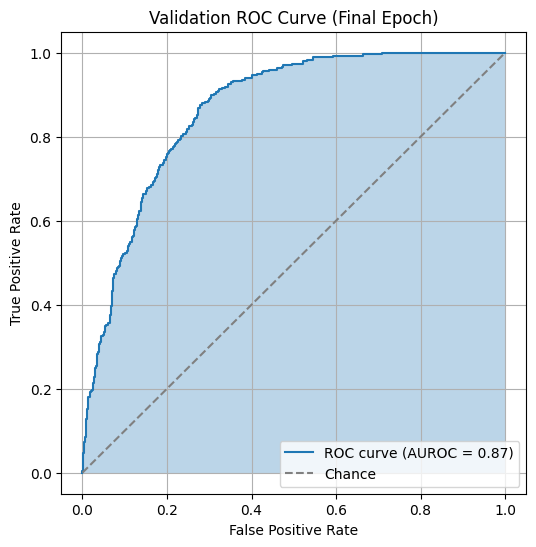

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# y_true and y_prob from the final epoch
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUROC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Chance')
plt.fill_between(fpr, tpr, alpha=0.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve (Final Epoch)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


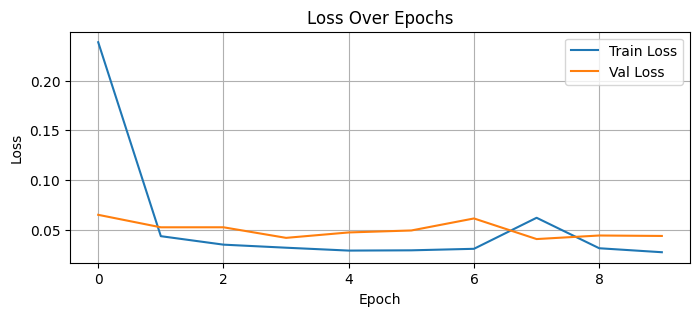

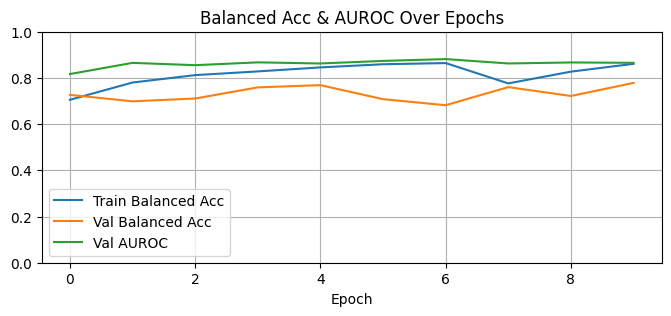

In [ ]:
# --- 7) Final plots -------------------------------------------

# Loss curves
plt.figure(figsize=(8,3))
plt.plot(train_losses,   label="Train Loss")
plt.plot(val_losses,     label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy & AUROC
plt.figure(figsize=(8,3))
plt.plot(train_bal_accs, label="Train Balanced Acc")
plt.plot(val_bal_accs,   label="Val Balanced Acc")
plt.plot(val_aurocs,     label="Val AUROC")
plt.title("Balanced Acc & AUROC Over Epochs")
plt.xlabel("Epoch")
plt.ylim(0,1)
plt.legend()
plt.grid(True)
plt.show()

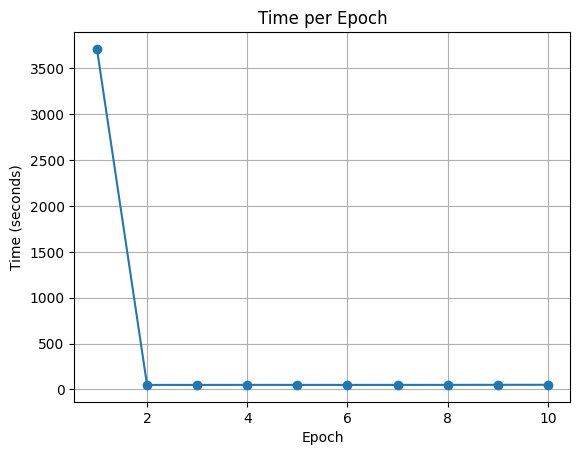

In [ ]:
plt.figure()
plt.plot(range(1, n_epochs + 1), epoch_times, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('Time per Epoch')
plt.grid(True)
plt.show()

In [ ]:
# 0) Compute and print overall AUROC
auroc = roc_auc_score(y_true, y_prob)
print(f"Overall AUROC = {auroc:.4f}")

# 1) Youden’s J threshold
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
J = tpr - fpr
idx_j = J.argmax()
youden_thresh = thresholds[idx_j]
y_pred_youden = (y_prob >= youden_thresh).astype(int)
youden_balacc = balanced_accuracy_score(y_true, y_pred_youden)
youden_f1     = precision_recall_fscore_support(y_true, y_pred_youden, average='macro')[2]
print(f"Youden’s J best threshold = {youden_thresh:.3f} | "
      f"BalAcc = {youden_balacc:.3f} | F1 = {youden_f1:.3f}")

# 2) F1‐optimal threshold
ths = np.linspace(0, 1, 101)
f1s = [f1_score(y_true, (y_prob >= t).astype(int)) for t in ths]
idx_f1 = int(np.argmax(f1s))
f1_thresh = ths[idx_f1]
y_pred_f1 = (y_prob >= f1_thresh).astype(int)
f1_balacc = balanced_accuracy_score(y_true, y_pred_f1)
f1_f1     = f1s[idx_f1]
print(f"F1‐opt threshold = {f1_thresh:.3f} | "
      f"BalAcc = {f1_balacc:.3f} | F1 = {f1_f1:.3f}")


Overall AUROC = 0.8654
Youden’s J best threshold = 0.447 | BalAcc = 0.799 | F1 = 0.688
F1‐opt threshold = 0.560 | BalAcc = 0.759 | F1 = 0.565


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# y_true and y_prob from the final epoch
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUROC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Chance')
plt.fill_between(fpr, tpr, alpha=0.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve (Final Epoch)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
def visualize_predictions(csv_file, image_dir, n=5):
    """
    Displays n correctly classified and n misclassified images side by side.

    Args:
        csv_file (str): Path to the CSV with columns ['filename', 'true', 'pred', 'prob'].
        image_dir (str): Directory containing the image files.
        n (int): Number of examples from each group to display.
    """
    # Load predictions
    df = pd.read_csv(csv_file)

    # Split correct and wrong
    correct = df[df['true'] == df['pred']]
    wrong   = df[df['true'] != df['pred']]

    # Sample up to n examples
    n_corr = min(n, len(correct))
    n_wrong = min(n, len(wrong))
    sample_correct = correct.sample(n_corr, random_state=42)
    sample_wrong = wrong.sample(n_wrong, random_state=42)

    # Create grid: 2 rows (correct, wrong), n columns
    fig, axes = plt.subplots(2, n, figsize=(n * 3, 6))

    # Plot correct predictions
    for i, row in enumerate(sample_correct.itertuples()):
        img = Image.open(os.path.join(image_dir, row.filename)).convert('RGB')
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"True={row.true}")
        axes[0, i].axis('off')

    # Plot wrong predictions
    for i, row in enumerate(sample_wrong.itertuples()):
        img = Image.open(os.path.join(image_dir, row.filename)).convert('RGB')
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"T={row.true}, P={row.pred}")
        axes[1, i].axis('off')

    # Label rows
    axes[0, 0].set_ylabel('Correct', size=14)
    axes[1, 0].set_ylabel('Wrong', size=14)

    plt.tight_layout()
    plt.show()

visualize_predictions('val_preds_epoch_3.csv', PATH, n=5)


In [ ]:
# Get the first batch from train_loader
first_batch = next(iter(train_loader))

# Unpack images and labels
images, labels = first_batch

# Print shapes
print("images.shape:", images.shape)   # e.g. [32, 3, 224, 224]
print("labels.shape:", labels.shape)   # e.g. [32]

# Print the first example in that batch
print("First image tensor:", images[0])
print("First label:", labels[0].item())


In [ ]:
plt.plot(epoch_times, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.title("Epoch Duration")
plt.grid(True)
plt.show()

In [ ]:

# Load validation predictions
df = pd.read_csv('val_preds_epoch_3.csv')

# Number of actual cancer cases
true_cancer = df[df['true'] == 1]
n_true_cancer = len(true_cancer)

# Among those, how many were correctly predicted as cancer (true positive rate)
tp = len(true_cancer[true_cancer['pred'] == 1])
pct_correct_cancer = tp / n_true_cancer * 100 if n_true_cancer else 0.0

# Number of actual non-cancer cases
true_noncancer = df[df['true'] == 0]
n_true_noncancer = len(true_noncancer)

# Among those, how many were correctly predicted as non-cancer (true negative rate)
tn = len(true_noncancer[true_noncancer['pred'] == 0])
pct_correct_noncancer = tn / n_true_noncancer * 100 if n_true_noncancer else 0.0

print(f'Correct cancer diagnoses: {tp}/{n_true_cancer} = {pct_correct_cancer:.2f}%')
print(f'Correct non-cancer diagnoses: {tn}/{n_true_noncancer} = {pct_correct_noncancer:.2f}%')

In [ ]:
# Check train split
counts = np.bincount([lbl for _, lbl in train_loader.dataset])
print("Train labels 0,1:", counts)

# Check val split
counts = np.bincount([lbl for _, lbl, _ in val_loader.dataset])
print("Val   labels 0,1:", counts)


In [ ]:
# Choose an example index
index = 6  # change this to test a different image
test_dataset = SkinCancerDataset(test_df, PATH, transform=train_transform)
# Get the image tensor and true label from your dataset
image_tensor, true_label = train_dataset[index]

# Prepare the input batch and move to device
input_tensor = image_tensor.unsqueeze(0).to(device)

# Run inference
model.eval()
with torch.inference_mode():
    logit = model(input_tensor).squeeze()
    prob = torch.sigmoid(logit).item()         # probability of class “1” (malignant)
    pred = 1 if prob > 0.5 else 0              # threshold at 0.5

# Map numeric labels to strings
label_map = {0: "Benign", 1: "Malignant"}

# Print results
print(f"True label:      {label_map[int(true_label.item())]}")
print(f"Predicted label: {label_map[pred]}  (probability = {prob:.4f})")


In [ ]:
print("Val split counts:\n", val_df["label"].value_counts())


In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

In [ ]:
torchinfo.summary(model=model,
        input_size=(16, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Visualize samples image and tensor values:

In [ ]:
"""
def show_tensor_image(tensor, mean=0.5, std=0.5):

    #Display a single image given a tensor of shape (C, H, W).
    #Assumes the tensor was normalized with transforms.Normalize([mean]*3, [std]*3).

    img = tensor.cpu().clone()          # clone to avoid modifying original
    img = img * std + mean             # unnormalize
    img = img.permute(1, 2, 0).numpy()  # C×H×W -> H×W×C
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

index = 8111
sample = train_dataset[index][0] #substituir por val para ver
label = train_dataset[index][1]
show_tensor_image(sample)
print(label)"""

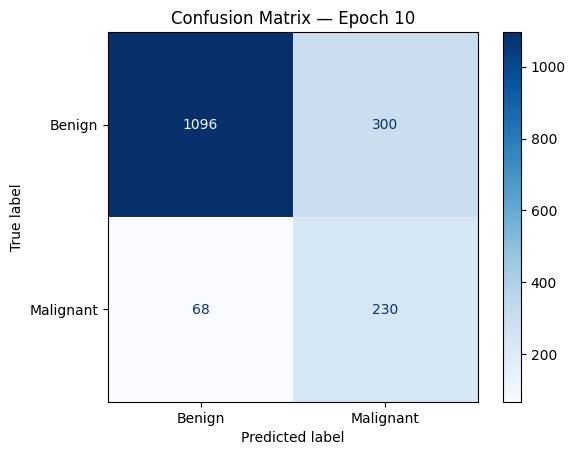

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f"Confusion Matrix — Epoch {epoch+1}")
plt.show()